In [33]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools
from scipy import stats 
import time

#matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [4]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


Reading in Data

In [12]:
df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [13]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [14]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [15]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [16]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [17]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()


family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

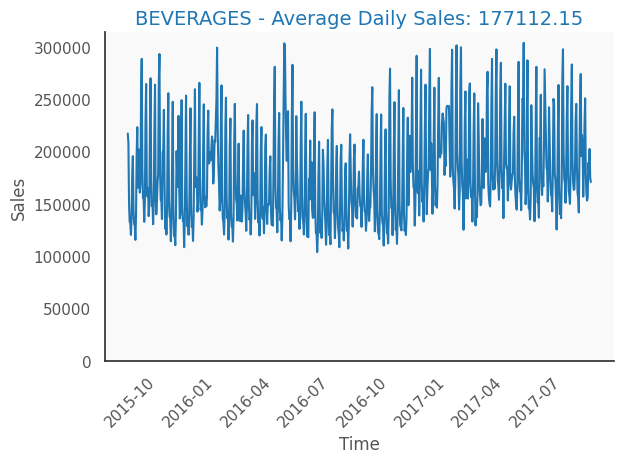

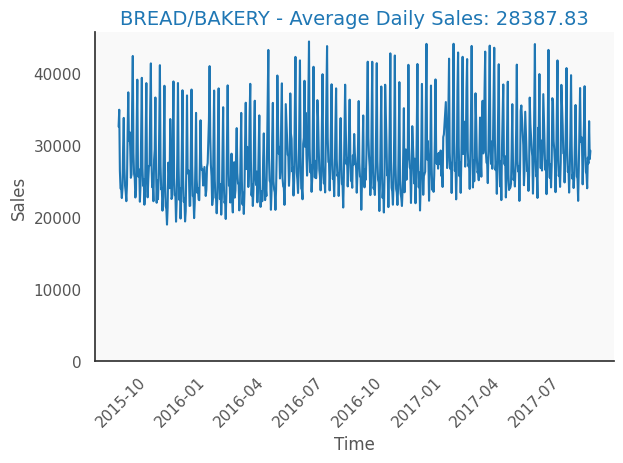

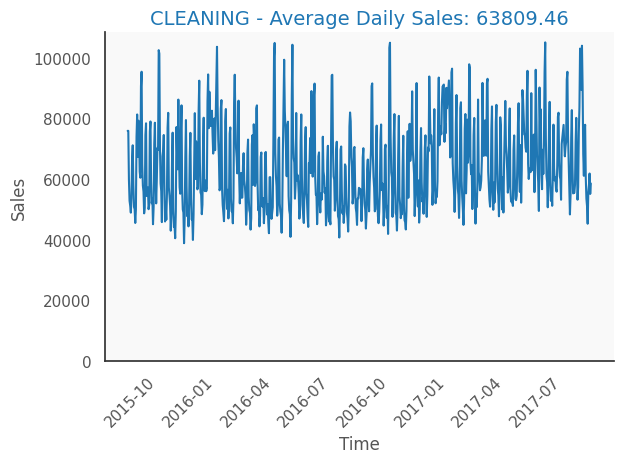

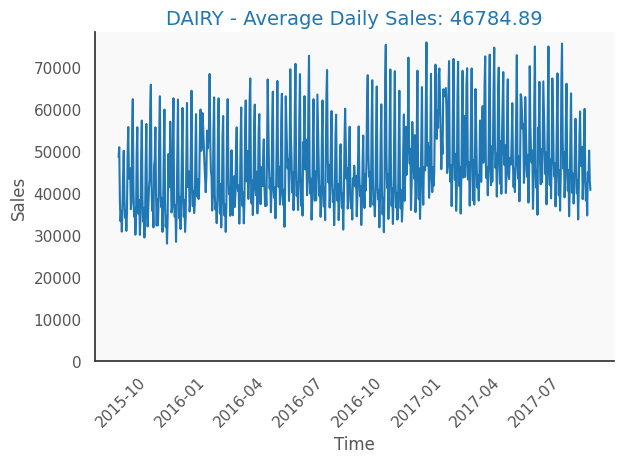

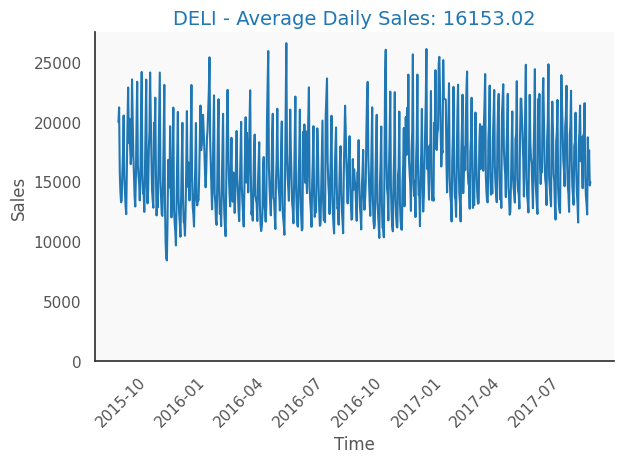

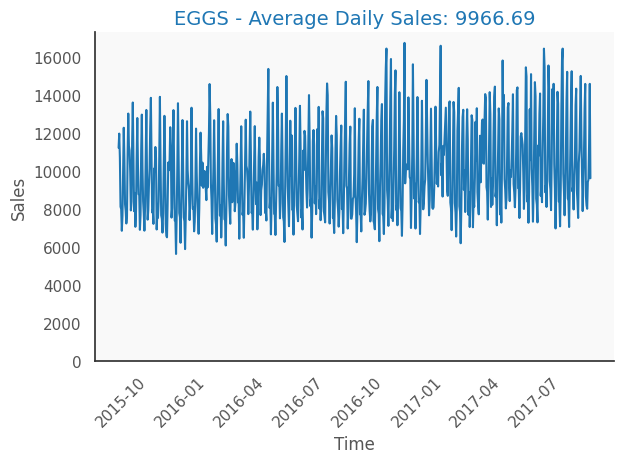

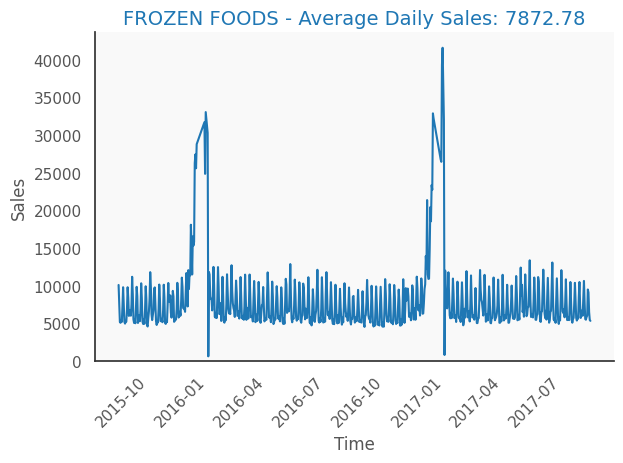

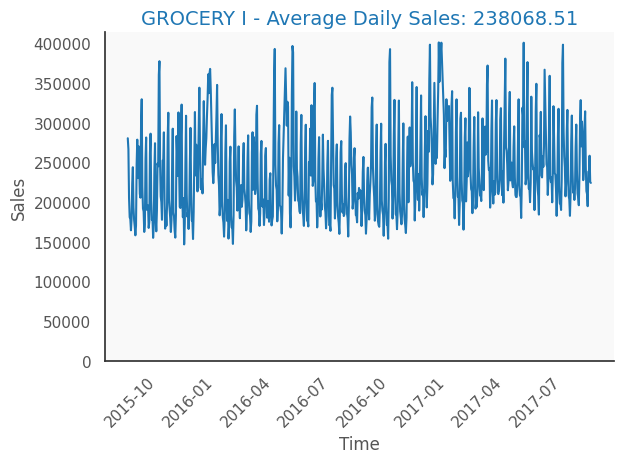

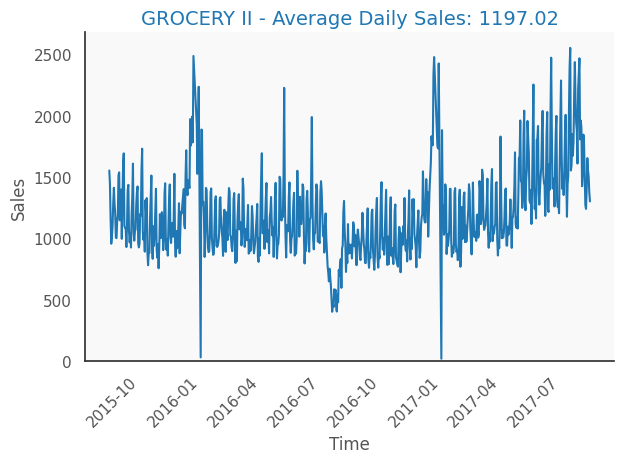

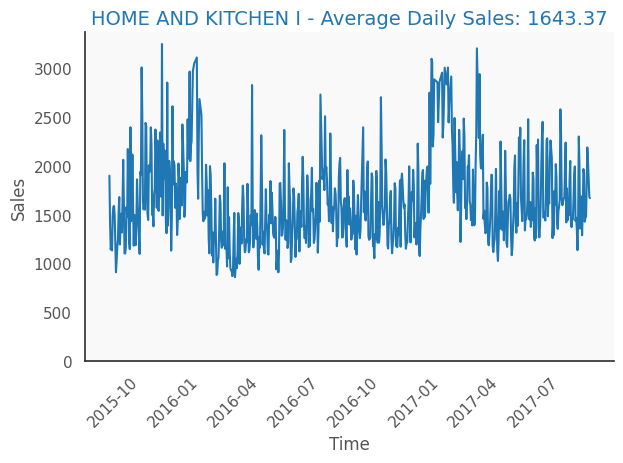

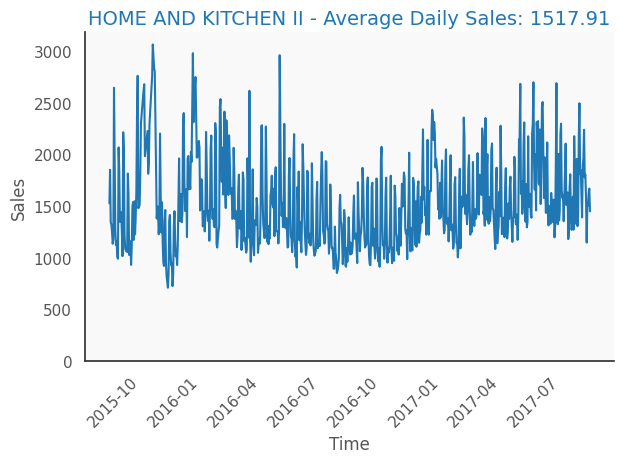

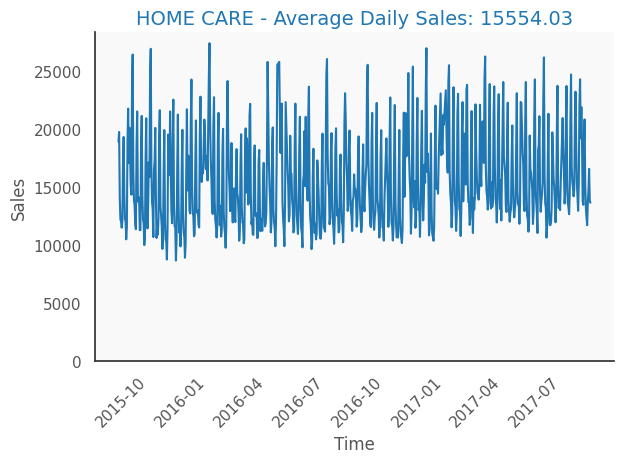

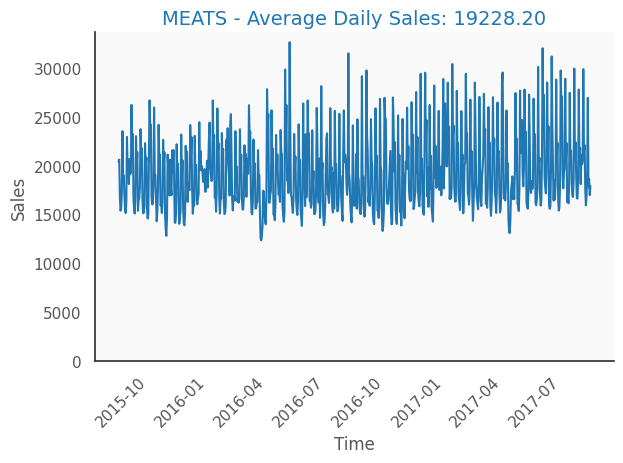

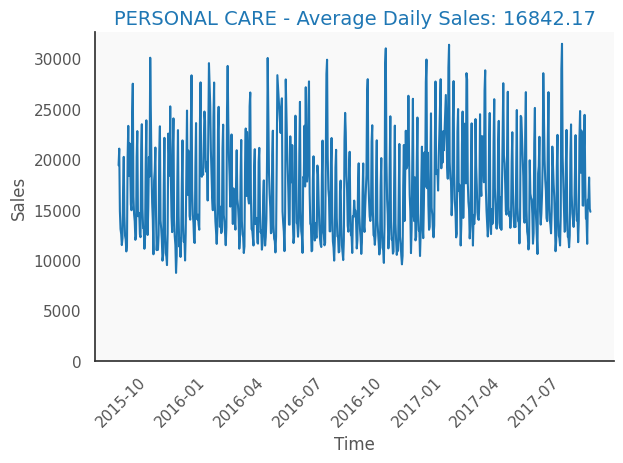

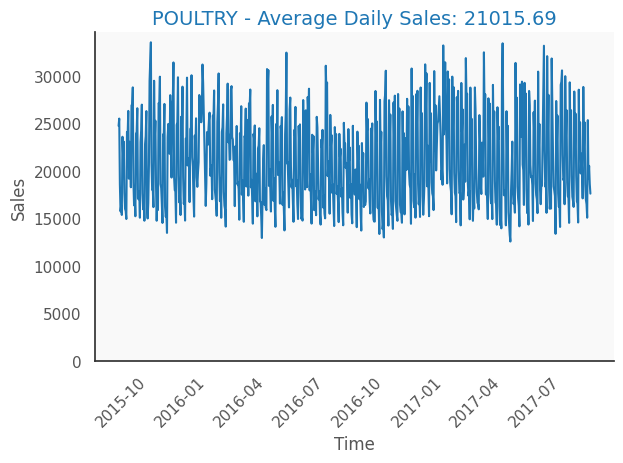

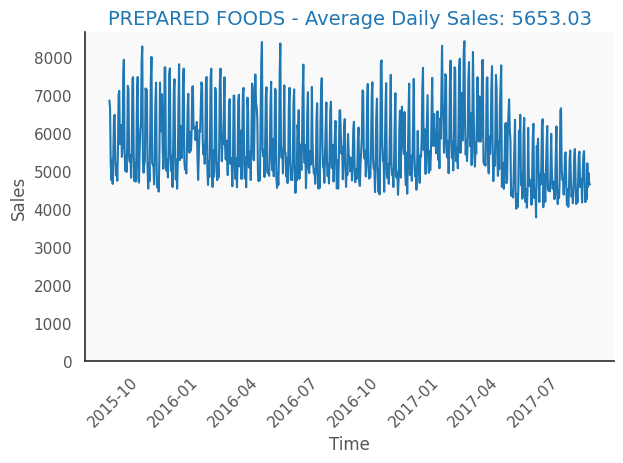

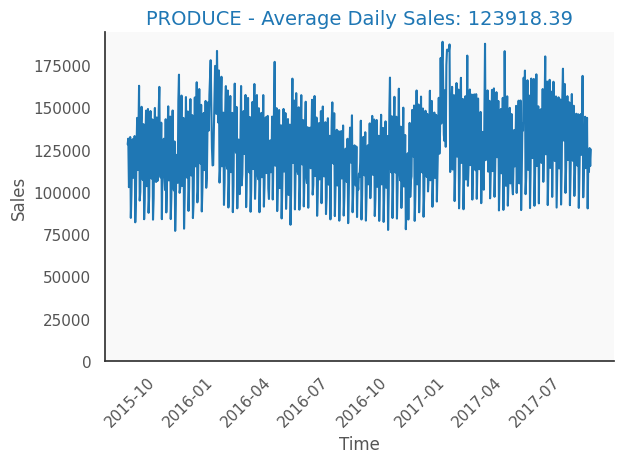

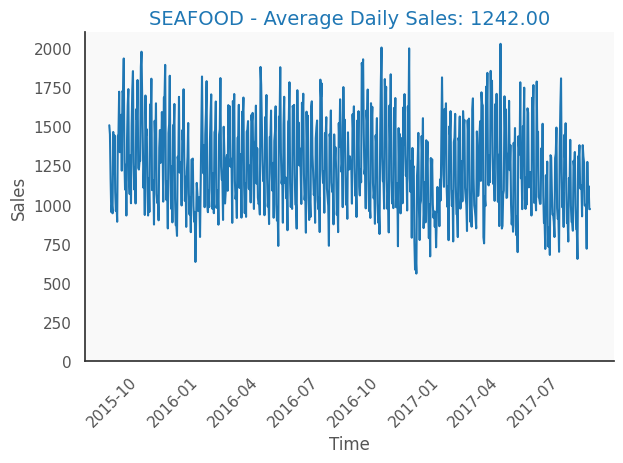

In [42]:
import matplotlib.pyplot as plt

plt.rcParams["axes.facecolor"] = "#f9f9f9"
plt.rcParams["axes.edgecolor"] = "#333333"
plt.rcParams["axes.labelcolor"] = "#555555"
plt.rcParams["xtick.color"] = "#555555"
plt.rcParams["ytick.color"] = "#555555"
plt.rcParams["font.family"] = "DejaVu Sans"

for i in range(len(prediction_df_list)):
    plt.figure()
    plt.plot(prediction_df_list[i], color="#1f77b4")
    avg_sales = prediction_df_list[i].mean().values[0]
    plt.title(f"{prediction_df_list[i].columns[0]} - Average Daily Sales: {avg_sales:.2f}", 
              fontsize=14, fontweight='normal', color="#1f77b4")
    plt.ylim(ymin=0)
    plt.xlabel("Time", fontsize=12, color="#555555")
    plt.ylabel("Sales", fontsize=12, color="#555555")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [26]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [27]:
missing_data(total_sales_df).head()


Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

DATA CLEANING

In [28]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")



Dropping 14 columns due to insufficient data volume.


In [29]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))


family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

In [30]:

print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


In [34]:


#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)



Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


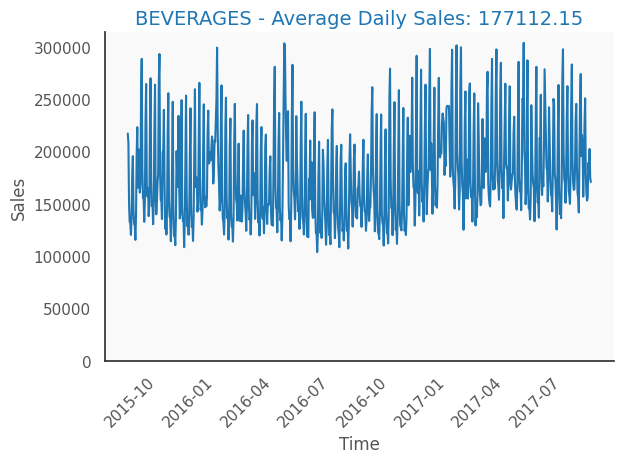

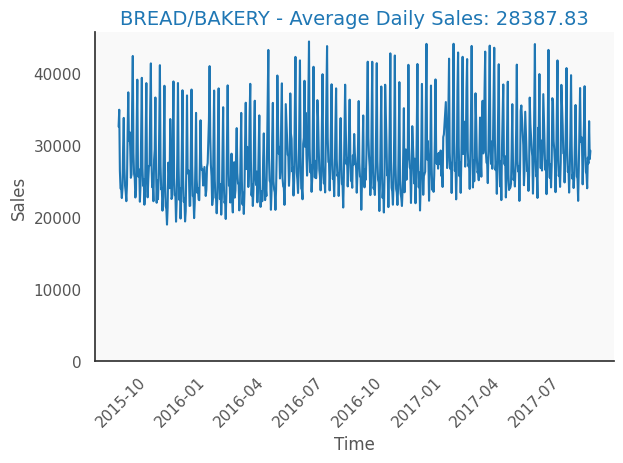

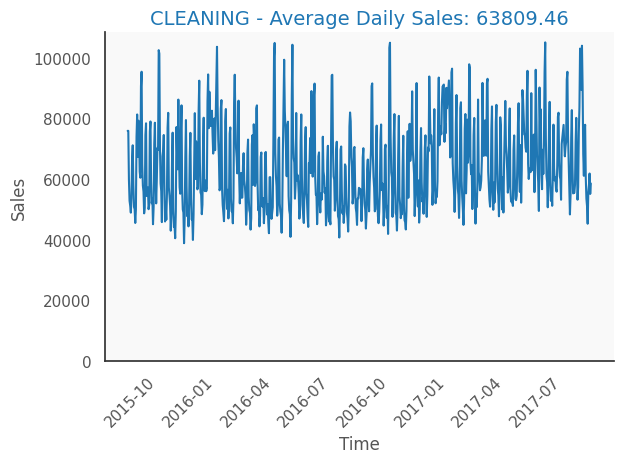

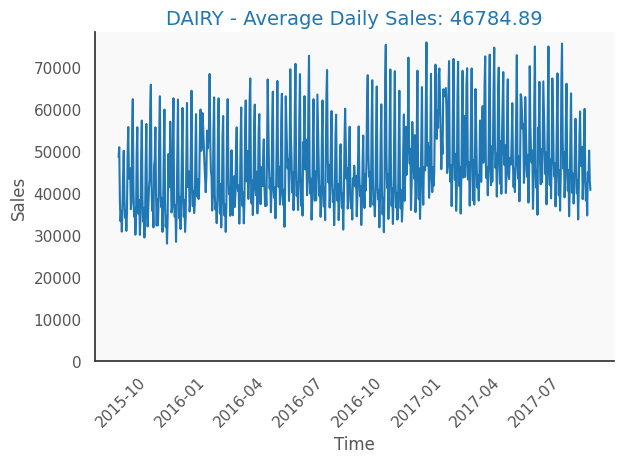

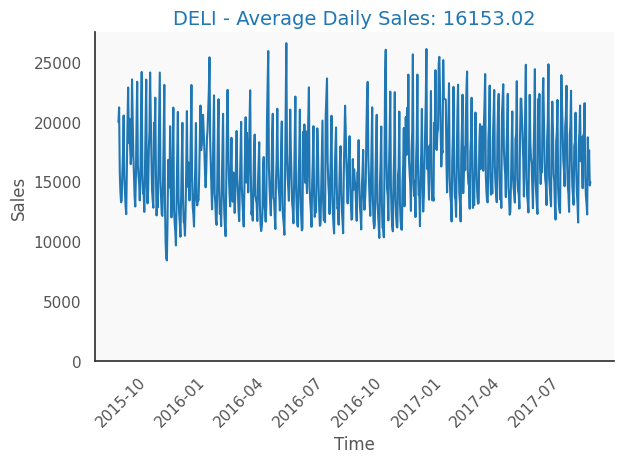

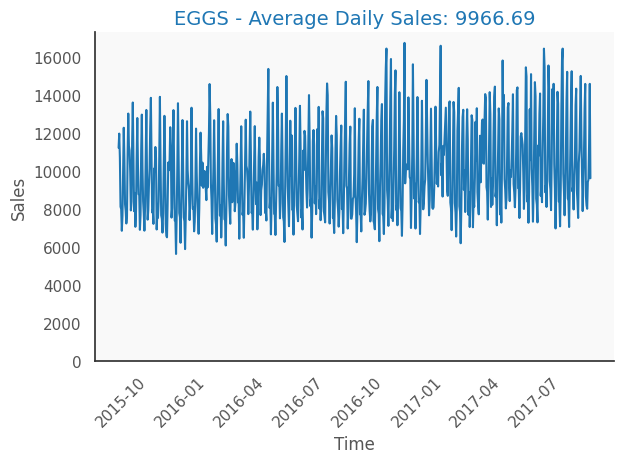

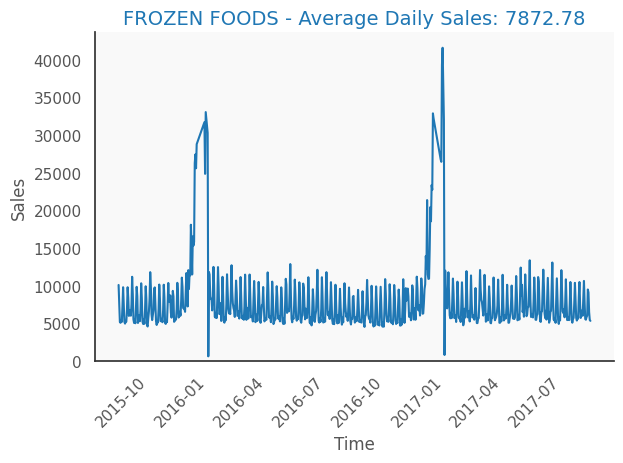

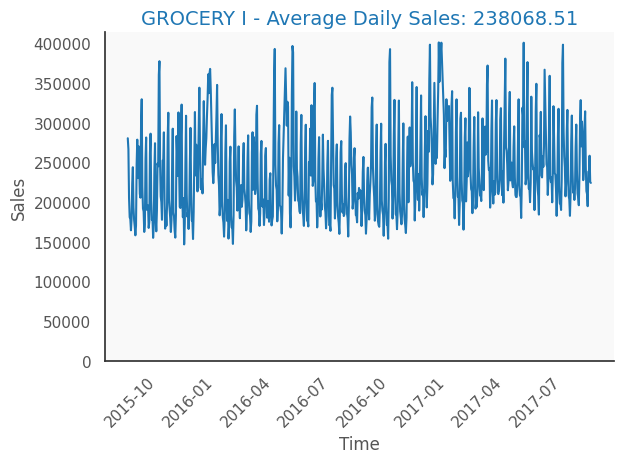

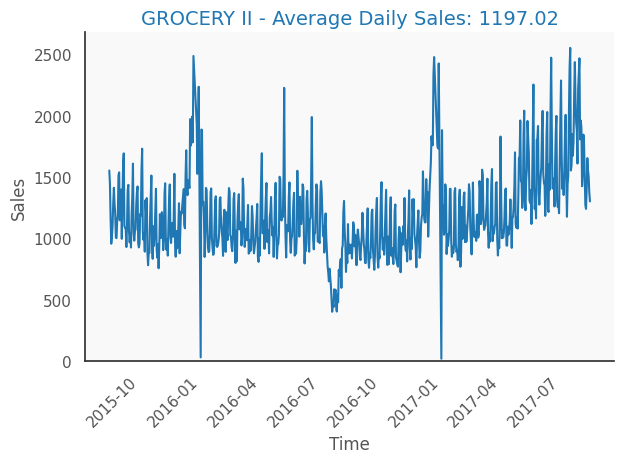

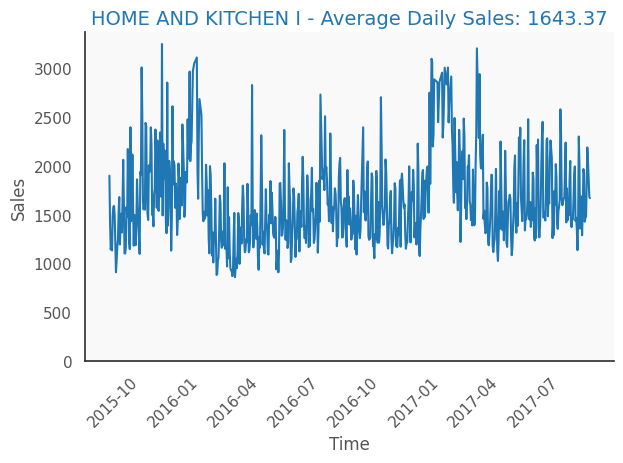

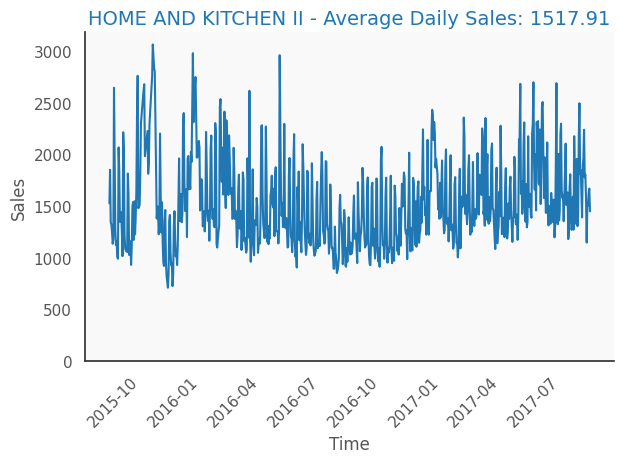

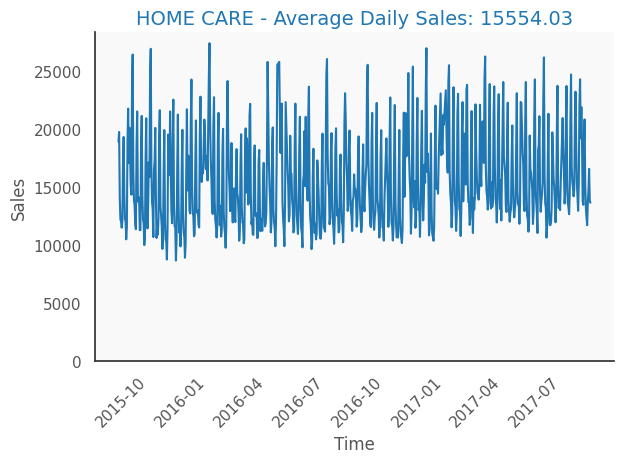

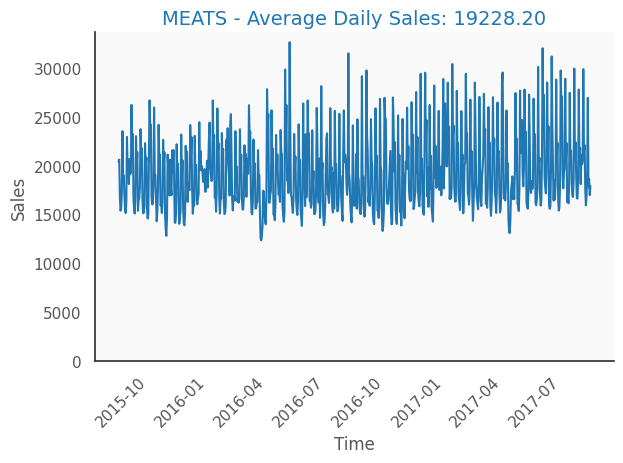

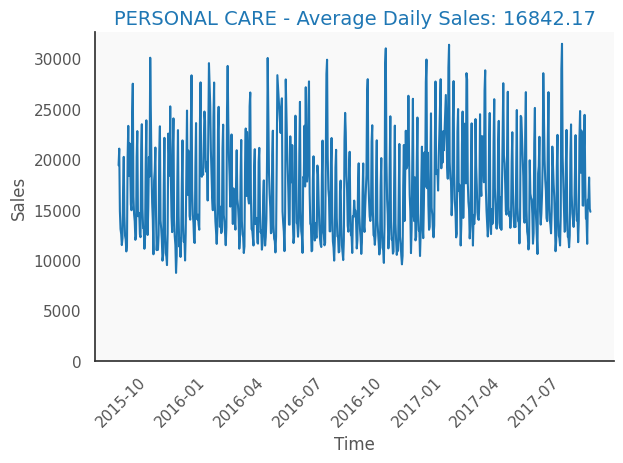

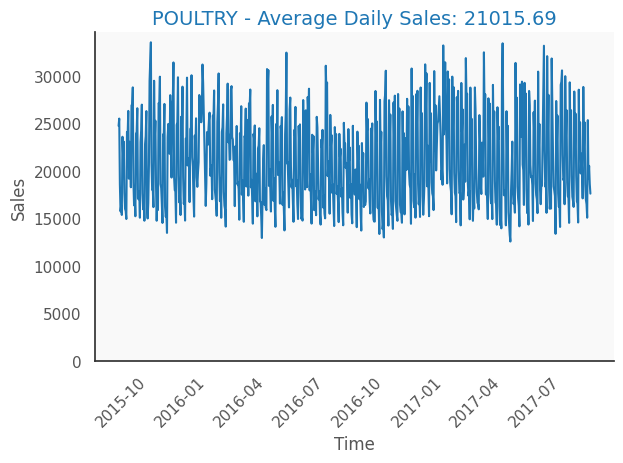

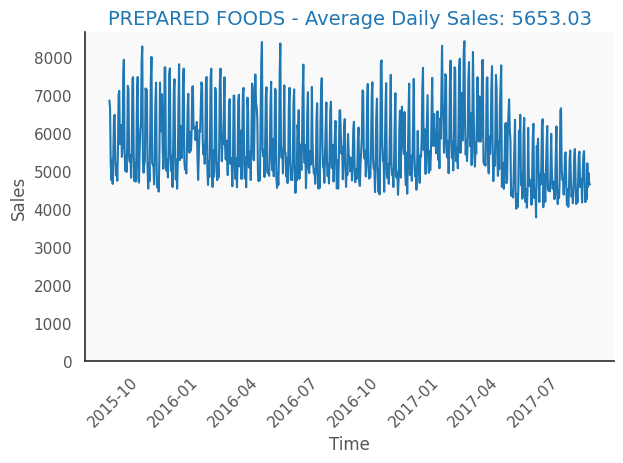

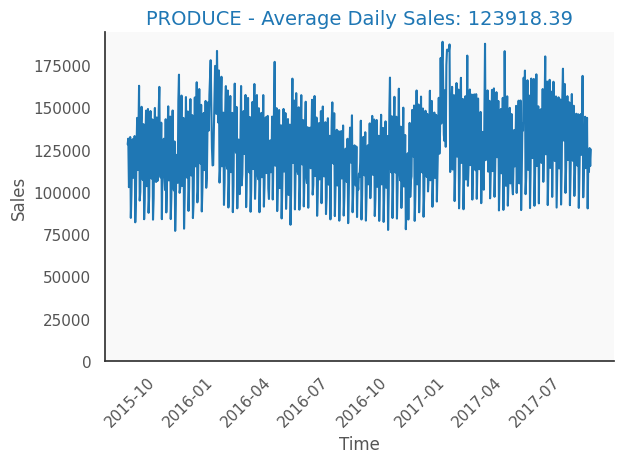

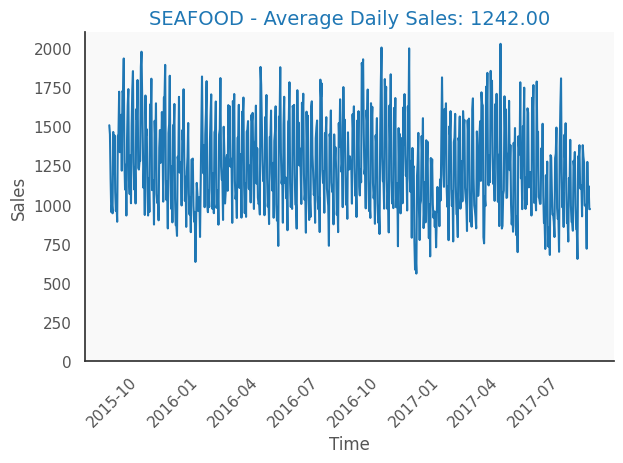

In [43]:
plt.rcParams["axes.facecolor"] = "#f9f9f9"
plt.rcParams["axes.edgecolor"] = "#333333"
plt.rcParams["axes.labelcolor"] = "#555555"
plt.rcParams["xtick.color"] = "#555555"
plt.rcParams["ytick.color"] = "#555555"
plt.rcParams["font.family"] = "DejaVu Sans"

for i in range(len(prediction_df_list)):
    plt.figure()
    plt.plot(prediction_df_list[i], color="#1f77b4")
    avg_sales = prediction_df_list[i].mean().values[0]
    plt.title(f"{prediction_df_list[i].columns[0]} - Average Daily Sales: {avg_sales:.2f}", 
              fontsize=14, fontweight='normal', color="#1f77b4")
    plt.ylim(ymin=0)
    plt.xlabel("Time", fontsize=12, color="#555555")
    plt.ylabel("Sales", fontsize=12, color="#555555")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



- Impute or drop situations for the Liquor, Beer, Wine category since there are many 0s in the first years worth of data. See if it improves the MAPE after cross-validation.
- mpute or drop situations for the Grocery II and Frozen Food categories since there are 0s near the January 1st beginning of the year timeline that didn't get dropped during the z-score outlier automation. See if it improves the MAPE after cross-validation.
- Adjust the z-score outlier parameter by checking out the Gaussian Distribution for different z-scores, check cut-offs and counts of rows being dropped, and see if there's an ideal situation for getting the best MAPE. (Idea is to loop through possible z-score possibilies, perhaps between 5 linear possibilities between 2.5 --> 3 and run the models with the best hypertuned parameters based on cross-validation below to see if MAPE's change with a change in z-score outlier drops.



PLOTTING CATEGORIES


In [50]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [51]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

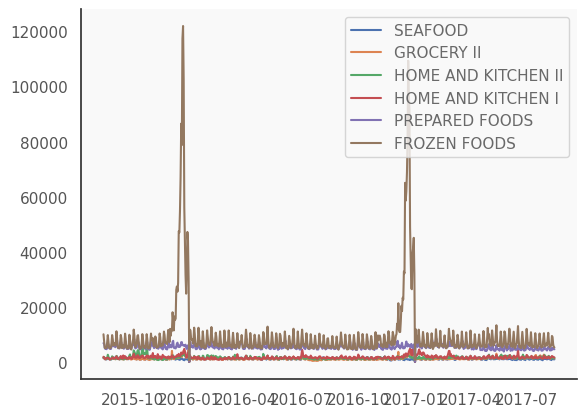

In [52]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

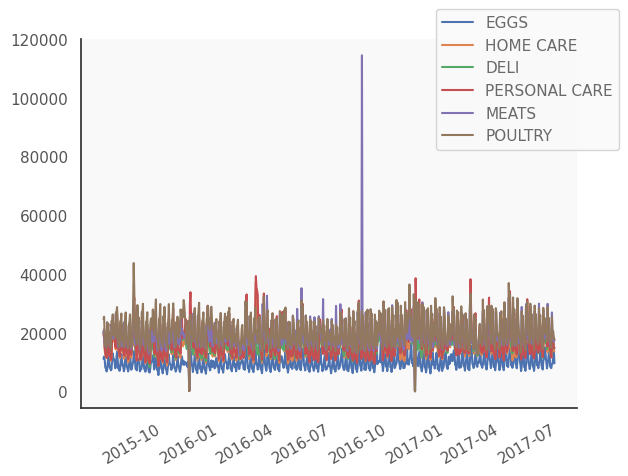

In [53]:


plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()



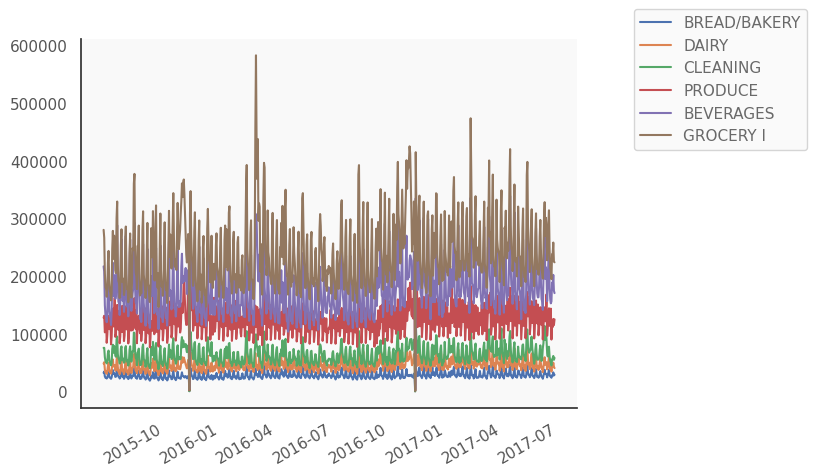

In [54]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()


HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

    changepoint_prior_scale [0.001, 0.5]
    seasonality_prior_scale [0.01, 10]
    holidays_prior_scale [0.01, 10]
    seasonality_mode ['additive', 'multiplicative'].
    changepoint_range [0.5, 0.95]


In [55]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)


[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [56]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))


In [57]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

02:19:20 - cmdstanpy - INFO - Chain [1] start processing
02:19:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:19:20 - cmdstanpy - INFO - Chain [1] start processing
02:19:20 - cmdstanpy - INFO - Chain [1] done processing
02:19:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:20 - cmdstanpy - INFO - Chain [1] start processing
02:19:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.57it/s]02:19:20 - cmdstanpy - INFO - Chain [1] start processing
02:19:20 - cmdstanpy - INFO - Chain [1] done processing
02:19:20 - cmdstanpy - INFO - Chain [1] start processing
02:19:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.95it/s]02:19:20 - cmdstanpy - INFO - Chain [1] start

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2026984248.58 45022.04 34005.50  0.33   0.15   0.20      0.63


  0%|          | 0/12 [00:00<?, ?it/s]02:19:23 - cmdstanpy - INFO - Chain [1] start processing
02:19:23 - cmdstanpy - INFO - Chain [1] done processing
02:19:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:23 - cmdstanpy - INFO - Chain [1] start processing
02:19:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:08,  1.36it/s]02:19:24 - cmdstanpy - INFO - Chain [1] start processing
02:19:24 - cmdstanpy - INFO - Chain [1] done processing
02:19:24 - cmdstanpy - INFO - Chain [1] start processing
02:19:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.31it/s]02:19:24 - cmdstanpy - INFO - Chain [1] start processing
02:19:24 - cmdstanpy - INFO - Chain [1] done processing
02:19:24 - cmdstanpy - INFO - Chain [1] start processing
02:19:24 - cmdstanpy - INFO - Chain [1] done processing
02:19:24 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2161021657.18 46486.79 36388.80  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]02:19:26 - cmdstanpy - INFO - Chain [1] start processing
02:19:26 - cmdstanpy - INFO - Chain [1] done processing
02:19:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:26 - cmdstanpy - INFO - Chain [1] start processing
02:19:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:08,  1.29it/s]02:19:27 - cmdstanpy - INFO - Chain [1] start processing
02:19:27 - cmdstanpy - INFO - Chain [1] done processing
02:19:27 - cmdstanpy - INFO - Chain [1] start processing
02:19:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.96it/s]02:19:27 - cmdstanpy - INFO - Chain [1] start processing
02:19:27 - cmdstanpy - INFO - Chain [1] done processing
02:19:27 - cmdstanpy - INFO - Chain [1] start processing
02:19:27 - cmdstanpy - INFO - Chain [1] done processing
02:19:27 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2167321869.56 46554.50 36442.50  0.37   0.17   0.22      0.56


  0%|          | 0/12 [00:00<?, ?it/s]02:19:30 - cmdstanpy - INFO - Chain [1] start processing
02:19:30 - cmdstanpy - INFO - Chain [1] done processing
02:19:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:30 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:06,  1.70it/s]02:19:31 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
02:19:31 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]02:19:31 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
02:19:31 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
02:19:31 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2158993562.95 46464.97 36279.35  0.36   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]02:19:34 - cmdstanpy - INFO - Chain [1] start processing
02:19:34 - cmdstanpy - INFO - Chain [1] done processing
02:19:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:34 - cmdstanpy - INFO - Chain [1] start processing
02:19:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:06,  1.67it/s]02:19:34 - cmdstanpy - INFO - Chain [1] start processing
02:19:34 - cmdstanpy - INFO - Chain [1] done processing
02:19:35 - cmdstanpy - INFO - Chain [1] start processing
02:19:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]02:19:35 - cmdstanpy - INFO - Chain [1] start processing
02:19:35 - cmdstanpy - INFO - Chain [1] done processing
02:19:35 - cmdstanpy - INFO - Chain [1] start processing
02:19:35 - cmdstanpy - INFO - Chain [1] done processing
02:19:35 - cmdstanpy - ERROR - Chain

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160905009.29 46485.54 36360.71  0.37   0.17   0.22      0.55


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.80it/s]02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.59it/s]02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
02:19:38 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.32it/s]02:19:38 - cmdstanpy - INFO - Chain [1] st

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1028487954.68 32070.05 22281.31  0.29   0.09   0.12      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.36it/s]02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.95it/s]02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.18it/s]02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:39 - cmdstanpy - INFO - Chain [1] done processing
02:19:39 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1007123186.06 31735.20 21510.75  0.30   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.86it/s]02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.86it/s]02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.52it/s]02:19:40 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
02:19:40 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1011460583.29 31803.47 21639.58  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.98it/s]02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.47it/s]02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.77it/s]02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:41 - cmdstanpy - INFO - Chain [1] done processing
02:19:41 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1009119778.06 31766.65 21515.24  0.30   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.71it/s]02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.31it/s]02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.47it/s]02:19:42 - cmdstanpy - INFO - Chain [1] start processing
02:19:42 - cmdstanpy - INFO - Chain [1] done processing
02:19:42 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1012390404.17 31818.08 21551.23  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.79it/s]02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.13it/s]02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.96it/s]02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
02:19:44 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1046877718.05 32355.49 22194.24  0.30   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:19:44 - cmdstanpy - INFO - Chain [1] start processing
02:19:44 - cmdstanpy - INFO - Chain [1] done processing
02:19:44 - cmdstanpy - INFO - Chain [1] start processing
02:19:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.15it/s]02:19:44 - cmdstanpy - INFO - Chain [1] start processing
02:19:44 - cmdstanpy - INFO - Chain [1] done processing
02:19:44 - cmdstanpy - INFO - Chain [1] start processing
02:19:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.33it/s]02:19:44 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.40it/s]02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
02:19:45 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1066061397.46 32650.60 22145.91  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.73it/s]02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.80it/s]02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.15it/s]02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
02:19:46 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1075878913.11 32800.59 22284.30  0.31   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:46 - cmdstanpy - INFO - Chain [1] done processing
02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:47 - cmdstanpy - INFO - Chain [1] done processing
02:19:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:19:47 - cmdstanpy - INFO - Chain [1] start processing
02:19:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:07,  1.40it/s]02:19:48 - cmdstanpy - INFO - Chain [1] start processing
02:19:48 - cmdstanpy - INFO - Chain [1] done processing
02:19:48 - cmdstanpy - INFO - Chain [1] start processing
02:19:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.99it/s]02:19:48 - cmdstanpy - INFO - Chain [1] start processing
02:19:48 - cmdstanpy - INFO - Chain [1] done processing
02:19:48 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1073974004.77 32771.54 22288.19  0.31   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.57it/s]02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.21it/s]02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.12it/s]02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
02:19:49 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1073460963.57 32763.71 22231.69  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.50it/s]02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.12it/s]02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.47it/s]02:19:50 - cmdstanpy - INFO - Chain [1] start processing
02:19:50 - cmdstanpy - INFO - Chain [1] done processing
02:19:51 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1041676580.83 32275.01 22065.58  0.30   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.93it/s]02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.56it/s]02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
02:19:51 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.63it/s]02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
02:19:52 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1113304213.78 33366.21 23071.12  0.31   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.61it/s]02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.26it/s]02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.01it/s]02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
02:19:53 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1107110716.97 33273.27 22930.67  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.81it/s]02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.16it/s]02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.31it/s]02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
02:19:54 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1117366482.17 33427.03 23141.70  0.31   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.75it/s]02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.21it/s]02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.10it/s]02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
02:19:55 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1129663933.94 33610.47 23364.90  0.32   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.26it/s]02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.08it/s]02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.71it/s]02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
02:19:56 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1029880928.65 32091.76 21887.08  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.75it/s]02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.49it/s]02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
02:19:57 - cmdstanpy - INFO - Chain [1] start processing
02:19:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.86it/s]02:19:58 - cmdstanpy - INFO - Chain [1] start processing
02:19:58 - cmdstanpy - INFO - Chain [1] done processing
02:19:58 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1155714204.82 33995.80 23831.55  0.32   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:19:58 - cmdstanpy - INFO - Chain [1] start processing
02:19:58 - cmdstanpy - INFO - Chain [1] done processing
02:19:58 - cmdstanpy - INFO - Chain [1] start processing
02:19:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.18it/s]02:19:58 - cmdstanpy - INFO - Chain [1] start processing
02:19:58 - cmdstanpy - INFO - Chain [1] done processing
02:19:59 - cmdstanpy - INFO - Chain [1] start processing
02:19:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.94it/s]02:19:59 - cmdstanpy - INFO - Chain [1] start processing
02:19:59 - cmdstanpy - INFO - Chain [1] done processing
02:19:59 - cmdstanpy - INFO - Chain [1] start processing
02:19:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.84it/s]02:19:59 - cmdstanpy - INFO - Chain [1] start processing
02:19:59 - cmdstanpy - INFO - Chain [1] done processing
02:19:59 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1160953815.63 34072.77 23892.08  0.32   0.11   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:19:59 - cmdstanpy - INFO - Chain [1] start processing
02:19:59 - cmdstanpy - INFO - Chain [1] done processing
02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.92it/s]02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.87it/s]02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.31it/s]02:20:00 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
02:20:00 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1171406712.52 34225.82 24138.09  0.32   0.11   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.97it/s]02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.82it/s]02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.90it/s]02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:01 - cmdstanpy - INFO - Chain [1] done processing
02:20:01 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1165597075.09 34140.84 23926.55  0.32   0.11   0.13      0.74
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.33
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


  0%|          | 0/12 [00:00<?, ?it/s]02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.29it/s]02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.70it/s]02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
02:20:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:02 - cmdstanpy - INFO - Chain [1] start processing
02:20:03 - cmdstanpy - INFO - Chain [1] done processing
02:20:03 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17976794.82 4239.91 2857.00  0.29   0.07   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.79it/s]02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.80it/s]02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
02:20:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:06 - cmdstanpy - INFO - Chain [1] done processing
02:20:06 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18773932.90 4332.89 3027.96  0.30   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:20:08 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.22it/s]02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 18.10it/s]02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
02:20:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
02:20:09 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19900030.50 4460.95 3140.26  0.31   0.09   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.35it/s]02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.13it/s]02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
02:20:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:12 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
02:20:12 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19739638.00 4442.93 3084.57  0.31   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:20:14 - cmdstanpy - INFO - Chain [1] start processing
02:20:14 - cmdstanpy - INFO - Chain [1] done processing
02:20:14 - cmdstanpy - INFO - Chain [1] start processing
02:20:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.73it/s]02:20:15 - cmdstanpy - INFO - Chain [1] start processing
02:20:15 - cmdstanpy - INFO - Chain [1] done processing
02:20:15 - cmdstanpy - INFO - Chain [1] start processing
02:20:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.07it/s]02:20:15 - cmdstanpy - INFO - Chain [1] start processing
02:20:15 - cmdstanpy - INFO - Chain [1] done processing
02:20:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:15 - cmdstanpy - INFO - Chain [1] start processing
02:20:15 - cmdstanpy - INFO - Chain [1] done processing
02:20:15 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22889293.96 4784.28 3399.21  0.32   0.09   0.12      0.68


  0%|          | 0/12 [00:00<?, ?it/s]02:20:17 - cmdstanpy - INFO - Chain [1] start processing
02:20:17 - cmdstanpy - INFO - Chain [1] done processing
02:20:17 - cmdstanpy - INFO - Chain [1] start processing
02:20:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.22it/s]02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.97it/s]02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.32it/s]02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
02:20:18 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14436364.92 3799.52 2577.15  0.29   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
02:20:18 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.88it/s]02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.75it/s]02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.73it/s]02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
02:20:19 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14762150.51 3842.15 2509.33  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:19 - cmdstanpy - INFO - Chain [1] done processing
02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.08it/s]02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.12it/s]02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.40it/s]02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
02:20:20 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14776586.97 3844.03 2515.58  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:20 - cmdstanpy - INFO - Chain [1] start processing
02:20:20 - cmdstanpy - INFO - Chain [1] done processing
02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.31it/s]02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.01it/s]02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.48it/s]02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:21 - cmdstanpy - INFO - Chain [1] done processing
02:20:21 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14782893.09 3844.85 2516.09  0.30   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:20:21 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.22it/s]02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.29it/s]02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.89it/s]02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
02:20:22 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14749159.88 3840.46 2505.38  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:22 - cmdstanpy - INFO - Chain [1] start processing
02:20:22 - cmdstanpy - INFO - Chain [1] done processing
02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.98it/s]02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.06it/s]02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.42it/s]02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
02:20:23 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14062510.98 3750.00 2480.38  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.47it/s]02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.84it/s]02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.01it/s]02:20:24 - cmdstanpy - INFO - Chain [1] start processing
02:20:24 - cmdstanpy - INFO - Chain [1] done processing
02:20:24 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14509345.73 3809.11 2447.73  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.07it/s]02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.63it/s]02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.76it/s]02:20:25 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
02:20:25 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14510782.14 3809.30 2449.99  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.32it/s]02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.07it/s]02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.94it/s]02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:26 - cmdstanpy - INFO - Chain [1] done processing
02:20:26 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14541161.58 3813.29 2451.09  0.30   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.93it/s]02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.33it/s]02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.38it/s]02:20:27 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
02:20:28 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14446350.70 3800.84 2440.12  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:28 - cmdstanpy - INFO - Chain [1] start processing
02:20:28 - cmdstanpy - INFO - Chain [1] done processing
02:20:28 - cmdstanpy - INFO - Chain [1] start processing
02:20:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.68it/s]02:20:28 - cmdstanpy - INFO - Chain [1] start processing
02:20:28 - cmdstanpy - INFO - Chain [1] done processing
02:20:28 - cmdstanpy - INFO - Chain [1] start processing
02:20:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.09it/s]02:20:29 - cmdstanpy - INFO - Chain [1] start processing
02:20:29 - cmdstanpy - INFO - Chain [1] done processing
02:20:29 - cmdstanpy - INFO - Chain [1] start processing
02:20:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.25it/s]02:20:29 - cmdstanpy - INFO - Chain [1] start processing
02:20:29 - cmdstanpy - INFO - Chain [1] done processing
02:20:29 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13835454.50 3719.60 2428.64  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:20:29 - cmdstanpy - INFO - Chain [1] start processing
02:20:29 - cmdstanpy - INFO - Chain [1] done processing
02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.93it/s]02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.99it/s]02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.50it/s]02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
02:20:30 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14422874.89 3797.75 2428.77  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.11it/s]02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.93it/s]02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.96it/s]02:20:31 - cmdstanpy - INFO - Chain [1] start processing
02:20:31 - cmdstanpy - INFO - Chain [1] done processing
02:20:31 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14386717.23 3792.98 2421.94  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.29it/s]02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.70it/s]02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.93it/s]02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
02:20:32 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14422462.64 3797.69 2428.40  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:33 - cmdstanpy - INFO - Chain [1] done processing
02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.31it/s]02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:33 - cmdstanpy - INFO - Chain [1] done processing
02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.79it/s]02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:33 - cmdstanpy - INFO - Chain [1] done processing
02:20:33 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.81it/s]02:20:34 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
02:20:34 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14437421.01 3799.66 2429.22  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:34 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
02:20:34 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.05it/s]02:20:34 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
02:20:34 - cmdstanpy - INFO - Chain [1] start processing
02:20:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.24it/s]02:20:35 - cmdstanpy - INFO - Chain [1] start processing
02:20:35 - cmdstanpy - INFO - Chain [1] done processing
02:20:35 - cmdstanpy - INFO - Chain [1] start processing
02:20:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.52it/s]02:20:35 - cmdstanpy - INFO - Chain [1] start processing
02:20:35 - cmdstanpy - INFO - Chain [1] done processing
02:20:35 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13727130.96 3705.01 2400.31  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.53it/s]02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.54it/s]02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.06it/s]02:20:36 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
02:20:36 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14310322.26 3782.90 2397.11  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.97it/s]02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.06it/s]02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.26it/s]02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
02:20:37 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14321679.95 3784.40 2398.38  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.25it/s]02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.87it/s]02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.47it/s]02:20:38 - cmdstanpy - INFO - Chain [1] start processing
02:20:38 - cmdstanpy - INFO - Chain [1] done processing
02:20:38 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14335355.81 3786.21 2402.88  0.30   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.68it/s]02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.51it/s]02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
02:20:39 - cmdstanpy - INFO - Chain [1] start processing
02:20:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.07it/s]02:20:40 - cmdstanpy - INFO - Chain [1] start processing
02:20:40 - cmdstanpy - INFO - Chain [1] done processing
02:20:40 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14325954.22 3784.96 2398.77  0.30   0.06   0.08      0.83
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.30
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.31
4                     0.00                    10.00  0.32


  0%|          | 0/12 [00:00<?, ?it/s]02:20:40 - cmdstanpy - INFO - Chain [1] start processing
02:20:40 - cmdstanpy - INFO - Chain [1] done processing
02:20:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:40 - cmdstanpy - INFO - Chain [1] start processing
02:20:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:08,  1.27it/s]02:20:41 - cmdstanpy - INFO - Chain [1] start processing
02:20:41 - cmdstanpy - INFO - Chain [1] done processing
02:20:41 - cmdstanpy - INFO - Chain [1] start processing
02:20:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]02:20:41 - cmdstanpy - INFO - Chain [1] start processing
02:20:41 - cmdstanpy - INFO - Chain [1] done processing
02:20:41 - cmdstanpy - INFO - Chain [1] start processing
02:20:41 - cmdstanpy - INFO - Chain [1] done processing
02:20:41 - cmdstanpy - ERROR - Chain

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 270561209.03 16448.74 12144.19  0.71   0.14   0.19      0.68


  0%|          | 0/12 [00:00<?, ?it/s]02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:43 - cmdstanpy - INFO - Chain [1] done processing
02:20:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:10,  1.00it/s]02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.27it/s]02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - ERROR - Chain

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 304415016.49 17447.49 13278.86  0.78   0.17   0.22      0.63


  0%|          | 0/12 [00:00<?, ?it/s]02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.43it/s]02:20:46 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
02:20:46 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.74it/s]02:20:46 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
02:20:46 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
02:20:46 - cmdstanpy - ERROR - Chain

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294167373.94 17151.31 12915.73  0.77   0.17   0.21      0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  2.86it/s]02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  7.43it/s]02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - ERROR - Chain

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 316531149.33 17791.32 13732.69  0.79   0.18   0.23      0.61


  0%|          | 0/12 [00:00<?, ?it/s]02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
02:20:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.58it/s]02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.74it/s]02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing
02:20:49 - cmdstanpy - ERROR - Chain

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 308785004.95 17572.28 13472.40  0.78   0.17   0.22      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing
02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.93it/s]02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing
02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.81it/s]02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.75it/s]02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
02:20:51 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147988204.58 12165.04 8559.35  0.69   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.25it/s]02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.82it/s]02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing
02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.47it/s]02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
02:20:52 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147144913.44 12130.33 8153.96  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.80it/s]02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.83it/s]02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.07it/s]02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
02:20:53 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147293949.02 12136.47 8167.12  0.71   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.96it/s]02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.45it/s]02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.11it/s]02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
02:20:54 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147399607.87 12140.82 8161.84  0.72   0.08   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.94it/s]02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.90it/s]02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.87it/s]02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing
02:20:55 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147437137.19 12142.37 8161.47  0.71   0.08   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.40it/s]02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.37it/s]02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.64it/s]02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
02:20:55 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148149288.93 12171.66 8608.52  0.70   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.38it/s]02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.43it/s]02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.14it/s]02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing
02:20:56 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145975184.20 12082.02 8164.85  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.21it/s]02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.29it/s]02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.78it/s]02:20:57 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
02:20:57 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145962194.73 12081.48 8157.66  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.73it/s]02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.18it/s]02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:58 - cmdstanpy - INFO - Chain [1] done processing
02:20:58 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146070245.59 12085.95 8160.21  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.33it/s]02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.51it/s]02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.99it/s]02:20:59 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
02:20:59 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146027984.52 12084.20 8165.35  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.31it/s]02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.30it/s]02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.32it/s]02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:00 - cmdstanpy - INFO - Chain [1] done processing
02:21:00 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149671290.24 12234.02 8637.83  0.70   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.62it/s]02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.76it/s]02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.15it/s]02:21:01 - cmdstanpy - INFO - Chain [1] start processing
02:21:01 - cmdstanpy - INFO - Chain [1] done processing
02:21:01 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146279917.43 12094.62 8191.45  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.76it/s]02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.06it/s]02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.33it/s]02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
02:21:02 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146425619.52 12100.65 8185.86  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.07it/s]02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.56it/s]02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.21it/s]02:21:03 - cmdstanpy - INFO - Chain [1] start processing
02:21:03 - cmdstanpy - INFO - Chain [1] done processing
02:21:03 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146370549.11 12098.37 8189.99  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.61it/s]02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.08it/s]02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.11it/s]02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
02:21:04 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146377192.49 12098.64 8184.25  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.06it/s]02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.52it/s]02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.00it/s]02:21:05 - cmdstanpy - INFO - Chain [1] start processing
02:21:05 - cmdstanpy - INFO - Chain [1] done processing
02:21:05 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150550104.20 12269.89 8680.25  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.79it/s]02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.36it/s]02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.87it/s]02:21:06 - cmdstanpy - INFO - Chain [1] start processing
02:21:07 - cmdstanpy - INFO - Chain [1] done processing
02:21:07 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147128083.21 12129.64 8227.66  0.73   0.09   0.12      0.78


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:21:07 - cmdstanpy - INFO - Chain [1] start processing
02:21:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  9.29it/s]02:21:07 - cmdstanpy - INFO - Chain [1] start processing
02:21:07 - cmdstanpy - INFO - Chain [1] done processing
02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 12.27it/s]02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:08 - cmdstanpy - INFO - Chain [1] done processing
02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 11.35it/s]02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:08 - cmdstanpy - INFO - Chain [1] done processing
02:21:08 - cmdstanpy - INFO - Chain [1] st

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146757895.46 12114.37 8210.14  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.83it/s]02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.84it/s]02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.71it/s]02:21:09 - cmdstanpy - INFO - Chain [1] start processing
02:21:09 - cmdstanpy - INFO - Chain [1] done processing
02:21:09 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146916649.38 12120.92 8213.48  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.54it/s]02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.91it/s]02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.38it/s]02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
02:21:10 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147024129.84 12125.35 8212.55  0.73   0.09   0.12      0.77
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.78
2                     0.00                     5.00  0.77
3                     0.00                     7.50  0.79
4                     0.00                    10.00  0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:11 - cmdstanpy - INFO - Chain [1] done processing
02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.19it/s]02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:11 - cmdstanpy - INFO - Chain [1] done processing
02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.19it/s]02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:11 - cmdstanpy - INFO - Chain [1] done processing
02:21:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:11 - cmdstanpy - INFO - Chain [1] start processing
02:21:12 - cmdstanpy - INFO - Chain [1] done processing
02:21:12 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67340543.39 8206.13 5413.76  0.38   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:13 - cmdstanpy - INFO - Chain [1] done processing
02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.52it/s]02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:13 - cmdstanpy - INFO - Chain [1] done processing
02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.62it/s]02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:13 - cmdstanpy - INFO - Chain [1] done processing
02:21:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:14 - cmdstanpy - INFO - Chain [1] done processing
02:21:14 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75520375.59 8690.25 6024.69  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.08it/s]02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.98it/s]02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
02:21:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:15 - cmdstanpy - INFO - Chain [1] start processing
02:21:15 - cmdstanpy - INFO - Chain [1] done processing
02:21:15 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73107270.00 8550.28 5895.98  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.52it/s]02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.61it/s]02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
02:21:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:17 - cmdstanpy - INFO - Chain [1] done processing
02:21:17 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75458306.46 8686.67 6083.01  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:21:18 - cmdstanpy - INFO - Chain [1] start processing
02:21:18 - cmdstanpy - INFO - Chain [1] done processing
02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.61it/s]02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.68it/s]02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
02:21:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
02:21:19 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 71765118.79 8471.43 5808.63  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.84it/s]02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.49it/s]02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.10it/s]02:21:21 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
02:21:21 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51851980.00 7200.83 4859.12  0.38   0.08   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.32it/s]02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.59it/s]02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.68it/s]02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:22 - cmdstanpy - INFO - Chain [1] done processing
02:21:22 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48018570.09 6929.54 4408.87  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.37it/s]02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.88it/s]02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.46it/s]02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
02:21:23 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47950207.62 6924.61 4398.60  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.22it/s]02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.79it/s]02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.68it/s]02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:24 - cmdstanpy - INFO - Chain [1] done processing
02:21:24 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47959483.95 6925.28 4404.31  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  9.66it/s]02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  9.01it/s]02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  8.41it/s]02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 11.28it/s]02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
02:21:25 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] don

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48004505.34 6928.53 4403.31  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.59it/s]02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.98it/s]02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.49it/s]02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:26 - cmdstanpy - INFO - Chain [1] done processing
02:21:26 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52161759.81 7222.31 4801.73  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.81it/s]02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.65it/s]02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.33it/s]02:21:27 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
02:21:27 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47665408.94 6904.01 4328.74  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.31it/s]02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.31it/s]02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.73it/s]02:21:28 - cmdstanpy - INFO - Chain [1] start processing
02:21:28 - cmdstanpy - INFO - Chain [1] done processing
02:21:28 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47585350.47 6898.21 4327.70  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.06it/s]02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.78it/s]02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.81it/s]02:21:29 - cmdstanpy - INFO - Chain [1] start processing
02:21:29 - cmdstanpy - INFO - Chain [1] done processing
02:21:29 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47603095.24 6899.50 4324.65  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.09it/s]02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.71it/s]02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.43it/s]02:21:30 - cmdstanpy - INFO - Chain [1] start processing
02:21:30 - cmdstanpy - INFO - Chain [1] done processing
02:21:30 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47585915.46 6898.25 4323.91  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.56it/s]02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.00it/s]02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.68it/s]02:21:31 - cmdstanpy - INFO - Chain [1] start processing
02:21:31 - cmdstanpy - INFO - Chain [1] done processing
02:21:31 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52615407.54 7253.65 4835.58  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.40it/s]02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.00it/s]02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.93it/s]02:21:32 - cmdstanpy - INFO - Chain [1] start processing
02:21:32 - cmdstanpy - INFO - Chain [1] done processing
02:21:32 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47607977.44 6899.85 4302.97  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.16it/s]02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.36it/s]02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.79it/s]02:21:33 - cmdstanpy - INFO - Chain [1] start processing
02:21:33 - cmdstanpy - INFO - Chain [1] done processing
02:21:33 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47633411.11 6901.70 4309.39  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.35it/s]02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.44it/s]02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.35it/s]02:21:34 - cmdstanpy - INFO - Chain [1] start processing
02:21:34 - cmdstanpy - INFO - Chain [1] done processing
02:21:34 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47623687.61 6900.99 4299.27  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.86it/s]02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.77it/s]02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.94it/s]02:21:35 - cmdstanpy - INFO - Chain [1] start processing
02:21:35 - cmdstanpy - INFO - Chain [1] done processing
02:21:35 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47615116.47 6900.37 4309.61  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.89it/s]02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.05it/s]02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.83it/s]02:21:36 - cmdstanpy - INFO - Chain [1] start processing
02:21:36 - cmdstanpy - INFO - Chain [1] done processing
02:21:36 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52434079.28 7241.14 4810.55  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.55it/s]02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.12it/s]02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.41it/s]02:21:37 - cmdstanpy - INFO - Chain [1] start processing
02:21:37 - cmdstanpy - INFO - Chain [1] done processing
02:21:37 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47733081.97 6908.91 4290.31  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.14it/s]02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.15it/s]02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.20it/s]02:21:38 - cmdstanpy - INFO - Chain [1] start processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
02:21:38 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47760724.29 6910.91 4294.56  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.42it/s]02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.32it/s]02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.72it/s]02:21:39 - cmdstanpy - INFO - Chain [1] start processing
02:21:39 - cmdstanpy - INFO - Chain [1] done processing
02:21:39 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47821775.12 6915.33 4293.42  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.41it/s]02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.59it/s]02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.64it/s]02:21:40 - cmdstanpy - INFO - Chain [1] start processing
02:21:40 - cmdstanpy - INFO - Chain [1] done processing
02:21:40 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47809081.26 6914.41 4298.14  0.38   0.06   0.09      0.85
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


  0%|          | 0/12 [00:00<?, ?it/s]02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:41 - cmdstanpy - INFO - Chain [1] done processing
02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:41 - cmdstanpy - INFO - Chain [1] done processing
02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 19.79it/s]02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:41 - cmdstanpy - INFO - Chain [1] done processing
02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:41 - cmdstanpy - INFO - Chain [1] done processing
02:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:41 - cmdstanpy - INFO - Chain [1] start processing
02:21:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.63it/s]02:21:42 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17819797.21 4221.35 3167.10  0.46   0.15   0.20      0.66


  0%|          | 0/12 [00:00<?, ?it/s]02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:44 - cmdstanpy - INFO - Chain [1] done processing
02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.85it/s]02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:44 - cmdstanpy - INFO - Chain [1] done processing
02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.32it/s]02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:44 - cmdstanpy - INFO - Chain [1] done processing
02:21:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:44 - cmdstanpy - INFO - Chain [1] start processing
02:21:45 - cmdstanpy - INFO - Chain [1] done processing
02:21:45 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18346115.09 4283.24 3210.42  0.49   0.15   0.22      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:47 - cmdstanpy - INFO - Chain [1] done processing
02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.63it/s]02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:47 - cmdstanpy - INFO - Chain [1] done processing
02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 18.07it/s]02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:47 - cmdstanpy - INFO - Chain [1] done processing
02:21:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:48 - cmdstanpy - INFO - Chain [1] done processing
02:21:48 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19330302.64 4396.62 3351.88  0.50   0.17   0.23      0.56


  0%|          | 0/12 [00:00<?, ?it/s]02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.51it/s]02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.16it/s]02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
02:21:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
02:21:50 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18443643.83 4294.61 3214.44  0.49   0.15   0.22      0.58


  0%|          | 0/12 [00:00<?, ?it/s]02:21:52 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] done processing
02:21:52 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.03it/s]02:21:52 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] done processing
02:21:53 - cmdstanpy - INFO - Chain [1] start processing
02:21:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.48it/s]02:21:53 - cmdstanpy - INFO - Chain [1] start processing
02:21:53 - cmdstanpy - INFO - Chain [1] done processing
02:21:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:21:53 - cmdstanpy - INFO - Chain [1] start processing
02:21:53 - cmdstanpy - INFO - Chain [1] done processing
02:21:53 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18154656.01 4260.83 3164.77  0.49   0.15   0.22      0.60


  0%|          | 0/12 [00:00<?, ?it/s]02:21:55 - cmdstanpy - INFO - Chain [1] start processing
02:21:55 - cmdstanpy - INFO - Chain [1] done processing
02:21:55 - cmdstanpy - INFO - Chain [1] start processing
02:21:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.75it/s]02:21:55 - cmdstanpy - INFO - Chain [1] start processing
02:21:55 - cmdstanpy - INFO - Chain [1] done processing
02:21:55 - cmdstanpy - INFO - Chain [1] start processing
02:21:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.32it/s]02:21:55 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.45it/s]02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
02:21:56 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7752703.66 2784.37 1935.42  0.44   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.58it/s]02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
02:21:56 - cmdstanpy - INFO - Chain [1] start processing
02:21:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.33it/s]02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.12it/s]02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
02:21:57 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7972873.62 2823.63 1863.93  0.45   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.87it/s]02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
02:21:57 - cmdstanpy - INFO - Chain [1] start processing
02:21:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.36it/s]02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.91it/s]02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
02:21:58 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7991941.37 2827.00 1863.78  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.96it/s]02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:21:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.58it/s]02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.53it/s]02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
02:21:59 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8037314.89 2835.02 1884.89  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.10it/s]02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:21:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.66it/s]02:21:59 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.82it/s]02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
02:22:00 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7981526.33 2825.16 1868.15  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.58it/s]02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
02:22:00 - cmdstanpy - INFO - Chain [1] start processing
02:22:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.21it/s]02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:01 - cmdstanpy - INFO - Chain [1] done processing
02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.68it/s]02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:01 - cmdstanpy - INFO - Chain [1] done processing
02:22:01 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7699646.17 2774.82 1910.10  0.44   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:01 - cmdstanpy - INFO - Chain [1] done processing
02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.68it/s]02:22:01 - cmdstanpy - INFO - Chain [1] start processing
02:22:02 - cmdstanpy - INFO - Chain [1] done processing
02:22:02 - cmdstanpy - INFO - Chain [1] start processing
02:22:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.54it/s]02:22:02 - cmdstanpy - INFO - Chain [1] start processing
02:22:02 - cmdstanpy - INFO - Chain [1] done processing
02:22:02 - cmdstanpy - INFO - Chain [1] start processing
02:22:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.39it/s]02:22:02 - cmdstanpy - INFO - Chain [1] start processing
02:22:02 - cmdstanpy - INFO - Chain [1] done processing
02:22:02 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8041285.69 2835.72 1874.89  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:22:02 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.35it/s]02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.33it/s]02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.55it/s]02:22:03 - cmdstanpy - INFO - Chain [1] start processing
02:22:03 - cmdstanpy - INFO - Chain [1] done processing
02:22:03 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8053025.55 2837.79 1877.50  0.46   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.46it/s]02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.58it/s]02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.16it/s]02:22:04 - cmdstanpy - INFO - Chain [1] start processing
02:22:04 - cmdstanpy - INFO - Chain [1] done processing
02:22:04 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8053035.96 2837.79 1878.30  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.75it/s]02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.98it/s]02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.36it/s]02:22:05 - cmdstanpy - INFO - Chain [1] start processing
02:22:05 - cmdstanpy - INFO - Chain [1] done processing
02:22:05 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8030788.69 2833.86 1873.17  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.09it/s]02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.83it/s]02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.34it/s]02:22:06 - cmdstanpy - INFO - Chain [1] start processing
02:22:06 - cmdstanpy - INFO - Chain [1] done processing
02:22:07 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7739544.60 2782.00 1910.80  0.44   0.09   0.12      0.82


02:22:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:22:07 - cmdstanpy - INFO - Chain [1] start processing
02:22:07 - cmdstanpy - INFO - Chain [1] done processing
02:22:07 - cmdstanpy - INFO - Chain [1] start processing
02:22:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.34it/s]02:22:07 - cmdstanpy - INFO - Chain [1] start processing
02:22:07 - cmdstanpy - INFO - Chain [1] done processing
02:22:07 - cmdstanpy - INFO - Chain [1] start processing
02:22:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.09it/s]02:22:07 - cmdstanpy - INFO - Chain [1] start processing
02:22:08 - cmdstanpy - INFO - Chain [1] done processing
02:22:08 - cmdstanpy - INFO - Chain [1] start processing
02:22:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8047514.35 2836.81 1873.08  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:08 - cmdstanpy - INFO - Chain [1] start processing
02:22:08 - cmdstanpy - INFO - Chain [1] done processing
02:22:08 - cmdstanpy - INFO - Chain [1] start processing
02:22:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.11it/s]02:22:09 - cmdstanpy - INFO - Chain [1] start processing
02:22:09 - cmdstanpy - INFO - Chain [1] done processing
02:22:09 - cmdstanpy - INFO - Chain [1] start processing
02:22:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.72it/s]02:22:09 - cmdstanpy - INFO - Chain [1] start processing
02:22:09 - cmdstanpy - INFO - Chain [1] done processing
02:22:09 - cmdstanpy - INFO - Chain [1] start processing
02:22:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.33it/s]02:22:09 - cmdstanpy - INFO - Chain [1] start processing
02:22:09 - cmdstanpy - INFO - Chain [1] done processing
02:22:09 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8084664.58 2843.35 1884.07  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.71it/s]02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.17it/s]02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.48it/s]02:22:10 - cmdstanpy - INFO - Chain [1] start processing
02:22:10 - cmdstanpy - INFO - Chain [1] done processing
02:22:10 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8094600.81 2845.10 1885.12  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.54it/s]02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.15it/s]02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.58it/s]02:22:11 - cmdstanpy - INFO - Chain [1] start processing
02:22:11 - cmdstanpy - INFO - Chain [1] done processing
02:22:11 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8079183.87 2842.39 1881.01  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.92it/s]02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.23it/s]02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
02:22:12 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.83it/s]02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:13 - cmdstanpy - INFO - Chain [1] done processing
02:22:13 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7710187.04 2776.72 1903.80  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:13 - cmdstanpy - INFO - Chain [1] done processing
02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.42it/s]02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:13 - cmdstanpy - INFO - Chain [1] done processing
02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.55it/s]02:22:14 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing
02:22:14 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.12it/s]02:22:14 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing
02:22:14 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8232815.17 2869.29 1909.45  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:22:14 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing
02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.54it/s]02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.09it/s]02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.27it/s]02:22:15 - cmdstanpy - INFO - Chain [1] start processing
02:22:15 - cmdstanpy - INFO - Chain [1] done processing
02:22:15 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8184616.38 2860.88 1899.01  0.46   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.77it/s]02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.87it/s]02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.88it/s]02:22:16 - cmdstanpy - INFO - Chain [1] start processing
02:22:16 - cmdstanpy - INFO - Chain [1] done processing
02:22:16 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8212173.41 2865.69 1902.63  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.71it/s]02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.31it/s]02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.32it/s]02:22:17 - cmdstanpy - INFO - Chain [1] start processing
02:22:17 - cmdstanpy - INFO - Chain [1] done processing
02:22:17 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8216105.69 2866.38 1905.30  0.46   0.09   0.12      0.81
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.46
1                     0.00                     2.51  0.49
2                     0.00                     5.00  0.50
3                     0.00                     7.50  0.49
4                     0.00                    10.00  0.49


  0%|          | 0/12 [00:00<?, ?it/s]02:22:18 - cmdstanpy - INFO - Chain [1] start processing
02:22:18 - cmdstanpy - INFO - Chain [1] done processing
02:22:18 - cmdstanpy - INFO - Chain [1] start processing
02:22:18 - cmdstanpy - INFO - Chain [1] done processing
02:22:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:18 - cmdstanpy - INFO - Chain [1] start processing
02:22:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.24it/s]02:22:19 - cmdstanpy - INFO - Chain [1] start processing
02:22:19 - cmdstanpy - INFO - Chain [1] done processing
02:22:19 - cmdstanpy - INFO - Chain [1] start processing
02:22:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  7.57it/s]02:22:19 - cmdstanpy - INFO - Chain [1] start processing
02:22:19 - cmdstanpy - INFO - Chain [1] done processing
02:22:19 - cmdstanpy - ERROR - Chain

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4954708.95 2225.92 1406.03  0.47   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:22:20 - cmdstanpy - INFO - Chain [1] start processing
02:22:20 - cmdstanpy - INFO - Chain [1] done processing
02:22:20 - cmdstanpy - INFO - Chain [1] start processing
02:22:20 - cmdstanpy - INFO - Chain [1] done processing
02:22:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:20 - cmdstanpy - INFO - Chain [1] start processing
02:22:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.50it/s]02:22:21 - cmdstanpy - INFO - Chain [1] start processing
02:22:21 - cmdstanpy - INFO - Chain [1] done processing
02:22:21 - cmdstanpy - INFO - Chain [1] start processing
02:22:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  7.94it/s]02:22:21 - cmdstanpy - INFO - Chain [1] start processing
02:22:21 - cmdstanpy - INFO - Chain [1] done processing
02:22:21 - cmdstanpy - ERROR - Chain

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4979272.80 2231.43 1372.36  0.47   0.08   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:22:23 - cmdstanpy - INFO - Chain [1] start processing
02:22:23 - cmdstanpy - INFO - Chain [1] done processing
02:22:23 - cmdstanpy - INFO - Chain [1] start processing
02:22:23 - cmdstanpy - INFO - Chain [1] done processing
02:22:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:23 - cmdstanpy - INFO - Chain [1] start processing
02:22:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.33it/s]02:22:24 - cmdstanpy - INFO - Chain [1] start processing
02:22:24 - cmdstanpy - INFO - Chain [1] done processing
02:22:24 - cmdstanpy - INFO - Chain [1] start processing
02:22:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]02:22:24 - cmdstanpy - INFO - Chain [1] start processing
02:22:24 - cmdstanpy - INFO - Chain [1] done processing
02:22:24 - cmdstanpy - ERROR - Chain

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4968362.37 2228.98 1397.21  0.48   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
02:22:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.92it/s]02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  7.21it/s]02:22:26 - cmdstanpy - INFO - Chain [1] start processing
02:22:26 - cmdstanpy - INFO - Chain [1] done processing
02:22:26 - cmdstanpy - ERROR - Chain

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5071985.09 2252.11 1417.72  0.48   0.09   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:22:28 - cmdstanpy - INFO - Chain [1] start processing
02:22:28 - cmdstanpy - INFO - Chain [1] done processing
02:22:28 - cmdstanpy - INFO - Chain [1] start processing
02:22:28 - cmdstanpy - INFO - Chain [1] done processing
02:22:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:28 - cmdstanpy - INFO - Chain [1] start processing
02:22:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.84it/s]02:22:29 - cmdstanpy - INFO - Chain [1] start processing
02:22:29 - cmdstanpy - INFO - Chain [1] done processing
02:22:29 - cmdstanpy - INFO - Chain [1] start processing
02:22:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  6.89it/s]02:22:29 - cmdstanpy - INFO - Chain [1] start processing
02:22:29 - cmdstanpy - INFO - Chain [1] done processing
02:22:29 - cmdstanpy - ERROR - Chain

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4939401.52 2222.48 1380.99  0.48   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.05it/s]02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.35it/s]02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.40it/s]02:22:31 - cmdstanpy - INFO - Chain [1] start processing
02:22:31 - cmdstanpy - INFO - Chain [1] done processing
02:22:31 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3792362.18 1947.40 1257.40  0.49   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.19it/s]02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.95it/s]02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.30it/s]02:22:32 - cmdstanpy - INFO - Chain [1] start processing
02:22:32 - cmdstanpy - INFO - Chain [1] done processing
02:22:32 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3487579.53 1867.51 1151.66  0.49   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.96it/s]02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.86it/s]02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.51it/s]02:22:33 - cmdstanpy - INFO - Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
02:22:33 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3498946.35 1870.55 1154.99  0.49   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.20it/s]02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.98it/s]02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.06it/s]02:22:34 - cmdstanpy - INFO - Chain [1] start processing
02:22:34 - cmdstanpy - INFO - Chain [1] done processing
02:22:34 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3523898.81 1877.21 1156.33  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.69it/s]02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.42it/s]02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.94it/s]02:22:35 - cmdstanpy - INFO - Chain [1] start processing
02:22:35 - cmdstanpy - INFO - Chain [1] done processing
02:22:35 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3489752.52 1868.09 1151.22  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.46it/s]02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.65it/s]02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.29it/s]02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:36 - cmdstanpy - INFO - Chain [1] done processing
02:22:36 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3830958.16 1957.28 1262.77  0.49   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.95it/s]02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.51it/s]02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.08it/s]02:22:37 - cmdstanpy - INFO - Chain [1] start processing
02:22:37 - cmdstanpy - INFO - Chain [1] done processing
02:22:37 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3471020.54 1863.07 1170.09  0.48   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.63it/s]02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.78it/s]02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.19it/s]02:22:38 - cmdstanpy - INFO - Chain [1] start processing
02:22:38 - cmdstanpy - INFO - Chain [1] done processing
02:22:38 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3462039.59 1860.66 1166.03  0.48   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.72it/s]02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.29it/s]02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.91it/s]02:22:39 - cmdstanpy - INFO - Chain [1] start processing
02:22:39 - cmdstanpy - INFO - Chain [1] done processing
02:22:39 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3452106.39 1857.98 1159.72  0.48   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  8.66it/s]02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  8.51it/s]02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  8.58it/s]02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00,  9.28it/s]02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] don

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3460758.64 1860.31 1165.86  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.66it/s]02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.35it/s]02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.54it/s]02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
02:22:42 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3826242.34 1956.08 1266.79  0.49   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.39it/s]02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.82it/s]02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.79it/s]02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
02:22:43 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3438794.84 1854.40 1172.76  0.48   0.07   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.13it/s]02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.99it/s]02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.88it/s]02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3465964.24 1861.71 1180.06  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.22it/s]02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.94it/s]02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.32it/s]02:22:45 - cmdstanpy - INFO - Chain [1] start processing
02:22:45 - cmdstanpy - INFO - Chain [1] done processing
02:22:45 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3460076.75 1860.13 1178.14  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.31it/s]02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.24it/s]02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
02:22:46 - cmdstanpy - INFO - Chain [1] start processing
02:22:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.47it/s]02:22:47 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
02:22:47 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3440938.42 1854.98 1172.04  0.48   0.07   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:22:47 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
02:22:47 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.79it/s]02:22:47 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
02:22:47 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.44it/s]02:22:48 - cmdstanpy - INFO - Chain [1] start processing
02:22:48 - cmdstanpy - INFO - Chain [1] done processing
02:22:48 - cmdstanpy - INFO - Chain [1] start processing
02:22:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.68it/s]02:22:48 - cmdstanpy - INFO - Chain [1] start processing
02:22:48 - cmdstanpy - INFO - Chain [1] done processing
02:22:48 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3819330.76 1954.31 1268.81  0.49   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:22:48 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.31it/s]02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.56it/s]02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.18it/s]02:22:49 - cmdstanpy - INFO - Chain [1] start processing
02:22:49 - cmdstanpy - INFO - Chain [1] done processing
02:22:49 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3439643.06 1854.63 1178.29  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.23it/s]02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.31it/s]02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.44it/s]02:22:50 - cmdstanpy - INFO - Chain [1] start processing
02:22:50 - cmdstanpy - INFO - Chain [1] done processing
02:22:50 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3436722.16 1853.84 1177.63  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.26it/s]02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.49it/s]02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
02:22:51 - cmdstanpy - INFO - Chain [1] start processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.41it/s]02:22:52 - cmdstanpy - INFO - Chain [1] start processing
02:22:52 - cmdstanpy - INFO - Chain [1] done processing
02:22:52 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3434471.16 1853.23 1176.14  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:22:52 - cmdstanpy - INFO - Chain [1] start processing
02:22:52 - cmdstanpy - INFO - Chain [1] done processing
02:22:52 - cmdstanpy - INFO - Chain [1] start processing
02:22:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.93it/s]02:22:52 - cmdstanpy - INFO - Chain [1] start processing
02:22:53 - cmdstanpy - INFO - Chain [1] done processing
02:22:53 - cmdstanpy - INFO - Chain [1] start processing
02:22:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.93it/s]02:22:53 - cmdstanpy - INFO - Chain [1] start processing
02:22:53 - cmdstanpy - INFO - Chain [1] done processing
02:22:53 - cmdstanpy - INFO - Chain [1] start processing
02:22:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.67it/s]02:22:53 - cmdstanpy - INFO - Chain [1] start processing
02:22:53 - cmdstanpy - INFO - Chain [1] done processing
02:22:53 - cmdstanpy - INFO - Cha

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3437673.68 1854.10 1176.83  0.49   0.08   0.11      0.82
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.47
2                     0.00                     5.00  0.48
3                     0.00                     7.50  0.48
4                     0.00                    10.00  0.48


  0%|          | 0/12 [00:00<?, ?it/s]02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:54 - cmdstanpy - INFO - Chain [1] done processing
02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.07it/s]02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:54 - cmdstanpy - INFO - Chain [1] done processing
02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.27it/s]02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:54 - cmdstanpy - INFO - Chain [1] done processing
02:22:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:54 - cmdstanpy - INFO - Chain [1] start processing
02:22:55 - cmdstanpy - INFO - Chain [1] done processing
02:22:55 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47078374.35 6861.37 3639.26  0.47   0.32   0.44      0.94


  0%|          | 0/12 [00:00<?, ?it/s]02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.40it/s]02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.47it/s]02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
02:22:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:56 - cmdstanpy - INFO - Chain [1] start processing
02:22:56 - cmdstanpy - INFO - Chain [1] done processing
02:22:57 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53252864.51 7297.46 4211.48  0.56   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:57 - cmdstanpy - INFO - Chain [1] done processing
02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.52it/s]02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:57 - cmdstanpy - INFO - Chain [1] done processing
02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.10it/s]02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:57 - cmdstanpy - INFO - Chain [1] done processing
02:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:57 - cmdstanpy - INFO - Chain [1] start processing
02:22:58 - cmdstanpy - INFO - Chain [1] done processing
02:22:58 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012045.65 7280.94 4170.86  0.55   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:22:58 - cmdstanpy - INFO - Chain [1] start processing
02:22:58 - cmdstanpy - INFO - Chain [1] done processing
02:22:58 - cmdstanpy - INFO - Chain [1] start processing
02:22:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.62it/s]02:22:59 - cmdstanpy - INFO - Chain [1] start processing
02:22:59 - cmdstanpy - INFO - Chain [1] done processing
02:22:59 - cmdstanpy - INFO - Chain [1] start processing
02:22:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.41it/s]02:22:59 - cmdstanpy - INFO - Chain [1] start processing
02:22:59 - cmdstanpy - INFO - Chain [1] done processing
02:22:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:22:59 - cmdstanpy - INFO - Chain [1] start processing
02:22:59 - cmdstanpy - INFO - Chain [1] done processing
02:22:59 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51003890.24 7141.70 4126.72  0.55   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.83it/s]02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.04it/s]02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
02:23:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] done processing
02:23:00 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53340958.24 7303.49 4226.48  0.56   0.37   0.57      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.26it/s]02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.26it/s]02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:01 - cmdstanpy - INFO - Chain [1] done processing
02:23:01 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.64it/s]02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
02:23:02 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53163287.81 7291.32 4036.36  0.53   0.32   0.46      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.13it/s]02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.38it/s]02:23:02 - cmdstanpy - INFO - Chain [1] start processing
02:23:02 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.43it/s]02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49507227.98 7036.14 3802.05  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.77it/s]02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.96it/s]02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
02:23:03 - cmdstanpy - INFO - Chain [1] start processing
02:23:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.43it/s]02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:04 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49565358.50 7040.27 3802.33  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.57it/s]02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.25it/s]02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.34it/s]02:23:04 - cmdstanpy - INFO - Chain [1] start processing
02:23:04 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49545831.57 7038.88 3797.37  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.36it/s]02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.55it/s]02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.32it/s]02:23:05 - cmdstanpy - INFO - Chain [1] start processing
02:23:05 - cmdstanpy - INFO - Chain [1] done processing
02:23:05 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49501405.24 7035.72 3798.95  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.17it/s]02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.67it/s]02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
02:23:06 - cmdstanpy - INFO - Chain [1] start processing
02:23:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.49it/s]02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
02:23:07 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59363895.11 7704.80 4388.91  0.58   0.36   0.46      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.14it/s]02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.18it/s]02:23:07 - cmdstanpy - INFO - Chain [1] start processing
02:23:07 - cmdstanpy - INFO - Chain [1] done processing
02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.48it/s]02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
02:23:08 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49995637.02 7070.76 3806.76  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.17it/s]02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.17it/s]02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
02:23:08 - cmdstanpy - INFO - Chain [1] start processing
02:23:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.96it/s]02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
02:23:09 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50075534.67 7076.41 3807.28  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.20it/s]02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.66it/s]02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.55it/s]02:23:09 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
02:23:10 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50057643.71 7075.14 3809.56  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.73it/s]02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.92it/s]02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.88it/s]02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:10 - cmdstanpy - INFO - Chain [1] done processing
02:23:10 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50159802.29 7082.36 3815.43  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing
02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  7.30it/s]02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  8.02it/s]02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.27it/s]02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00,  8.03it/s]02:23:12 - cmdstanpy - INFO - Chain [1] start processing
02:23:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  7.73it/s]02:23:12 - cmdstanpy - INFO - Chain [1] start processi

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65631160.63 8101.31 4741.07  0.63   0.37   0.51      0.85


  0%|          | 0/12 [00:00<?, ?it/s]02:23:12 - cmdstanpy - INFO - Chain [1] start processing
02:23:12 - cmdstanpy - INFO - Chain [1] done processing
02:23:12 - cmdstanpy - INFO - Chain [1] start processing
02:23:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.58it/s]02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.31it/s]02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.14it/s]02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
02:23:13 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51988335.61 7210.29 3847.19  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.60it/s]02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:13 - cmdstanpy - INFO - Chain [1] done processing
02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.58it/s]02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.67it/s]02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
02:23:14 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51975579.30 7209.41 3845.41  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.18it/s]02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
02:23:14 - cmdstanpy - INFO - Chain [1] start processing
02:23:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.15it/s]02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.46it/s]02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
02:23:15 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52287737.61 7231.03 3849.72  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.60it/s]02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
02:23:15 - cmdstanpy - INFO - Chain [1] start processing
02:23:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.88it/s]02:23:16 - cmdstanpy - INFO - Chain [1] start processing
02:23:16 - cmdstanpy - INFO - Chain [1] done processing
02:23:16 - cmdstanpy - INFO - Chain [1] start processing
02:23:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.14it/s]02:23:16 - cmdstanpy - INFO - Chain [1] start processing
02:23:16 - cmdstanpy - INFO - Chain [1] done processing
02:23:16 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52637242.96 7255.15 3855.28  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:16 - cmdstanpy - INFO - Chain [1] start processing
02:23:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.78it/s]02:23:16 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.44it/s]02:23:17 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.63it/s]02:23:17 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  6.36it/s]02:23:17 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  6.00it/s]02:23:17 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:00,  6.29it/s]02:23:17

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75294982.80 8677.27 4895.33  0.65   0.34   0.51      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:18 - cmdstanpy - INFO - Chain [1] start processing
02:23:18 - cmdstanpy - INFO - Chain [1] done processing
02:23:18 - cmdstanpy - INFO - Chain [1] start processing
02:23:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.46it/s]02:23:18 - cmdstanpy - INFO - Chain [1] start processing
02:23:18 - cmdstanpy - INFO - Chain [1] done processing
02:23:18 - cmdstanpy - INFO - Chain [1] start processing
02:23:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.98it/s]02:23:18 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.81it/s]02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
02:23:19 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54297268.55 7368.67 3897.82  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.40it/s]02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.70it/s]02:23:19 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.02it/s]02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
02:23:20 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54885094.44 7408.45 3907.93  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.56it/s]02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
02:23:20 - cmdstanpy - INFO - Chain [1] start processing
02:23:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.29it/s]02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.86it/s]02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
02:23:21 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53980467.89 7347.14 3890.28  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.21it/s]02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.89it/s]02:23:21 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.43it/s]02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
02:23:22 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53859325.25 7338.89 3893.35  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


  0%|          | 0/12 [00:00<?, ?it/s]02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.49it/s]02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.00it/s]02:23:23 - cmdstanpy - INFO - Chain [1] start processing
02:23:23 - cmdstanpy - INFO - Chain [1] done processing
02:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:23 - cmdstanpy - INFO - Chain [1] start processing
02:23:23 - cmdstanpy - INFO - Chain [1] done processing
02:23:23 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3072490023.02 55430.05 40605.68  0.59   0.13   0.17      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  8.85it/s]02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 12.12it/s]02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
02:23:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:24 - cmdstanpy - INFO - Chain [1] start processing
02:23:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01, 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3576652303.38 59805.12 46370.42  0.64   0.15   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:25 - cmdstanpy - INFO - Chain [1] done processing
02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.79it/s]02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:25 - cmdstanpy - INFO - Chain [1] done processing
02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.01it/s]02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:25 - cmdstanpy - INFO - Chain [1] done processing
02:23:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:25 - cmdstanpy - INFO - Chain [1] start processing
02:23:26 - cmdstanpy - INFO - Chain [1] done processing
02:23:26 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3545207191.48 59541.64 46061.79  0.63   0.16   0.20      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.85it/s]02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.19it/s]02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
02:23:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:27 - cmdstanpy - INFO - Chain [1] start processing
02:23:27 - cmdstanpy - INFO - Chain [1] done processing
02:23:27 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3483960404.34 59025.08 45256.18  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:28 - cmdstanpy - INFO - Chain [1] done processing
02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.50it/s]02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:28 - cmdstanpy - INFO - Chain [1] done processing
02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.74it/s]02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:28 - cmdstanpy - INFO - Chain [1] done processing
02:23:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:28 - cmdstanpy - INFO - Chain [1] start processing
02:23:29 - cmdstanpy - INFO - Chain [1] done processing
02:23:29 - cmdstanpy - INFO - Chain 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3446131079.44 58703.76 44751.41  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:23:29 - cmdstanpy - INFO - Chain [1] start processing
02:23:29 - cmdstanpy - INFO - Chain [1] done processing
02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.37it/s]02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.81it/s]02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.82it/s]02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
02:23:30 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1946450382.13 44118.59 30168.48  0.57   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:30 - cmdstanpy - INFO - Chain [1] done processing
02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.76it/s]02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.21it/s]02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.97it/s]02:23:31 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
02:23:31 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950789529.56 44167.74 29480.14  0.57   0.08   0.12      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.87it/s]02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.10it/s]02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.29it/s]02:23:32 - cmdstanpy - INFO - Chain [1] st

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941028748.75 44057.11 29377.68  0.57   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:23:32 - cmdstanpy - INFO - Chain [1] start processing
02:23:32 - cmdstanpy - INFO - Chain [1] done processing
02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.04it/s]02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.46it/s]02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.27it/s]02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
02:23:33 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948232007.40 44138.78 29449.34  0.57   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
02:23:33 - cmdstanpy - INFO - Chain [1] start processing
02:23:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.33it/s]02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.92it/s]02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.83it/s]02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
02:23:34 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1942966094.60 44079.09 29418.16  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.50it/s]02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:34 - cmdstanpy - INFO - Chain [1] done processing
02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.52it/s]02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.72it/s]02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
02:23:35 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1995070364.48 44666.21 30540.64  0.57   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.41it/s]02:23:35 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.23it/s]02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.26it/s]02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
02:23:36 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952903163.67 44191.66 29752.87  0.58   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.13it/s]02:23:36 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.95it/s]02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.17it/s]02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
02:23:37 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953441104.69 44197.75 29756.93  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
02:23:37 - cmdstanpy - INFO - Chain [1] start processing
02:23:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.90it/s]02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.68it/s]02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.84it/s]02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
02:23:38 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1954995166.97 44215.33 29775.23  0.58   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:38 - cmdstanpy - INFO - Chain [1] done processing
02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.73it/s]02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.82it/s]02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.30it/s]02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
02:23:39 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952342428.43 44185.32 29740.36  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:39 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.42it/s]02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.75it/s]02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.22it/s]02:23:40 - cmdstanpy - INFO - Chain [1] start processing
02:23:40 - cmdstanpy - INFO - Chain [1] done processing
02:23:40 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1980455876.87 44502.31 30486.21  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.36it/s]02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.98it/s]02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.49it/s]02:23:41 - cmdstanpy - INFO - Chain [1] start processing
02:23:41 - cmdstanpy - INFO - Chain [1] done processing
02:23:41 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951220855.56 44172.63 29844.33  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.31it/s]02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.85it/s]02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.70it/s]02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
02:23:42 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953482553.65 44198.22 29864.11  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.97it/s]02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.74it/s]02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.48it/s]02:23:43 - cmdstanpy - INFO - Chain [1] start processing
02:23:43 - cmdstanpy - INFO - Chain [1] done processing
02:23:43 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1946933705.36 44124.07 29763.45  0.58   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:23:44 - cmdstanpy - INFO - Chain [1] start processing
02:23:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.28it/s]02:23:44 - cmdstanpy - INFO - Chain [1] start processing
02:23:44 - cmdstanpy - INFO - Chain [1] done processing
02:23:44 - cmdstanpy - INFO - Chain [1] start processing
02:23:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00,  9.35it/s]02:23:44 - cmdstanpy - INFO - Chain [1] start processing
02:23:44 - cmdstanpy - INFO - Chain [1] done processing
02:23:44 - cmdstanpy - INFO - Chain [1] start processing
02:23:44 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 10.29it/s]02:23:45 - cmdstanpy - INFO - Chain [1] start processing
02:23:45 - cmdstanpy - INFO - Chain [1] done processing
02:23:45 - cmdstanpy - INFO - Chain [1] st

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950655337.45 44166.22 29816.28  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:45 - cmdstanpy - INFO - Chain [1] start processing
02:23:45 - cmdstanpy - INFO - Chain [1] done processing
02:23:45 - cmdstanpy - INFO - Chain [1] start processing
02:23:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.50it/s]02:23:45 - cmdstanpy - INFO - Chain [1] start processing
02:23:45 - cmdstanpy - INFO - Chain [1] done processing
02:23:46 - cmdstanpy - INFO - Chain [1] start processing
02:23:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.63it/s]02:23:46 - cmdstanpy - INFO - Chain [1] start processing
02:23:46 - cmdstanpy - INFO - Chain [1] done processing
02:23:46 - cmdstanpy - INFO - Chain [1] start processing
02:23:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.25it/s]02:23:46 - cmdstanpy - INFO - Chain [1] start processing
02:23:46 - cmdstanpy - INFO - Chain [1] done processing
02:23:46 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1963690426.03 44313.55 30366.82  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.99it/s]02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.45it/s]02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.26it/s]02:23:47 - cmdstanpy - INFO - Chain [1] start processing
02:23:47 - cmdstanpy - INFO - Chain [1] done processing
02:23:47 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940756463.51 44054.02 29904.27  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.50it/s]02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.61it/s]02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.89it/s]02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:48 - cmdstanpy - INFO - Chain [1] done processing
02:23:48 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941830557.04 44066.21 29957.26  0.59   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.51it/s]02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.55it/s]02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.67it/s]02:23:49 - cmdstanpy - INFO - Chain [1] start processing
02:23:49 - cmdstanpy - INFO - Chain [1] done processing
02:23:49 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1934274902.15 43980.39 29869.52  0.59   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.13it/s]02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.43it/s]02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.31it/s]02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
02:23:50 - cmdstanpy - INFO - Cha

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937878352.44 44021.34 29876.97  0.59   0.09   0.12      0.83
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.64
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.63


  0%|          | 0/12 [00:00<?, ?it/s]02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing
02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.21it/s]02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing
02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.15it/s]02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing
02:23:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:51 - cmdstanpy - INFO - Chain [1] start processing
02:23:52 - cmdstanpy - INFO - Chain [1] done processing
02:23:52 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 324893.24 569.99 429.23  0.58   0.30   0.37      0.69


  0%|          | 0/12 [00:00<?, ?it/s]02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1] done processing
02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.13it/s]02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1] done processing
02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.31it/s]02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1] done processing
02:23:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:55 - cmdstanpy - INFO - Chain [1] done processing
02:23:55 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 340846.71 583.82 451.21  0.63   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:57 - cmdstanpy - INFO - Chain [1] done processing
02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.63it/s]02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:57 - cmdstanpy - INFO - Chain [1] done processing
02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.09it/s]02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:57 - cmdstanpy - INFO - Chain [1] done processing
02:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:23:57 - cmdstanpy - INFO - Chain [1] start processing
02:23:58 - cmdstanpy - INFO - Chain [1] done processing
02:23:58 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344036.70 586.55 453.46  0.63   0.33   0.40      0.61


  0%|          | 0/12 [00:00<?, ?it/s]02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  6.74it/s]02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.48it/s]02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
02:24:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:01 - cmdstanpy - INFO - Chain [1] done processing
02:24:01 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342068.23 584.87 453.88  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.95it/s]02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.82it/s]02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
02:24:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:04 - cmdstanpy - INFO - Chain [1] done processing
02:24:04 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342888.00 585.57 455.30  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.12it/s]02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.46it/s]02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.47it/s]02:24:06 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
02:24:07 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167873.93 409.72 240.72  0.45   0.13   0.17      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.79it/s]02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.41it/s]02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.67it/s]02:24:07 - cmdstanpy - INFO - Chain [1] start processing
02:24:07 - cmdstanpy - INFO - Chain [1] done processing
02:24:08 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163583.79 404.45 233.63  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.97it/s]02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.33it/s]02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.55it/s]02:24:08 - cmdstanpy - INFO - Chain [1] start processing
02:24:08 - cmdstanpy - INFO - Chain [1] done processing
02:24:09 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163929.58 404.88 234.27  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.31it/s]02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.71it/s]02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.99it/s]02:24:09 - cmdstanpy - INFO - Chain [1] start processing
02:24:09 - cmdstanpy - INFO - Chain [1] done processing
02:24:10 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163756.56 404.67 234.23  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.61it/s]02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.47it/s]02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
02:24:10 - cmdstanpy - INFO - Chain [1] start processing
02:24:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.30it/s]02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
02:24:11 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163554.87 404.42 233.77  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.24it/s]02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.28it/s]02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
02:24:11 - cmdstanpy - INFO - Chain [1] start processing
02:24:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.54it/s]02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
02:24:12 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168573.65 410.58 250.34  0.46   0.14   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.95it/s]02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.79it/s]02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
02:24:12 - cmdstanpy - INFO - Chain [1] start processing
02:24:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.15it/s]02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
02:24:13 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160568.10 400.71 232.29  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.87it/s]02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.34it/s]02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
02:24:13 - cmdstanpy - INFO - Chain [1] start processing
02:24:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.46it/s]02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
02:24:14 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160822.24 401.03 232.61  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.49it/s]02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.81it/s]02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:14 - cmdstanpy - INFO - Chain [1] done processing
02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.03it/s]02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
02:24:15 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160584.13 400.73 232.99  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.91it/s]02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.26it/s]02:24:15 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.11it/s]02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
02:24:16 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160927.71 401.16 232.81  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.89it/s]02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:16 - cmdstanpy - INFO - Chain [1] done processing
02:24:16 - cmdstanpy - INFO - Chain [1] start processing
02:24:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.48it/s]02:24:17 - cmdstanpy - INFO - Chain [1] start processing
02:24:17 - cmdstanpy - INFO - Chain [1] done processing
02:24:17 - cmdstanpy - INFO - Chain [1] start processing
02:24:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.69it/s]02:24:17 - cmdstanpy - INFO - Chain [1] start processing
02:24:17 - cmdstanpy - INFO - Chain [1] done processing
02:24:17 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168479.45 410.46 248.62  0.46   0.15   0.17      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:24:17 - cmdstanpy - INFO - Chain [1] start processing
02:24:17 - cmdstanpy - INFO - Chain [1] done processing
02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.46it/s]02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.05it/s]02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.58it/s]02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:18 - cmdstanpy - INFO - Chain [1] done processing
02:24:18 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158537.18 398.17 231.45  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:18 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.37it/s]02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.49it/s]02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.77it/s]02:24:19 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing
02:24:19 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158648.64 398.31 232.03  0.46   0.12   0.16      0.87


  0%|          | 0/12 [00:00<?, ?it/s]02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.11it/s]02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.11it/s]02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.91it/s]02:24:20 - cmdstanpy - INFO - Chain [1] start processing
02:24:20 - cmdstanpy - INFO - Chain [1] done processing
02:24:20 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158812.19 398.51 231.81  0.46   0.11   0.16      0.87


  0%|          | 0/12 [00:00<?, ?it/s]02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.71it/s]02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.96it/s]02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.32it/s]02:24:21 - cmdstanpy - INFO - Chain [1] start processing
02:24:21 - cmdstanpy - INFO - Chain [1] done processing
02:24:21 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158744.59 398.43 232.04  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  9.84it/s]02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.61it/s]02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.35it/s]02:24:22 - cmdstanpy - INFO - Chain [1] start processing
02:24:22 - cmdstanpy - INFO - Chain [1] done processing
02:24:22 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 170717.91 413.18 249.00  0.46   0.14   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.34it/s]02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.28it/s]02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
02:24:23 - cmdstanpy - INFO - Chain [1] start processing
02:24:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.55it/s]02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
02:24:24 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159613.69 399.52 231.06  0.45   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.44it/s]02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.64it/s]02:24:24 - cmdstanpy - INFO - Chain [1] start processing
02:24:24 - cmdstanpy - INFO - Chain [1] done processing
02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.95it/s]02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:25 - cmdstanpy - INFO - Chain [1] done processing
02:24:25 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159389.06 399.24 231.71  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:25 - cmdstanpy - INFO - Chain [1] done processing
02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.91it/s]02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:25 - cmdstanpy - INFO - Chain [1] done processing
02:24:25 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.02it/s]02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.03it/s]02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
02:24:26 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159326.51 399.16 231.69  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.58it/s]02:24:26 - cmdstanpy - INFO - Chain [1] start processing
02:24:27 - cmdstanpy - INFO - Chain [1] done processing
02:24:27 - cmdstanpy - INFO - Chain [1] start processing
02:24:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.97it/s]02:24:27 - cmdstanpy - INFO - Chain [1] start processing
02:24:27 - cmdstanpy - INFO - Chain [1] done processing
02:24:27 - cmdstanpy - INFO - Chain [1] start processing
02:24:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.55it/s]02:24:27 - cmdstanpy - INFO - Chain [1] start processing
02:24:27 - cmdstanpy - INFO - Chain [1] done processing
02:24:27 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158990.39 398.74 231.40  0.46   0.12   0.16      0.87
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.58
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.62it/s]02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.19it/s]02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
02:24:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:28 - cmdstanpy - INFO - Chain [1] start processing
02:24:28 - cmdstanpy - INFO - Chain [1] done processing
02:24:29 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391417.21 625.63 387.50  0.31   0.14   0.21      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:29 - cmdstanpy - INFO - Chain [1] done processing
02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.36it/s]02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:29 - cmdstanpy - INFO - Chain [1] done processing
02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.72it/s]02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:29 - cmdstanpy - INFO - Chain [1] done processing
02:24:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:29 - cmdstanpy - INFO - Chain [1] start processing
02:24:30 - cmdstanpy - INFO - Chain [1] done processing
02:24:30 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413708.04 643.20 418.85  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:24:30 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
02:24:31 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.00it/s]02:24:31 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
02:24:31 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.40it/s]02:24:31 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
02:24:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:31 - cmdstanpy - INFO - Chain [1] start processing
02:24:31 - cmdstanpy - INFO - Chain [1] done processing
02:24:31 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408761.56 639.34 411.46  0.34   0.16   0.23      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing
02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.54it/s]02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing
02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.47it/s]02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing
02:24:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:33 - cmdstanpy - INFO - Chain [1] done processing
02:24:33 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 414750.15 644.01 419.18  0.34   0.17   0.24      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:24:33 - cmdstanpy - INFO - Chain [1] start processing
02:24:33 - cmdstanpy - INFO - Chain [1] done processing
02:24:33 - cmdstanpy - INFO - Chain [1] start processing
02:24:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.82it/s]02:24:33 - cmdstanpy - INFO - Chain [1] start processing
02:24:33 - cmdstanpy - INFO - Chain [1] done processing
02:24:34 - cmdstanpy - INFO - Chain [1] start processing
02:24:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.44it/s]02:24:34 - cmdstanpy - INFO - Chain [1] start processing
02:24:34 - cmdstanpy - INFO - Chain [1] done processing
02:24:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:24:34 - cmdstanpy - INFO - Chain [1] start processing
02:24:34 - cmdstanpy - INFO - Chain [1] done processing
02:24:34 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415627.01 644.69 421.90  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.30it/s]02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.54it/s]02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.95it/s]02:24:35 - cmdstanpy - INFO - Chain [1] start processing
02:24:35 - cmdstanpy - INFO - Chain [1] done processing
02:24:35 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 463125.79 680.53 485.35  0.39   0.20   0.25      0.66


  0%|          | 0/12 [00:00<?, ?it/s]02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.91it/s]02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.51it/s]02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.75it/s]02:24:36 - cmdstanpy - INFO - Chain [1] start processing
02:24:36 - cmdstanpy - INFO - Chain [1] done processing
02:24:36 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 467482.50 683.73 485.14  0.39   0.21   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.53it/s]02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.52it/s]02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.93it/s]02:24:37 - cmdstanpy - INFO - Chain [1] start processing
02:24:37 - cmdstanpy - INFO - Chain [1] done processing
02:24:37 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 474224.34 688.64 492.47  0.40   0.22   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.55it/s]02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.57it/s]02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.24it/s]02:24:38 - cmdstanpy - INFO - Chain [1] start processing
02:24:38 - cmdstanpy - INFO - Chain [1] done processing
02:24:38 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 470266.15 685.76 489.38  0.40   0.22   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.04it/s]02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.29it/s]02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.50it/s]02:24:39 - cmdstanpy - INFO - Chain [1] start processing
02:24:39 - cmdstanpy - INFO - Chain [1] done processing
02:24:40 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480346.32 693.07 497.00  0.40   0.22   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]02:24:40 - cmdstanpy - INFO - Chain [1] start processing
02:24:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  8.67it/s]02:24:40 - cmdstanpy - INFO - Chain [1] start processing
02:24:40 - cmdstanpy - INFO - Chain [1] done processing
02:24:40 - cmdstanpy - INFO - Chain [1] start processing
02:24:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 10.61it/s]02:24:40 - cmdstanpy - INFO - Chain [1] start processing
02:24:40 - cmdstanpy - INFO - Chain [1] done processing
02:24:40 - cmdstanpy - INFO - Chain [1] start processing
02:24:41 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 11.47it/s]02:24:41 - cmdstanpy - INFO - Chain [1] start processing
02:24:41 - cmdstanpy - INFO - Chain [1] done processing
02:24:41 - cmdstanpy - INFO - Chain [1] start processing
02:24:41 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 491613.98 701.15 502.33  0.40   0.21   0.26      0.63


  0%|          | 0/12 [00:00<?, ?it/s]02:24:41 - cmdstanpy - INFO - Chain [1] start processing
02:24:41 - cmdstanpy - INFO - Chain [1] done processing
02:24:41 - cmdstanpy - INFO - Chain [1] start processing
02:24:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.29it/s]02:24:42 - cmdstanpy - INFO - Chain [1] start processing
02:24:42 - cmdstanpy - INFO - Chain [1] done processing
02:24:42 - cmdstanpy - INFO - Chain [1] start processing
02:24:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.97it/s]02:24:42 - cmdstanpy - INFO - Chain [1] start processing
02:24:42 - cmdstanpy - INFO - Chain [1] done processing
02:24:42 - cmdstanpy - INFO - Chain [1] start processing
02:24:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.20it/s]02:24:42 - cmdstanpy - INFO - Chain [1] start processing
02:24:42 - cmdstanpy - INFO - Chain [1] done processing
02:24:42 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 509972.82 714.12 517.36  0.41   0.23   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.73it/s]02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.86it/s]02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.93it/s]02:24:43 - cmdstanpy - INFO - Chain [1] start processing
02:24:43 - cmdstanpy - INFO - Chain [1] done processing
02:24:43 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 518030.66 719.74 523.68  0.41   0.23   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.79it/s]02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.92it/s]02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.86it/s]02:24:44 - cmdstanpy - INFO - Chain [1] start processing
02:24:44 - cmdstanpy - INFO - Chain [1] done processing
02:24:45 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 520850.11 721.70 528.04  0.42   0.24   0.28      0.60


  0%|          | 0/12 [00:00<?, ?it/s]02:24:45 - cmdstanpy - INFO - Chain [1] start processing
02:24:45 - cmdstanpy - INFO - Chain [1] done processing
02:24:45 - cmdstanpy - INFO - Chain [1] start processing
02:24:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.96it/s]02:24:45 - cmdstanpy - INFO - Chain [1] start processing
02:24:45 - cmdstanpy - INFO - Chain [1] done processing
02:24:45 - cmdstanpy - INFO - Chain [1] start processing
02:24:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.53it/s]02:24:45 - cmdstanpy - INFO - Chain [1] start processing
02:24:45 - cmdstanpy - INFO - Chain [1] done processing
02:24:46 - cmdstanpy - INFO - Chain [1] start processing
02:24:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.15it/s]02:24:46 - cmdstanpy - INFO - Chain [1] start processing
02:24:46 - cmdstanpy - INFO - Chain [1] done processing
02:24:46 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 513113.40 716.32 520.86  0.41   0.24   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:46 - cmdstanpy - INFO - Chain [1] start processing
02:24:46 - cmdstanpy - INFO - Chain [1] done processing
02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.21it/s]02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.56it/s]02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.68it/s]02:24:47 - cmdstanpy - INFO - Chain [1] start processing
02:24:47 - cmdstanpy - INFO - Chain [1] done processing
02:24:47 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 511359.23 715.09 515.51  0.41   0.22   0.26      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.48it/s]02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.03it/s]02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.36it/s]02:24:48 - cmdstanpy - INFO - Chain [1] start processing
02:24:48 - cmdstanpy - INFO - Chain [1] done processing
02:24:48 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 548668.07 740.72 537.34  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:49 - cmdstanpy - INFO - Chain [1] start processing
02:24:49 - cmdstanpy - INFO - Chain [1] done processing
02:24:49 - cmdstanpy - INFO - Chain [1] start processing
02:24:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.89it/s]02:24:49 - cmdstanpy - INFO - Chain [1] start processing
02:24:49 - cmdstanpy - INFO - Chain [1] done processing
02:24:49 - cmdstanpy - INFO - Chain [1] start processing
02:24:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.71it/s]02:24:49 - cmdstanpy - INFO - Chain [1] start processing
02:24:50 - cmdstanpy - INFO - Chain [1] done processing
02:24:50 - cmdstanpy - INFO - Chain [1] start processing
02:24:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.58it/s]02:24:50 - cmdstanpy - INFO - Chain [1] start processing
02:24:50 - cmdstanpy - INFO - Chain [1] done processing
02:24:50 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 549938.03 741.58 539.95  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.23it/s]02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.61it/s]02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.14it/s]02:24:51 - cmdstanpy - INFO - Chain [1] start processing
02:24:51 - cmdstanpy - INFO - Chain [1] done processing
02:24:51 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 545758.77 738.75 533.43  0.42   0.24   0.28      0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.46it/s]02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.08it/s]02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.40it/s]02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing
02:24:52 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 549676.55 741.40 538.56  0.42   0.24   0.28      0.61


  0%|          | 0/12 [00:00<?, ?it/s]02:24:53 - cmdstanpy - INFO - Chain [1] start processing
02:24:53 - cmdstanpy - INFO - Chain [1] done processing
02:24:53 - cmdstanpy - INFO - Chain [1] start processing
02:24:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.68it/s]02:24:53 - cmdstanpy - INFO - Chain [1] start processing
02:24:53 - cmdstanpy - INFO - Chain [1] done processing
02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.72it/s]02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:54 - cmdstanpy - INFO - Chain [1] done processing
02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.60it/s]02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:54 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 527310.85 726.16 524.36  0.42   0.22   0.27      0.60


  0%|          | 0/12 [00:00<?, ?it/s]02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.98it/s]02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.86it/s]02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.72it/s]02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:55 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 553159.17 743.75 529.58  0.41   0.23   0.27      0.62


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:24:56 - cmdstanpy - INFO - Chain [1] start processing
02:24:56 - cmdstanpy - INFO - Chain [1] done processing
02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.46it/s]02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.56it/s]02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.62it/s]02:24:57 - cmdstanpy - INFO - Chain [1] st

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 556572.87 746.04 532.20  0.41   0.24   0.28      0.61


  0%|          | 0/12 [00:00<?, ?it/s]02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.08it/s]02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.04it/s]02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.38it/s]02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
02:24:59 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 554340.88 744.54 531.51  0.41   0.23   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:24:59 - cmdstanpy - INFO - Chain [1] start processing
02:24:59 - cmdstanpy - INFO - Chain [1] done processing
02:24:59 - cmdstanpy - INFO - Chain [1] start processing
02:24:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.79it/s]02:24:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:00 - cmdstanpy - INFO - Chain [1] done processing
02:25:00 - cmdstanpy - INFO - Chain [1] start processing
02:25:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.16it/s]02:25:00 - cmdstanpy - INFO - Chain [1] start processing
02:25:00 - cmdstanpy - INFO - Chain [1] done processing
02:25:00 - cmdstanpy - INFO - Chain [1] start processing
02:25:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.53it/s]02:25:00 - cmdstanpy - INFO - Chain [1] start processing
02:25:00 - cmdstanpy - INFO - Chain [1] done processing
02:25:00 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 569943.48 754.95 539.13  0.42   0.24   0.28      0.61
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.31
1                     0.00                     2.51  0.34
2                     0.00                     5.00  0.34
3                     0.00                     7.50  0.34
4                     0.00                    10.00  0.34


  0%|          | 0/12 [00:00<?, ?it/s]02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.17it/s]02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.85it/s]02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
02:25:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:01 - cmdstanpy - INFO - Chain [1] start processing
02:25:01 - cmdstanpy - INFO - Chain [1] done processing
02:25:01 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283726.06 532.66 392.22  0.55   0.20   0.27      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:02 - cmdstanpy - INFO - Chain [1] done processing
02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.81it/s]02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:02 - cmdstanpy - INFO - Chain [1] done processing
02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.43it/s]02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:02 - cmdstanpy - INFO - Chain [1] done processing
02:25:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:02 - cmdstanpy - INFO - Chain [1] start processing
02:25:03 - cmdstanpy - INFO - Chain [1] done processing
02:25:03 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 395014.47 628.50 455.87  0.62   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.13it/s]02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.49it/s]02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
02:25:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:04 - cmdstanpy - INFO - Chain [1] start processing
02:25:04 - cmdstanpy - INFO - Chain [1] done processing
02:25:04 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394052.22 627.74 451.67  0.61   0.22   0.31      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:05 - cmdstanpy - INFO - Chain [1] done processing
02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.44it/s]02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:05 - cmdstanpy - INFO - Chain [1] done processing
02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.74it/s]02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:05 - cmdstanpy - INFO - Chain [1] done processing
02:25:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:05 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
02:25:06 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398560.46 631.32 456.13  0.62   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.38it/s]02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 18.78it/s]02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:06 - cmdstanpy - INFO - Chain [1] done processing
02:25:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:06 - cmdstanpy - INFO - Chain [1] start processing
02:25:07 - cmdstanpy - INFO - Chain [1] done processing
02:25:07 - cmdstanpy - INFO - Chain 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397487.04 630.47 455.77  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.60it/s]02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.31it/s]02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.23it/s]02:25:08 - cmdstanpy - INFO - Chain [1] start processing
02:25:08 - cmdstanpy - INFO - Chain [1] done processing
02:25:08 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 379231.72 615.82 425.53  0.66   0.20   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.97it/s]02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.17it/s]02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.49it/s]02:25:09 - cmdstanpy - INFO - Chain [1] start processing
02:25:09 - cmdstanpy - INFO - Chain [1] done processing
02:25:09 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 689705.38 830.49 520.50  0.75   0.20   0.35      0.70


  0%|          | 0/12 [00:00<?, ?it/s]02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.54it/s]02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.12it/s]02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.65it/s]02:25:10 - cmdstanpy - INFO - Chain [1] start processing
02:25:10 - cmdstanpy - INFO - Chain [1] done processing
02:25:10 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 696717.28 834.70 523.16  0.75   0.20   0.36      0.69


  0%|          | 0/12 [00:00<?, ?it/s]02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.03it/s]02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.24it/s]02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.44it/s]02:25:11 - cmdstanpy - INFO - Chain [1] start processing
02:25:11 - cmdstanpy - INFO - Chain [1] done processing
02:25:11 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 694572.27 833.41 518.07  0.76   0.19   0.35      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.33it/s]02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.05it/s]02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.67it/s]02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:12 - cmdstanpy - INFO - Chain [1] done processing
02:25:13 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 694506.10 833.37 523.40  0.77   0.20   0.35      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:25:13 - cmdstanpy - INFO - Chain [1] start processing
02:25:13 - cmdstanpy - INFO - Chain [1] done processing
02:25:13 - cmdstanpy - INFO - Chain [1] start processing
02:25:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.40it/s]02:25:13 - cmdstanpy - INFO - Chain [1] start processing
02:25:13 - cmdstanpy - INFO - Chain [1] done processing
02:25:13 - cmdstanpy - INFO - Chain [1] start processing
02:25:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.29it/s]02:25:13 - cmdstanpy - INFO - Chain [1] start processing
02:25:14 - cmdstanpy - INFO - Chain [1] done processing
02:25:14 - cmdstanpy - INFO - Chain [1] start processing
02:25:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.30it/s]02:25:14 - cmdstanpy - INFO - Chain [1] start processing
02:25:14 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 351865.73 593.18 399.16  0.65   0.16   0.30      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.12it/s]02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.40it/s]02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.09it/s]02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 808791.57 899.33 553.73  0.77   0.19   0.36      0.68


  0%|          | 0/12 [00:00<?, ?it/s]02:25:16 - cmdstanpy - INFO - Chain [1] start processing
02:25:16 - cmdstanpy - INFO - Chain [1] done processing
02:25:16 - cmdstanpy - INFO - Chain [1] start processing
02:25:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.61it/s]02:25:16 - cmdstanpy - INFO - Chain [1] start processing
02:25:16 - cmdstanpy - INFO - Chain [1] done processing
02:25:16 - cmdstanpy - INFO - Chain [1] start processing
02:25:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.13it/s]02:25:16 - cmdstanpy - INFO - Chain [1] start processing
02:25:16 - cmdstanpy - INFO - Chain [1] done processing
02:25:17 - cmdstanpy - INFO - Chain [1] start processing
02:25:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.22it/s]02:25:17 - cmdstanpy - INFO - Chain [1] start processing
02:25:17 - cmdstanpy - INFO - Chain [1] done processing
02:25:17 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 809537.39 899.74 555.49  0.77   0.20   0.36      0.67


  0%|          | 0/12 [00:00<?, ?it/s]02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.76it/s]02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.46it/s]02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 10.09it/s]02:25:18 - cmdstanpy - INFO - Chain [1] start processing
02:25:18 - cmdstanpy - INFO - Chain [1] done processing
02:25:18 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 821766.42 906.51 564.97  0.78   0.21   0.36      0.66


  0%|          | 0/12 [00:00<?, ?it/s]02:25:19 - cmdstanpy - INFO - Chain [1] start processing
02:25:19 - cmdstanpy - INFO - Chain [1] done processing
02:25:19 - cmdstanpy - INFO - Chain [1] start processing
02:25:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.91it/s]02:25:19 - cmdstanpy - INFO - Chain [1] start processing
02:25:19 - cmdstanpy - INFO - Chain [1] done processing
02:25:19 - cmdstanpy - INFO - Chain [1] start processing
02:25:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.62it/s]02:25:19 - cmdstanpy - INFO - Chain [1] start processing
02:25:19 - cmdstanpy - INFO - Chain [1] done processing
02:25:20 - cmdstanpy - INFO - Chain [1] start processing
02:25:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.49it/s]02:25:20 - cmdstanpy - INFO - Chain [1] start processing
02:25:20 - cmdstanpy - INFO - Chain [1] done processing
02:25:20 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 797113.64 892.81 550.43  0.77   0.19   0.36      0.69


02:25:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.16it/s]02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.61it/s]02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
02:25:21 - cmdstanpy - INFO - Chain [1] start processing
02:25:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 326553.68 571.45 389.60  0.63   0.16   0.30      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.29it/s]02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.29it/s]02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.78it/s]02:25:23 - cmdstanpy - INFO - Chain [1] start processing
02:25:24 - cmdstanpy - INFO - Chain [1] done processing
02:25:24 - cmdstanpy - INFO - Cha

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1031199.71 1015.48 623.84  0.79   0.22   0.39      0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:25:24 - cmdstanpy - INFO - Chain [1] start processing
02:25:24 - cmdstanpy - INFO - Chain [1] done processing
02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.71it/s]02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.30it/s]02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.19it/s]02:25:25 - cmdstanpy - INFO - Chain [1] start processing
02:25:25 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1038827.42 1019.23 620.75  0.79   0.21   0.39      0.65


  0%|          | 0/12 [00:00<?, ?it/s]02:25:26 - cmdstanpy - INFO - Chain [1] start processing
02:25:26 - cmdstanpy - INFO - Chain [1] done processing
02:25:26 - cmdstanpy - INFO - Chain [1] start processing
02:25:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.51it/s]02:25:26 - cmdstanpy - INFO - Chain [1] start processing
02:25:26 - cmdstanpy - INFO - Chain [1] done processing
02:25:26 - cmdstanpy - INFO - Chain [1] start processing
02:25:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.42it/s]02:25:27 - cmdstanpy - INFO - Chain [1] start processing
02:25:27 - cmdstanpy - INFO - Chain [1] done processing
02:25:27 - cmdstanpy - INFO - Chain [1] start processing
02:25:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  8.65it/s]02:25:27 - cmdstanpy - INFO - Chain [1] start processing
02:25:27 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1032486.58 1016.11 628.76  0.78   0.21   0.39      0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing
02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.70it/s]02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing
02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.66it/s]02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing
02:25:28 - cmdstanpy - INFO - Chain [1] start processing
02:25:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  9.26it/s]02:25:29 - cmdstanpy - INFO - Chain [1] start processing
02:25:29 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1054526.51 1026.90 635.22  0.79   0.22   0.39      0.64


02:25:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:30 - cmdstanpy - INFO - Chain [1] start processing
02:25:30 - cmdstanpy - INFO - Chain [1] done processing
02:25:30 - cmdstanpy - INFO - Chain [1] start processing
02:25:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 10.64it/s]02:25:30 - cmdstanpy - INFO - Chain [1] start processing
02:25:30 - cmdstanpy - INFO - Chain [1] done processing
02:25:30 - cmdstanpy - INFO - Chain [1] start processing
02:25:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.71it/s]02:25:30 - cmdstanpy - INFO - Chain [1] start processing
02:25:30 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00,  8.01it/s]02:25:31 - cmdstanpy - INFO - Chain [1] start processing
02:25:31 - cmdstanpy - INFO - Chain [1] do

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 306462.18 553.59 391.99  0.61   0.16   0.31      0.72


02:25:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:32 - cmdstanpy - INFO - Chain [1] start processing
02:25:32 - cmdstanpy - INFO - Chain [1] done processing
02:25:32 - cmdstanpy - INFO - Chain [1] start processing
02:25:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.62it/s]02:25:32 - cmdstanpy - INFO - Chain [1] start processing
02:25:32 - cmdstanpy - INFO - Chain [1] done processing
02:25:33 - cmdstanpy - INFO - Chain [1] start processing
02:25:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.12it/s]02:25:33 - cmdstanpy - INFO - Chain [1] start processing
02:25:33 - cmdstanpy - INFO - Chain [1] done processing
02:25:33 - cmdstanpy - INFO - Chain [1] start processing
02:25:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1241028.20 1114.01 708.42  0.77   0.24   0.44      0.57


02:25:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:34 - cmdstanpy - INFO - Chain [1] start processing
02:25:34 - cmdstanpy - INFO - Chain [1] done processing
02:25:34 - cmdstanpy - INFO - Chain [1] start processing
02:25:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.06it/s]02:25:35 - cmdstanpy - INFO - Chain [1] start processing
02:25:35 - cmdstanpy - INFO - Chain [1] done processing
02:25:35 - cmdstanpy - INFO - Chain [1] start processing
02:25:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.95it/s]02:25:35 - cmdstanpy - INFO - Chain [1] start processing
02:25:35 - cmdstanpy - INFO - Chain [1] done processing
02:25:35 - cmdstanpy - INFO - Chain [1] start processing
02:25:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1229085.36 1108.64 700.78  0.78   0.24   0.43      0.57


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:36 - cmdstanpy - INFO - Chain [1] start processing
02:25:36 - cmdstanpy - INFO - Chain [1] done processing
02:25:37 - cmdstanpy - INFO - Chain [1] start processing
02:25:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.77it/s]02:25:37 - cmdstanpy - INFO - Chain [1] start processing
02:25:37 - cmdstanpy - INFO - Chain [1] done processing
02:25:37 - cmdstanpy - INFO - Chain [1] start processing
02:25:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.81it/s]02:25:37 - cmdstanpy - INFO - Chain [1] start processing
02:25:37 - cmdstanpy - INFO - Chain [1] done processing
02:25:37 - cmdstanpy - INFO - Chain [1] start processing
02:25:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00,  7.28it/s]02:25:37 - cmdstanpy - INFO - Chain [1] st

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1197078.79 1094.11 693.65  0.77   0.24   0.43      0.58


02:25:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.09it/s]02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.09it/s]02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
02:25:39 - cmdstanpy - INFO - Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1237493.04 1112.43 709.33  0.78   0.24   0.44      0.55
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.55
1                     0.00                     2.51  0.62
2                     0.00                     5.00  0.61
3                     0.00                     7.50  0.62
4                     0.00                    10.00  0.62


  0%|          | 0/12 [00:00<?, ?it/s]02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.08it/s]02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.13it/s]02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
02:25:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:41 - cmdstanpy - INFO - Chain [1] done processing
02:25:41 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16396167.45 4049.22 2812.42  0.59   0.13   0.18      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:25:43 - cmdstanpy - INFO - Chain [1] start processing
02:25:43 - cmdstanpy - INFO - Chain [1] done processing
02:25:43 - cmdstanpy - INFO - Chain [1] start processing
02:25:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.26it/s]02:25:43 - cmdstanpy - INFO - Chain [1] start processing
02:25:43 - cmdstanpy - INFO - Chain [1] done processing
02:25:44 - cmdstanpy - INFO - Chain [1] start processing
02:25:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.28it/s]02:25:44 - cmdstanpy - INFO - Chain [1] start processing
02:25:44 - cmdstanpy - INFO - Chain [1] done processing
02:25:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:44 - cmdstanpy - INFO - Chain [1] start processing
02:25:45 - cmdstanpy - INFO - Chain [1] done processing
02:25:45 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19541056.30 4420.53 3178.48  0.65   0.14   0.22      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.15it/s]02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.82it/s]02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
02:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:47 - cmdstanpy - INFO - Chain [1] start processing
02:25:49 - cmdstanpy - INFO - Chain [1] done processing
02:25:49 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20309149.63 4506.57 3290.40  0.66   0.16   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.40it/s]02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.54it/s]02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
02:25:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:53 - cmdstanpy - INFO - Chain [1] done processing
02:25:53 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20613638.43 4540.22 3337.26  0.66   0.16   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:55 - cmdstanpy - INFO - Chain [1] done processing
02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.59it/s]02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:55 - cmdstanpy - INFO - Chain [1] done processing
02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.80it/s]02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:55 - cmdstanpy - INFO - Chain [1] done processing
02:25:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:25:55 - cmdstanpy - INFO - Chain [1] start processing
02:25:56 - cmdstanpy - INFO - Chain [1] done processing
02:25:56 - cmdstanpy - INFO - Chain 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19956578.29 4467.28 3239.87  0.65   0.15   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:25:58 - cmdstanpy - INFO - Chain [1] start processing
02:25:58 - cmdstanpy - INFO - Chain [1] done processing
02:25:58 - cmdstanpy - INFO - Chain [1] start processing
02:25:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.14it/s]02:25:58 - cmdstanpy - INFO - Chain [1] start processing
02:25:58 - cmdstanpy - INFO - Chain [1] done processing
02:25:58 - cmdstanpy - INFO - Chain [1] start processing
02:25:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.50it/s]02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.80it/s]02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
02:25:59 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10474006.47 3236.36 2213.96  0.56   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.35it/s]02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.23it/s]02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:25:59 - cmdstanpy - INFO - Chain [1] done processing
02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.00it/s]02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
02:26:00 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10728761.64 3275.48 2177.23  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.60it/s]02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.48it/s]02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.71it/s]02:26:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
02:26:01 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10753525.90 3279.26 2181.33  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.46it/s]02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.02it/s]02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.90it/s]02:26:01 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing
02:26:02 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10753514.74 3279.26 2180.91  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.64it/s]02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.70it/s]02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.31it/s]02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing
02:26:02 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10732296.21 3276.02 2174.50  0.59   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.56it/s]02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.03it/s]02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.78it/s]02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing
02:26:03 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10662285.50 3265.32 2222.03  0.57   0.10   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.26it/s]02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.10it/s]02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.83it/s]02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:04 - cmdstanpy - INFO - Chain [1] done processing
02:26:04 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10952444.81 3309.45 2215.32  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.15it/s]02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.73it/s]02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.55it/s]02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing
02:26:05 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10934731.40 3306.77 2210.53  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.72it/s]02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.46it/s]02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.36it/s]02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing
02:26:06 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10933156.00 3306.53 2213.56  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.06it/s]02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.48it/s]02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.57it/s]02:26:07 - cmdstanpy - INFO - Chain [1] start processing
02:26:07 - cmdstanpy - INFO - Chain [1] done processing
02:26:07 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10938451.01 3307.33 2215.14  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.50it/s]02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.59it/s]02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.80it/s]02:26:08 - cmdstanpy - INFO - Chain [1] start processing
02:26:08 - cmdstanpy - INFO - Chain [1] done processing
02:26:08 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10732833.71 3276.10 2227.23  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.89it/s]02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.26it/s]02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.30it/s]02:26:09 - cmdstanpy - INFO - Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
02:26:09 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10996359.04 3316.08 2222.99  0.60   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.41it/s]02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.03it/s]02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.07it/s]02:26:10 - cmdstanpy - INFO - Chain [1] start processing
02:26:10 - cmdstanpy - INFO - Chain [1] done processing
02:26:10 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969168.77 3311.97 2216.57  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.17it/s]02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.51it/s]02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.71it/s]02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:11 - cmdstanpy - INFO - Chain [1] done processing
02:26:11 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10989354.89 3315.02 2219.65  0.60   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.49it/s]02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.81it/s]02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.07it/s]02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
02:26:12 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11022087.85 3319.95 2225.20  0.59   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:26:12 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.92it/s]02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.18it/s]02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.72it/s]02:26:13 - cmdstanpy - INFO - Chain [1] start processing
02:26:13 - cmdstanpy - INFO - Chain [1] done processing
02:26:13 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10716524.54 3273.61 2221.30  0.57   0.10   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.49it/s]02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.47it/s]02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.91it/s]02:26:14 - cmdstanpy - INFO - Chain [1] start processing
02:26:14 - cmdstanpy - INFO - Chain [1] done processing
02:26:14 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11057568.48 3325.29 2229.73  0.60   0.10   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.29it/s]02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.53it/s]02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.87it/s]02:26:15 - cmdstanpy - INFO - Chain [1] start processing
02:26:15 - cmdstanpy - INFO - Chain [1] done processing
02:26:15 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11074812.05 3327.88 2232.69  0.60   0.10   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.47it/s]02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.20it/s]02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.37it/s]02:26:16 - cmdstanpy - INFO - Chain [1] start processing
02:26:16 - cmdstanpy - INFO - Chain [1] done processing
02:26:16 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11029627.23 3321.09 2224.18  0.60   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.39it/s]02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.21it/s]02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.95it/s]02:26:17 - cmdstanpy - INFO - Chain [1] start processing
02:26:17 - cmdstanpy - INFO - Chain [1] done processing
02:26:17 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11053779.77 3324.72 2228.80  0.60   0.10   0.14      0.79
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.65
2                     0.00                     5.00  0.66
3                     0.00                     7.50  0.66
4                     0.00                    10.00  0.65


  0%|          | 0/12 [00:00<?, ?it/s]02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.17it/s]02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.27it/s]02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.50it/s]02:26:18 - cmdstanpy - INFO - Chain [1] start processing
02:26:18 - cmdstanpy - INFO - Chain [1] done processing
02:26:18 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32933912.43 5738.81 2338.34  0.32   0.09   0.11      0.93


  0%|          | 0/12 [00:00<?, ?it/s]02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.54it/s]02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.85it/s]02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.02it/s]02:26:19 - cmdstanpy - INFO - Chain [1] start processing
02:26:19 - cmdstanpy - INFO - Chain [1] done processing
02:26:19 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32822626.73 5729.10 2437.21  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.44it/s]02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.94it/s]02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.62it/s]02:26:20 - cmdstanpy - INFO - Chain [1] start processing
02:26:20 - cmdstanpy - INFO - Chain [1] done processing
02:26:20 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32727550.09 5720.80 2407.31  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.52it/s]02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.80it/s]02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.67it/s]02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32858531.05 5732.24 2431.72  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Chain [1] start processing
02:26:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.24it/s]02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.24it/s]02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.16it/s]02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
02:26:22 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32717006.44 5719.88 2416.16  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  8.54it/s]02:26:22 - cmdstanpy - INFO - Chain [1] start processing
02:26:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  8.44it/s]02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  8.46it/s]02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 10.54it/s]02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] don

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29259360.75 5409.19 1978.65  0.31   0.07   0.09      0.94


  0%|          | 0/12 [00:00<?, ?it/s]02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
02:26:23 - cmdstanpy - INFO - Chain [1] start processing
02:26:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.22it/s]02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.32it/s]02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.15it/s]02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
02:26:24 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28580902.82 5346.11 1906.10  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.93it/s]02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
02:26:24 - cmdstanpy - INFO - Chain [1] start processing
02:26:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.37it/s]02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.77it/s]02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
02:26:25 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28574933.61 5345.55 1902.36  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.47it/s]02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.06it/s]02:26:25 - cmdstanpy - INFO - Chain [1] start processing
02:26:25 - cmdstanpy - INFO - Chain [1] done processing
02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.15it/s]02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
02:26:26 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28569592.88 5345.05 1903.07  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.63it/s]02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.32it/s]02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.76it/s]02:26:26 - cmdstanpy - INFO - Chain [1] start processing
02:26:26 - cmdstanpy - INFO - Chain [1] done processing
02:26:27 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28572561.45 5345.33 1905.16  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.27it/s]02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.02it/s]02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.63it/s]02:26:27 - cmdstanpy - INFO - Chain [1] start processing
02:26:27 - cmdstanpy - INFO - Chain [1] done processing
02:26:27 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29434556.73 5425.36 2028.71  0.32   0.07   0.10      0.94


  0%|          | 0/12 [00:00<?, ?it/s]02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.37it/s]02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.28it/s]02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.95it/s]02:26:28 - cmdstanpy - INFO - Chain [1] start processing
02:26:28 - cmdstanpy - INFO - Chain [1] done processing
02:26:28 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28787719.76 5365.42 1964.79  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.05it/s]02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.55it/s]02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.91it/s]02:26:29 - cmdstanpy - INFO - Chain [1] start processing
02:26:29 - cmdstanpy - INFO - Chain [1] done processing
02:26:29 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28741645.84 5361.12 1952.61  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.47it/s]02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.07it/s]02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.19it/s]02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:30 - cmdstanpy - INFO - Chain [1] done processing
02:26:30 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28745450.16 5361.48 1947.10  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.81it/s]02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.82it/s]02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.15it/s]02:26:31 - cmdstanpy - INFO - Chain [1] start processing
02:26:31 - cmdstanpy - INFO - Chain [1] done processing
02:26:31 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28745484.72 5361.48 1948.55  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.70it/s]02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.67it/s]02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.17it/s]02:26:32 - cmdstanpy - INFO - Chain [1] start processing
02:26:32 - cmdstanpy - INFO - Chain [1] done processing
02:26:32 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29530986.67 5434.24 2042.06  0.31   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.62it/s]02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.84it/s]02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.79it/s]02:26:33 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing
02:26:33 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28905927.30 5376.42 1983.44  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.14it/s]02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.41it/s]02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
02:26:34 - cmdstanpy - INFO - Chain [1] start processing
02:26:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.24it/s]02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
02:26:35 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28903884.06 5376.23 1983.25  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.49it/s]02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.29it/s]02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.68it/s]02:26:35 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
02:26:36 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28926780.05 5378.36 1995.63  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.92it/s]02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.01it/s]02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:36 - cmdstanpy - INFO - Chain [1] done processing
02:26:36 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.71it/s]02:26:37 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
02:26:37 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28928365.88 5378.51 1989.59  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:37 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
02:26:37 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.15it/s]02:26:37 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
02:26:37 - cmdstanpy - INFO - Chain [1] start processing
02:26:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.04it/s]02:26:38 - cmdstanpy - INFO - Chain [1] start processing
02:26:38 - cmdstanpy - INFO - Chain [1] done processing
02:26:38 - cmdstanpy - INFO - Chain [1] start processing
02:26:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.85it/s]02:26:38 - cmdstanpy - INFO - Chain [1] start processing
02:26:38 - cmdstanpy - INFO - Chain [1] done processing
02:26:38 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29647298.36 5444.93 2063.09  0.31   0.08   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]02:26:38 - cmdstanpy - INFO - Chain [1] start processing
02:26:38 - cmdstanpy - INFO - Chain [1] done processing
02:26:38 - cmdstanpy - INFO - Chain [1] start processing
02:26:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.04it/s]02:26:39 - cmdstanpy - INFO - Chain [1] start processing
02:26:39 - cmdstanpy - INFO - Chain [1] done processing
02:26:39 - cmdstanpy - INFO - Chain [1] start processing
02:26:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.90it/s]02:26:39 - cmdstanpy - INFO - Chain [1] start processing
02:26:39 - cmdstanpy - INFO - Chain [1] done processing
02:26:39 - cmdstanpy - INFO - Chain [1] start processing
02:26:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.49it/s]02:26:39 - cmdstanpy - INFO - Chain [1] start processing
02:26:39 - cmdstanpy - INFO - Chain [1] done processing
02:26:39 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29048702.95 5389.68 2024.20  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.22it/s]02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.36it/s]02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.30it/s]02:26:40 - cmdstanpy - INFO - Chain [1] start processing
02:26:40 - cmdstanpy - INFO - Chain [1] done processing
02:26:40 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29045532.06 5389.39 2023.81  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.11it/s]02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.66it/s]02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.65it/s]02:26:41 - cmdstanpy - INFO - Chain [1] start processing
02:26:41 - cmdstanpy - INFO - Chain [1] done processing
02:26:41 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29023394.24 5387.34 2022.93  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.98it/s]02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.01it/s]02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.02it/s]02:26:42 - cmdstanpy - INFO - Chain [1] start processing
02:26:42 - cmdstanpy - INFO - Chain [1] done processing
02:26:42 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29020132.53 5387.03 2023.48  0.31   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.32
1                     0.00                     2.51  0.33
2                     0.00                     5.00  0.33
3                     0.00                     7.50  0.33
4                     0.00                    10.00  0.33


  0%|          | 0/12 [00:00<?, ?it/s]02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.40it/s]02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
02:26:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.99it/s]02:26:43 - cmdstanpy - INFO - Chain [1] start processing
02:26:43 - cmdstanpy - INFO - Chain [1] done processing
02:26:43 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261093.57 4388.75 2970.24  0.61   0.12   0.17      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:26:44 - cmdstanpy - INFO - Chain [1] start processing
02:26:44 - cmdstanpy - INFO - Chain [1] done processing
02:26:44 - cmdstanpy - INFO - Chain [1] start processing
02:26:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.23it/s]02:26:44 - cmdstanpy - INFO - Chain [1] start processing
02:26:44 - cmdstanpy - INFO - Chain [1] done processing
02:26:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:26:44 - cmdstanpy - INFO - Chain [1] start processing
02:26:45 - cmdstanpy - INFO - Chain [1] done processing
02:26:45 - cmdstanpy - INFO - Chain [1] start processing
02:26:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.78it/s]02:26:45 - cmdstanpy - INFO - Chain [1] start processing
02:26:45 - cmdstanpy - INFO - Chain [1] done processing
02:26:45 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21149735.58 4598.88 3233.84  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:46 - cmdstanpy - INFO - Chain [1] done processing
02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.19it/s]02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:46 - cmdstanpy - INFO - Chain [1] done processing
02:26:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:47 - cmdstanpy - INFO - Chain [1] done processing
02:26:47 - cmdstanpy - INFO - Chain [1] start processing
02:26:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.57it/s]02:26:47 - cmdstanpy - INFO - Chain [1] start processing
02:26:47 - cmdstanpy - INFO - Chain [1] done processing
02:26:47 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377378.46 4623.57 3260.84  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:26:48 - cmdstanpy - INFO - Chain [1] start processing
02:26:48 - cmdstanpy - INFO - Chain [1] done processing
02:26:48 - cmdstanpy - INFO - Chain [1] start processing
02:26:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.26it/s]02:26:48 - cmdstanpy - INFO - Chain [1] start processing
02:26:48 - cmdstanpy - INFO - Chain [1] done processing
02:26:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:26:48 - cmdstanpy - INFO - Chain [1] start processing
02:26:49 - cmdstanpy - INFO - Chain [1] done processing
02:26:49 - cmdstanpy - INFO - Chain [1] start processing
02:26:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.25it/s]02:26:49 - cmdstanpy - INFO - Chain [1] start processing
02:26:49 - cmdstanpy - INFO - Chain [1] done processing
02:26:49 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21412979.75 4627.42 3264.81  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.66it/s]02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
02:26:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.96it/s]02:26:51 - cmdstanpy - INFO - Chain [1] start processing
02:26:51 - cmdstanpy - INFO - Chain [1] done processing
02:26:51 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21388690.08 4624.79 3261.44  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.22it/s]02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.24it/s]02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.24it/s]02:26:52 - cmdstanpy - INFO - Chain [1] start processing
02:26:52 - cmdstanpy - INFO - Chain [1] done processing
02:26:52 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16385052.42 4047.85 2835.58  0.62   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.40it/s]02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.83it/s]02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.32it/s]02:26:53 - cmdstanpy - INFO - Chain [1] start processing
02:26:53 - cmdstanpy - INFO - Chain [1] done processing
02:26:53 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16077762.40 4009.71 2758.20  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.47it/s]02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.41it/s]02:26:54 - cmdstanpy - INFO - Chain [1] start processing
02:26:54 - cmdstanpy - INFO - Chain [1] done processing
02:26:54 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16100712.24 4012.57 2762.13  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.39it/s]02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.81it/s]02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.65it/s]02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
02:26:55 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16086167.51 4010.76 2760.54  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:55 - cmdstanpy - INFO - Chain [1] start processing
02:26:55 - cmdstanpy - INFO - Chain [1] done processing
02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.00it/s]02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.06it/s]02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.14it/s]02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
02:26:56 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16102871.26 4012.84 2765.40  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.34it/s]02:26:56 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.04it/s]02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.03it/s]02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
02:26:57 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16908381.54 4111.98 2864.31  0.63   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.79it/s]02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.67it/s]02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.93it/s]02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16713598.26 4088.23 2847.79  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.58it/s]02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.37it/s]02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.43it/s]02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
02:26:59 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16599020.23 4074.19 2837.50  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.86it/s]02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
02:26:59 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.11it/s]02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.78it/s]02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
02:27:00 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16696529.15 4086.14 2846.41  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.05it/s]02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.30it/s]02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.81it/s]02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
02:27:01 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16743016.56 4091.82 2854.64  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing
02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.96it/s]02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.82it/s]02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.41it/s]02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:02 - cmdstanpy - INFO - Chain [1] done processing
02:27:02 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16880394.37 4108.58 2872.05  0.64   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.60it/s]02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.01it/s]02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.01it/s]02:27:03 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing
02:27:03 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16884581.00 4109.09 2870.02  0.69   0.14   0.17      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.45it/s]02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.64it/s]02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.56it/s]02:27:04 - cmdstanpy - INFO - Chain [1] start processing
02:27:04 - cmdstanpy - INFO - Chain [1] done processing
02:27:04 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16956082.29 4117.78 2877.60  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.95it/s]02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.51it/s]02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.00it/s]02:27:05 - cmdstanpy - INFO - Chain [1] start processing
02:27:05 - cmdstanpy - INFO - Chain [1] done processing
02:27:05 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16941669.31 4116.03 2874.58  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.59it/s]02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.89it/s]02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.09it/s]02:27:06 - cmdstanpy - INFO - Chain [1] start processing
02:27:06 - cmdstanpy - INFO - Chain [1] done processing
02:27:06 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16869204.61 4107.21 2868.92  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.88it/s]02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.27it/s]02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.20it/s]02:27:07 - cmdstanpy - INFO - Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
02:27:07 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16907309.38 4111.85 2874.83  0.64   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:08 - cmdstanpy - INFO - Chain [1] start processing
02:27:08 - cmdstanpy - INFO - Chain [1] done processing
02:27:08 - cmdstanpy - INFO - Chain [1] start processing
02:27:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.46it/s]02:27:08 - cmdstanpy - INFO - Chain [1] start processing
02:27:08 - cmdstanpy - INFO - Chain [1] done processing
02:27:08 - cmdstanpy - INFO - Chain [1] start processing
02:27:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.57it/s]02:27:08 - cmdstanpy - INFO - Chain [1] start processing
02:27:08 - cmdstanpy - INFO - Chain [1] done processing
02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.97it/s]02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
02:27:09 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16872038.58 4107.56 2855.55  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.66it/s]02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
02:27:09 - cmdstanpy - INFO - Chain [1] start processing
02:27:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.36it/s]02:27:10 - cmdstanpy - INFO - Chain [1] start processing
02:27:10 - cmdstanpy - INFO - Chain [1] done processing
02:27:10 - cmdstanpy - INFO - Chain [1] start processing
02:27:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.03it/s]02:27:10 - cmdstanpy - INFO - Chain [1] start processing
02:27:10 - cmdstanpy - INFO - Chain [1] done processing
02:27:10 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16962072.08 4118.50 2864.61  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:10 - cmdstanpy - INFO - Chain [1] start processing
02:27:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  7.01it/s]02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 10.60it/s]02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 12.00it/s]02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
02:27:11 - cmdstanpy - INFO - Chain [1] start processing
02:27:11 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16994460.52 4122.43 2869.71  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.81it/s]02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.61it/s]02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.75it/s]02:27:12 - cmdstanpy - INFO - Chain [1] start processing
02:27:12 - cmdstanpy - INFO - Chain [1] done processing
02:27:12 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16897442.48 4110.65 2856.78  0.69   0.13   0.16      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.61
1                     0.00                     2.51  0.69
2                     0.00                     5.00  0.69
3                     0.00                     7.50  0.69
4                     0.00                    10.00  0.69


  0%|          | 0/12 [00:00<?, ?it/s]02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.52it/s]02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
02:27:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.29it/s]02:27:13 - cmdstanpy - INFO - Chain [1] start processing
02:27:13 - cmdstanpy - INFO - Chain [1] done processing
02:27:13 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16450853.72 4055.97 2890.96  0.57   0.11   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:27:15 - cmdstanpy - INFO - Chain [1] start processing
02:27:15 - cmdstanpy - INFO - Chain [1] done processing
02:27:16 - cmdstanpy - INFO - Chain [1] start processing
02:27:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.08it/s]02:27:16 - cmdstanpy - INFO - Chain [1] start processing
02:27:16 - cmdstanpy - INFO - Chain [1] done processing
02:27:16 - cmdstanpy - INFO - Chain [1] start processing
02:27:16 - cmdstanpy - INFO - Chain [1] done processing
02:27:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:16 - cmdstanpy - INFO - Chain [1] start processing
02:27:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.05it/s]02:27:16 - cmdstanpy - INFO - Chain [1] start processing
02:27:16 - cmdstanpy - INFO - Chain [1] done processing
02:27:16 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18266932.48 4273.98 3219.67  0.60   0.13   0.16      0.70


  0%|          | 0/12 [00:00<?, ?it/s]02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:18 - cmdstanpy - INFO - Chain [1] done processing
02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.68it/s]02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:18 - cmdstanpy - INFO - Chain [1] done processing
02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:18 - cmdstanpy - INFO - Chain [1] done processing
02:27:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  6.05it/s]02:27:19 - cmdstanpy - INFO - Chain [1] start processing
02:27:19 - cmdstanpy - INFO - Chain [1] done processing
02:27:19 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16752184.78 4092.94 3033.98  0.59   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing
02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.80it/s]02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing
02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing
02:27:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]02:27:22 - cmdstanpy - INFO - Chain [1] start processing
02:27:22 - cmdstanpy - INFO - Chain [1] done processing
02:27:22 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17136215.78 4139.59 3070.41  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.54it/s]02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
02:27:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.53it/s]02:27:24 - cmdstanpy - INFO - Chain [1] start processing
02:27:24 - cmdstanpy - INFO - Chain [1] done processing
02:27:24 - cmdstanpy - ERROR - Chain

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16787268.58 4097.23 3034.96  0.59   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:27:26 - cmdstanpy - INFO - Chain [1] start processing
02:27:26 - cmdstanpy - INFO - Chain [1] done processing
02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.36it/s]02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.96it/s]02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.38it/s]02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
02:27:27 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11524167.85 3394.73 2424.84  0.56   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:27 - cmdstanpy - INFO - Chain [1] start processing
02:27:27 - cmdstanpy - INFO - Chain [1] done processing
02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.92it/s]02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.05it/s]02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.18it/s]02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
02:27:28 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10736190.46 3276.61 2244.91  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:28 - cmdstanpy - INFO - Chain [1] start processing
02:27:28 - cmdstanpy - INFO - Chain [1] done processing
02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.11it/s]02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.41it/s]02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.77it/s]02:27:29 - cmdstanpy - INFO - Chain [1] start processing
02:27:29 - cmdstanpy - INFO - Chain [1] done processing
02:27:29 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10737700.84 3276.84 2244.27  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.80it/s]02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.98it/s]02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.94it/s]02:27:30 - cmdstanpy - INFO - Chain [1] start processing
02:27:30 - cmdstanpy - INFO - Chain [1] done processing
02:27:30 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10730380.08 3275.73 2242.62  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.77it/s]02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.22it/s]02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.98it/s]02:27:31 - cmdstanpy - INFO - Chain [1] start processing
02:27:31 - cmdstanpy - INFO - Chain [1] done processing
02:27:31 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10748471.17 3278.49 2247.71  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.29it/s]02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.77it/s]02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.39it/s]02:27:32 - cmdstanpy - INFO - Chain [1] start processing
02:27:32 - cmdstanpy - INFO - Chain [1] done processing
02:27:32 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11902091.67 3449.94 2449.45  0.57   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.12it/s]02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.55it/s]02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.50it/s]02:27:33 - cmdstanpy - INFO - Chain [1] start processing
02:27:33 - cmdstanpy - INFO - Chain [1] done processing
02:27:33 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10960985.36 3310.74 2276.77  0.56   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.39it/s]02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.26it/s]02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.76it/s]02:27:34 - cmdstanpy - INFO - Chain [1] start processing
02:27:34 - cmdstanpy - INFO - Chain [1] done processing
02:27:34 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10960882.87 3310.72 2280.19  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  7.78it/s]02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 11.21it/s]02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 12.88it/s]02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
02:27:35 - cmdstanpy - INFO - Chain [1] start processing
02:27:35 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10949718.79 3309.04 2277.10  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.16it/s]02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.43it/s]02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.55it/s]02:27:36 - cmdstanpy - INFO - Chain [1] start processing
02:27:36 - cmdstanpy - INFO - Chain [1] done processing
02:27:36 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10977072.67 3313.17 2279.83  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.49it/s]02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.32it/s]02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.74it/s]02:27:37 - cmdstanpy - INFO - Chain [1] start processing
02:27:37 - cmdstanpy - INFO - Chain [1] done processing
02:27:38 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12133118.28 3483.26 2468.70  0.57   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]02:27:38 - cmdstanpy - INFO - Chain [1] start processing
02:27:38 - cmdstanpy - INFO - Chain [1] done processing
02:27:38 - cmdstanpy - INFO - Chain [1] start processing
02:27:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.00it/s]02:27:38 - cmdstanpy - INFO - Chain [1] start processing
02:27:38 - cmdstanpy - INFO - Chain [1] done processing
02:27:38 - cmdstanpy - INFO - Chain [1] start processing
02:27:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.86it/s]02:27:38 - cmdstanpy - INFO - Chain [1] start processing
02:27:38 - cmdstanpy - INFO - Chain [1] done processing
02:27:39 - cmdstanpy - INFO - Chain [1] start processing
02:27:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.79it/s]02:27:39 - cmdstanpy - INFO - Chain [1] start processing
02:27:39 - cmdstanpy - INFO - Chain [1] done processing
02:27:39 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11084287.47 3329.31 2293.64  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:39 - cmdstanpy - INFO - Chain [1] start processing
02:27:39 - cmdstanpy - INFO - Chain [1] done processing
02:27:39 - cmdstanpy - INFO - Chain [1] start processing
02:27:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  6.84it/s]02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 10.33it/s]02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.34it/s]02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
02:27:40 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11133390.01 3336.67 2298.49  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:40 - cmdstanpy - INFO - Chain [1] done processing
02:27:40 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.87it/s]02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.83it/s]02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.85it/s]02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
02:27:41 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11105003.27 3332.42 2296.91  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:41 - cmdstanpy - INFO - Chain [1] start processing
02:27:41 - cmdstanpy - INFO - Chain [1] done processing
02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.48it/s]02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.19it/s]02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.23it/s]02:27:42 - cmdstanpy - INFO - Chain [1] start processing
02:27:42 - cmdstanpy - INFO - Chain [1] done processing
02:27:42 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11085378.94 3329.47 2293.31  0.57   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.30it/s]02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.19it/s]02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.86it/s]02:27:43 - cmdstanpy - INFO - Chain [1] start processing
02:27:43 - cmdstanpy - INFO - Chain [1] done processing
02:27:43 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12295215.78 3506.45 2483.72  0.57   0.10   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.50it/s]02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.59it/s]02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.72it/s]02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
02:27:44 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11280537.65 3358.65 2324.34  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.25it/s]02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.89it/s]02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.76it/s]02:27:45 - cmdstanpy - INFO - Chain [1] start processing
02:27:45 - cmdstanpy - INFO - Chain [1] done processing
02:27:45 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11215837.21 3349.01 2315.09  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.24it/s]02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.69it/s]02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.28it/s]02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:46 - cmdstanpy - INFO - Chain [1] done processing
02:27:46 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11231432.45 3351.33 2315.89  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.07it/s]02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.35it/s]02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.95it/s]02:27:47 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing
02:27:47 - cmdstanpy - INFO - Cha

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11238313.38 3352.36 2318.02  0.57   0.09   0.11      0.81
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


  0%|          | 0/12 [00:00<?, ?it/s]02:27:48 - cmdstanpy - INFO - Chain [1] start processing
02:27:48 - cmdstanpy - INFO - Chain [1] done processing
02:27:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:48 - cmdstanpy - INFO - Chain [1] start processing
02:27:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.30it/s]02:27:48 - cmdstanpy - INFO - Chain [1] start processing
02:27:48 - cmdstanpy - INFO - Chain [1] done processing
02:27:48 - cmdstanpy - INFO - Chain [1] start processing
02:27:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.35it/s]02:27:49 - cmdstanpy - INFO - Chain [1] start processing
02:27:49 - cmdstanpy - INFO - Chain [1] done processing
02:27:49 - cmdstanpy - INFO - Chain [1] start processing
02:27:49 - cmdstanpy - INFO - Chain [1] done processing
02:27:49 - cmdstanpy - ERROR - Chain

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 829465.46 910.75 697.95  0.44   0.11   0.13      0.68


  0%|          | 0/12 [00:00<?, ?it/s]02:27:50 - cmdstanpy - INFO - Chain [1] start processing
02:27:50 - cmdstanpy - INFO - Chain [1] done processing
02:27:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:50 - cmdstanpy - INFO - Chain [1] start processing
02:27:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:12,  1.15s/it]02:27:51 - cmdstanpy - INFO - Chain [1] start processing
02:27:51 - cmdstanpy - INFO - Chain [1] done processing
02:27:52 - cmdstanpy - INFO - Chain [1] start processing
02:27:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.84it/s]02:27:52 - cmdstanpy - INFO - Chain [1] start processing
02:27:52 - cmdstanpy - INFO - Chain [1] done processing
02:27:52 - cmdstanpy - INFO - Chain [1] start processing
02:27:52 - cmdstanpy - INFO - Chain [1] done processing
02:27:52 - cmdstanpy - ERROR - Chain

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876114.34 936.01 724.37  0.45   0.12   0.14      0.63


  0%|          | 0/12 [00:00<?, ?it/s]02:27:53 - cmdstanpy - INFO - Chain [1] start processing
02:27:53 - cmdstanpy - INFO - Chain [1] done processing
02:27:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:53 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.46it/s]02:27:54 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
02:27:54 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.90it/s]02:27:54 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
02:27:54 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
02:27:54 - cmdstanpy - ERROR - Chain

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 888785.96 942.75 732.20  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
02:27:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:05,  2.19it/s]02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.31it/s]02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
02:27:56 - cmdstanpy - INFO - Chain [1] start processing
02:27:56 - cmdstanpy - INFO - Chain [1] done processing
02:27:56 - cmdstanpy - ERROR - Chain

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 831472.33 911.85 685.03  0.45   0.11   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]02:27:58 - cmdstanpy - INFO - Chain [1] start processing
02:27:58 - cmdstanpy - INFO - Chain [1] done processing
02:27:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:27:58 - cmdstanpy - INFO - Chain [1] start processing
02:27:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.50it/s]02:27:58 - cmdstanpy - INFO - Chain [1] start processing
02:27:58 - cmdstanpy - INFO - Chain [1] done processing
02:27:59 - cmdstanpy - INFO - Chain [1] start processing
02:27:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.74it/s]02:27:59 - cmdstanpy - INFO - Chain [1] start processing
02:27:59 - cmdstanpy - INFO - Chain [1] done processing
02:27:59 - cmdstanpy - INFO - Chain [1] start processing
02:27:59 - cmdstanpy - INFO - Chain [1] done processing
02:27:59 - cmdstanpy - ERROR - Chain

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 829341.73 910.68 689.36  0.45   0.11   0.13      0.67


02:28:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.57it/s]02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.21it/s]02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
02:28:01 - cmdstanpy - INFO - Chain [1] start processing
02:28:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 616391.26 785.11 551.07  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.93it/s]02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.65it/s]02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.23it/s]02:28:02 - cmdstanpy - INFO - Chain [1] start processing
02:28:02 - cmdstanpy - INFO - Chain [1] done processing
02:28:02 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 613971.57 783.56 547.41  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.82it/s]02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.77it/s]02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.42it/s]02:28:03 - cmdstanpy - INFO - Chain [1] start processing
02:28:03 - cmdstanpy - INFO - Chain [1] done processing
02:28:03 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614425.96 783.85 547.46  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.58it/s]02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.55it/s]02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.17it/s]02:28:04 - cmdstanpy - INFO - Chain [1] start processing
02:28:04 - cmdstanpy - INFO - Chain [1] done processing
02:28:04 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 619357.94 786.99 551.05  0.43   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.61it/s]02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.02it/s]02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.97it/s]02:28:05 - cmdstanpy - INFO - Chain [1] start processing
02:28:05 - cmdstanpy - INFO - Chain [1] done processing
02:28:05 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 612086.91 782.36 546.64  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.07it/s]02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.72it/s]02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.27it/s]02:28:06 - cmdstanpy - INFO - Chain [1] start processing
02:28:06 - cmdstanpy - INFO - Chain [1] done processing
02:28:06 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 638614.20 799.13 564.53  0.42   0.07   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.87it/s]02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.28it/s]02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.71it/s]02:28:07 - cmdstanpy - INFO - Chain [1] start processing
02:28:07 - cmdstanpy - INFO - Chain [1] done processing
02:28:08 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 628124.11 792.54 561.96  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.46it/s]02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.00it/s]02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
02:28:08 - cmdstanpy - INFO - Chain [1] start processing
02:28:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.99it/s]02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
02:28:09 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 630390.01 793.97 563.48  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.99it/s]02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.68it/s]02:28:09 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.97it/s]02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
02:28:10 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 631865.62 794.90 563.92  0.43   0.07   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.28it/s]02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:10 - cmdstanpy - INFO - Chain [1] done processing
02:28:10 - cmdstanpy - INFO - Chain [1] start processing
02:28:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.70it/s]02:28:11 - cmdstanpy - INFO - Chain [1] start processing
02:28:11 - cmdstanpy - INFO - Chain [1] done processing
02:28:11 - cmdstanpy - INFO - Chain [1] start processing
02:28:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.42it/s]02:28:11 - cmdstanpy - INFO - Chain [1] start processing
02:28:11 - cmdstanpy - INFO - Chain [1] done processing
02:28:11 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 630512.03 794.05 563.31  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:11 - cmdstanpy - INFO - Chain [1] start processing
02:28:11 - cmdstanpy - INFO - Chain [1] done processing
02:28:11 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.73it/s]02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.58it/s]02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.54it/s]02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing
02:28:12 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 639386.71 799.62 565.59  0.42   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  6.96it/s]02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:00, 10.81it/s]02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 13.08it/s]02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
02:28:13 - cmdstanpy - INFO - Chain [1] start processing
02:28:13 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 7/12 [00:00<00:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 588842.63 767.36 541.37  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.99it/s]02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.55it/s]02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.02it/s]02:28:14 - cmdstanpy - INFO - Chain [1] start processing
02:28:14 - cmdstanpy - INFO - Chain [1] done processing
02:28:14 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 587601.98 766.55 540.54  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.53it/s]02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.69it/s]02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.83it/s]02:28:15 - cmdstanpy - INFO - Chain [1] start processing
02:28:16 - cmdstanpy - INFO - Chain [1] done processing
02:28:16 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 586946.07 766.12 539.88  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:28:16 - cmdstanpy - INFO - Chain [1] start processing
02:28:16 - cmdstanpy - INFO - Chain [1] done processing
02:28:16 - cmdstanpy - INFO - Chain [1] start processing
02:28:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.05it/s]02:28:16 - cmdstanpy - INFO - Chain [1] start processing
02:28:16 - cmdstanpy - INFO - Chain [1] done processing
02:28:16 - cmdstanpy - INFO - Chain [1] start processing
02:28:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.59it/s]02:28:16 - cmdstanpy - INFO - Chain [1] start processing
02:28:17 - cmdstanpy - INFO - Chain [1] done processing
02:28:17 - cmdstanpy - INFO - Chain [1] start processing
02:28:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.50it/s]02:28:17 - cmdstanpy - INFO - Chain [1] start processing
02:28:17 - cmdstanpy - INFO - Chain [1] done processing
02:28:17 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591247.88 768.93 542.54  0.42   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:28:17 - cmdstanpy - INFO - Chain [1] start processing
02:28:17 - cmdstanpy - INFO - Chain [1] done processing
02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.14it/s]02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.77it/s]02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.32it/s]02:28:18 - cmdstanpy - INFO - Chain [1] start processing
02:28:18 - cmdstanpy - INFO - Chain [1] done processing
02:28:18 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 625713.56 791.02 559.47  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.15it/s]02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.66it/s]02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.88it/s]02:28:19 - cmdstanpy - INFO - Chain [1] start processing
02:28:19 - cmdstanpy - INFO - Chain [1] done processing
02:28:19 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 572545.28 756.67 531.52  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.90it/s]02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.63it/s]02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.51it/s]02:28:20 - cmdstanpy - INFO - Chain [1] start processing
02:28:20 - cmdstanpy - INFO - Chain [1] done processing
02:28:20 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573839.24 757.52 532.25  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.85it/s]02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.35it/s]02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.97it/s]02:28:21 - cmdstanpy - INFO - Chain [1] start processing
02:28:21 - cmdstanpy - INFO - Chain [1] done processing
02:28:21 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 572944.16 756.93 531.73  0.42   0.07   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.72it/s]02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.08it/s]02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.35it/s]02:28:22 - cmdstanpy - INFO - Chain [1] start processing
02:28:22 - cmdstanpy - INFO - Chain [1] done processing
02:28:22 - cmdstanpy - INFO - Cha

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 570074.44 755.03 529.79  0.42   0.07   0.10      0.78
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.44
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


  0%|          | 0/12 [00:00<?, ?it/s]02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.30it/s]02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.05it/s]02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
02:28:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:28:24 - cmdstanpy - INFO - Chain [1] done processing
02:28:24 - cmdstanpy - INFO - Chain 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 299165479.31 17296.40 11360.27  0.34   0.07   0.09      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:25 - cmdstanpy - INFO - Chain [1] done processing
02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.02it/s]02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:25 - cmdstanpy - INFO - Chain [1] done processing
02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.02it/s]02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:25 - cmdstanpy - INFO - Chain [1] done processing
02:28:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:25 - cmdstanpy - INFO - Chain [1] start processing
02:28:26 - cmdstanpy - INFO - Chain [1] done processing
02:28:26 - cmdstanpy - INFO - Chain 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 317051128.62 17805.93 12122.45  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:28:27 - cmdstanpy - INFO - Chain [1] start processing
02:28:27 - cmdstanpy - INFO - Chain [1] done processing
02:28:27 - cmdstanpy - INFO - Chain [1] start processing
02:28:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 19.59it/s]02:28:27 - cmdstanpy - INFO - Chain [1] start processing
02:28:27 - cmdstanpy - INFO - Chain [1] done processing
02:28:27 - cmdstanpy - INFO - Chain [1] start processing
02:28:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 18.60it/s]02:28:28 - cmdstanpy - INFO - Chain [1] start processing
02:28:28 - cmdstanpy - INFO - Chain [1] done processing
02:28:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:28 - cmdstanpy - INFO - Chain [1] start processing
02:28:28 - cmdstanpy - INFO - Chain [1] done processing
02:28:28 - cmdstanpy - INFO - Chain 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307289498.25 17529.67 11840.76  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]02:28:29 - cmdstanpy - INFO - Chain [1] start processing
02:28:29 - cmdstanpy - INFO - Chain [1] done processing
02:28:29 - cmdstanpy - INFO - Chain [1] start processing
02:28:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.89it/s]02:28:29 - cmdstanpy - INFO - Chain [1] start processing
02:28:29 - cmdstanpy - INFO - Chain [1] done processing
02:28:29 - cmdstanpy - INFO - Chain [1] start processing
02:28:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.99it/s]02:28:29 - cmdstanpy - INFO - Chain [1] start processing
02:28:30 - cmdstanpy - INFO - Chain [1] done processing
02:28:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:30 - cmdstanpy - INFO - Chain [1] start processing
02:28:30 - cmdstanpy - INFO - Chain [1] done processing
02:28:30 - cmdstanpy - INFO - Chain 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 310514735.26 17621.43 11935.53  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:28:31 - cmdstanpy - INFO - Chain [1] start processing
02:28:31 - cmdstanpy - INFO - Chain [1] done processing
02:28:31 - cmdstanpy - INFO - Chain [1] start processing
02:28:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.50it/s]02:28:31 - cmdstanpy - INFO - Chain [1] start processing
02:28:31 - cmdstanpy - INFO - Chain [1] done processing
02:28:31 - cmdstanpy - INFO - Chain [1] start processing
02:28:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 18.53it/s]02:28:32 - cmdstanpy - INFO - Chain [1] start processing
02:28:32 - cmdstanpy - INFO - Chain [1] done processing
02:28:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:32 - cmdstanpy - INFO - Chain [1] start processing
02:28:32 - cmdstanpy - INFO - Chain [1] done processing
02:28:32 - cmdstanpy - INFO - Chain 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309354994.71 17588.49 11822.16  0.35   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]02:28:33 - cmdstanpy - INFO - Chain [1] start processing
02:28:33 - cmdstanpy - INFO - Chain [1] done processing
02:28:33 - cmdstanpy - INFO - Chain [1] start processing
02:28:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.81it/s]02:28:33 - cmdstanpy - INFO - Chain [1] start processing
02:28:33 - cmdstanpy - INFO - Chain [1] done processing
02:28:33 - cmdstanpy - INFO - Chain [1] start processing
02:28:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.01it/s]02:28:33 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.33it/s]02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
02:28:34 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238966128.99 15458.53 9399.70  0.32   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.45it/s]02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.91it/s]02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:34 - cmdstanpy - INFO - Chain [1] done processing
02:28:34 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.45it/s]02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
02:28:35 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223367684.45 14945.49 8545.69  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.53it/s]02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.49it/s]02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
02:28:35 - cmdstanpy - INFO - Chain [1] start processing
02:28:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.03it/s]02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
02:28:36 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223238387.20 14941.16 8536.91  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.55it/s]02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.36it/s]02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.53it/s]02:28:36 - cmdstanpy - INFO - Chain [1] start processing
02:28:36 - cmdstanpy - INFO - Chain [1] done processing
02:28:36 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223270437.65 14942.24 8546.53  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.08it/s]02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.46it/s]02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.99it/s]02:28:37 - cmdstanpy - INFO - Chain [1] start processing
02:28:37 - cmdstanpy - INFO - Chain [1] done processing
02:28:37 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223429636.56 14947.56 8553.21  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.89it/s]02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.40it/s]02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.92it/s]02:28:38 - cmdstanpy - INFO - Chain [1] start processing
02:28:38 - cmdstanpy - INFO - Chain [1] done processing
02:28:38 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 241484717.84 15539.78 9659.26  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.67it/s]02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 17.35it/s]02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.18it/s]02:28:39 - cmdstanpy - INFO - Chain [1] start processing
02:28:39 - cmdstanpy - INFO - Chain [1] done processing
02:28:39 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222574805.30 14918.94 8530.86  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.19it/s]02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.54it/s]02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 16.01it/s]02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing
02:28:40 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222668110.28 14922.07 8539.16  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 18.31it/s]02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.17it/s]02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.92it/s]02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing
02:28:41 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222510186.62 14916.78 8530.19  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.80it/s]02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.86it/s]02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.31it/s]02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing
02:28:42 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222467354.62 14915.34 8527.47  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.13it/s]02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.09it/s]02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.65it/s]02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243814195.42 15614.55 9737.15  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.19it/s]02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.20it/s]02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.52it/s]02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222808419.27 14926.77 8552.99  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.40it/s]02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.64it/s]02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.31it/s]02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
02:28:45 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222767273.51 14925.39 8551.66  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.56it/s]02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.92it/s]02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.55it/s]02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222894347.67 14929.65 8557.70  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.25it/s]02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.46it/s]02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.47it/s]02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222773675.77 14925.60 8551.73  0.33   0.05   0.07      0.87


  0%|          | 0/12 [00:00<?, ?it/s]02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.97it/s]02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.67it/s]02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.34it/s]02:28:48 - cmdstanpy - INFO - Chain [1] start processing
02:28:48 - cmdstanpy - INFO - Chain [1] done processing
02:28:48 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 246060450.61 15686.31 9793.60  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.40it/s]02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.92it/s]02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.83it/s]02:28:49 - cmdstanpy - INFO - Chain [1] start processing
02:28:49 - cmdstanpy - INFO - Chain [1] done processing
02:28:49 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223022869.45 14933.95 8567.94  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.29it/s]02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.53it/s]02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.05it/s]02:28:50 - cmdstanpy - INFO - Chain [1] start processing
02:28:50 - cmdstanpy - INFO - Chain [1] done processing
02:28:50 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222984912.07 14932.68 8570.09  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  6.91it/s]02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  8.31it/s]02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  7.48it/s]02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 10.36it/s]02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] done processing
02:28:51 - cmdstanpy - INFO - Chain [1] start processing
02:28:51 - cmdstanpy - INFO - Chain [1] don

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223182445.51 14939.29 8573.98  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:52 - cmdstanpy - INFO - Chain [1] done processing
02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.96it/s]02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:52 - cmdstanpy - INFO - Chain [1] done processing
02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.77it/s]02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:52 - cmdstanpy - INFO - Chain [1] done processing
02:28:52 - cmdstanpy - INFO - Chain [1] start processing
02:28:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.08it/s]02:28:53 - cmdstanpy - INFO - Chain [1] start processing
02:28:53 - cmdstanpy - INFO - Chain [1] done processing
02:28:53 - cmdstanpy - INFO - Cha

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223086649.38 14936.09 8570.54  0.33   0.05   0.07      0.89
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.34
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.35


  0%|          | 0/12 [00:00<?, ?it/s]02:28:53 - cmdstanpy - INFO - Chain [1] start processing
02:28:53 - cmdstanpy - INFO - Chain [1] done processing
02:28:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:53 - cmdstanpy - INFO - Chain [1] start processing
02:28:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.38it/s]02:28:54 - cmdstanpy - INFO - Chain [1] start processing
02:28:54 - cmdstanpy - INFO - Chain [1] done processing
02:28:54 - cmdstanpy - INFO - Chain [1] start processing
02:28:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  6.50it/s]02:28:54 - cmdstanpy - INFO - Chain [1] start processing
02:28:54 - cmdstanpy - INFO - Chain [1] done processing
02:28:54 - cmdstanpy - INFO - Chain [1] start processing
02:28:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 52079.46 228.21 168.75  0.38   0.11   0.14      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:28:55 - cmdstanpy - INFO - Chain [1] start processing
02:28:55 - cmdstanpy - INFO - Chain [1] done processing
02:28:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:55 - cmdstanpy - INFO - Chain [1] start processing
02:28:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:06,  1.69it/s]02:28:55 - cmdstanpy - INFO - Chain [1] start processing
02:28:55 - cmdstanpy - INFO - Chain [1] done processing
02:28:56 - cmdstanpy - INFO - Chain [1] start processing
02:28:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.80it/s]02:28:56 - cmdstanpy - INFO - Chain [1] start processing
02:28:56 - cmdstanpy - INFO - Chain [1] done processing
02:28:56 - cmdstanpy - INFO - Chain [1] start processing
02:28:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:00, 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61643.86 248.28 187.80  0.41   0.13   0.17      0.70


  0%|          | 0/12 [00:00<?, ?it/s]02:28:57 - cmdstanpy - INFO - Chain [1] start processing
02:28:57 - cmdstanpy - INFO - Chain [1] done processing
02:28:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:57 - cmdstanpy - INFO - Chain [1] start processing
02:28:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:10,  1.07it/s]02:28:58 - cmdstanpy - INFO - Chain [1] start processing
02:28:58 - cmdstanpy - INFO - Chain [1] done processing
02:28:58 - cmdstanpy - INFO - Chain [1] start processing
02:28:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.41it/s]02:28:58 - cmdstanpy - INFO - Chain [1] start processing
02:28:58 - cmdstanpy - INFO - Chain [1] done processing
02:28:58 - cmdstanpy - INFO - Chain [1] start processing
02:28:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01, 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59252.41 243.42 183.73  0.41   0.12   0.16      0.72


  0%|          | 0/12 [00:00<?, ?it/s]02:28:59 - cmdstanpy - INFO - Chain [1] start processing
02:28:59 - cmdstanpy - INFO - Chain [1] done processing
02:28:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:28:59 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:09,  1.17it/s]02:29:00 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
02:29:00 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.80it/s]02:29:00 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
02:29:00 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01, 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 60018.64 244.99 184.46  0.41   0.13   0.16      0.71


  0%|          | 0/12 [00:00<?, ?it/s]02:29:01 - cmdstanpy - INFO - Chain [1] start processing
02:29:01 - cmdstanpy - INFO - Chain [1] done processing
02:29:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:29:01 - cmdstanpy - INFO - Chain [1] start processing
02:29:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:09,  1.20it/s]02:29:02 - cmdstanpy - INFO - Chain [1] start processing
02:29:02 - cmdstanpy - INFO - Chain [1] done processing
02:29:02 - cmdstanpy - INFO - Chain [1] start processing
02:29:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.88it/s]02:29:02 - cmdstanpy - INFO - Chain [1] start processing
02:29:02 - cmdstanpy - INFO - Chain [1] done processing
02:29:02 - cmdstanpy - INFO - Chain [1] start processing
02:29:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01, 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55164.00 234.87 177.78  0.41   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.91it/s]02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.58it/s]02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.57it/s]02:29:04 - cmdstanpy - INFO - Chain [1] start processing
02:29:04 - cmdstanpy - INFO - Chain [1] done processing
02:29:04 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42171.04 205.36 151.82  0.40   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:29:05 - cmdstanpy - INFO - Chain [1] start processing
02:29:05 - cmdstanpy - INFO - Chain [1] done processing
02:29:05 - cmdstanpy - INFO - Chain [1] start processing
02:29:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.32it/s]02:29:05 - cmdstanpy - INFO - Chain [1] start processing
02:29:05 - cmdstanpy - INFO - Chain [1] done processing
02:29:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:29:05 - cmdstanpy - INFO - Chain [1] start processing
02:29:06 - cmdstanpy - INFO - Chain [1] done processing
02:29:06 - cmdstanpy - INFO - Chain [1] start processing
02:29:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.96it/s]02:29:06 - cmdstanpy - INFO - Chain [1] start processing
02:29:06 - cmdstanpy - INFO - Chain [1] done processing
02:29:06 - cmdstanpy - INFO - Chain 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41980.25 204.89 150.74  0.40   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:29:06 - cmdstanpy - INFO - Chain [1] start processing
02:29:06 - cmdstanpy - INFO - Chain [1] done processing
02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.73it/s]02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.51it/s]02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.13it/s]02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
02:29:07 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41970.03 204.87 150.82  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:07 - cmdstanpy - INFO - Chain [1] done processing
02:29:07 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.42it/s]02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.77it/s]02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.42it/s]02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
02:29:08 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41922.75 204.75 150.64  0.40   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 16.92it/s]02:29:08 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 16.99it/s]02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.90it/s]02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
02:29:09 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42144.34 205.29 151.13  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 17.33it/s]02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:09 - cmdstanpy - INFO - Chain [1] done processing
02:29:09 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 15.01it/s]02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 15.06it/s]02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
02:29:10 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43523.85 208.62 154.97  0.39   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:10 - cmdstanpy - INFO - Chain [1] done processing
02:29:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:29:10 - cmdstanpy - INFO - Chain [1] start processing
02:29:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:02<00:11,  1.18s/it]02:29:13 - cmdstanpy - INFO - Chain [1] start processing
02:29:13 - cmdstanpy - INFO - Chain [1] done processing
02:29:13 - cmdstanpy - INFO - Chain [1] start processing
02:29:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:02<00:04,  1.89it/s]02:29:13 - cmdstanpy - INFO - Chain [1] start processing
02:29:13 - cmdstanpy - INFO - Chain [1] done processing
02:29:13 - cmdstanpy - INFO - Chain 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43114.55 207.64 152.23  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.62it/s]02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.90it/s]02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.83it/s]02:29:14 - cmdstanpy - INFO - Chain [1] start processing
02:29:14 - cmdstanpy - INFO - Chain [1] done processing
02:29:14 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42996.54 207.36 152.20  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.73it/s]02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 14.90it/s]02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 14.43it/s]02:29:15 - cmdstanpy - INFO - Chain [1] start processing
02:29:15 - cmdstanpy - INFO - Chain [1] done processing
02:29:15 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43151.09 207.73 152.70  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:29:16 - cmdstanpy - INFO - Chain [1] start processing
02:29:16 - cmdstanpy - INFO - Chain [1] done processing
02:29:16 - cmdstanpy - INFO - Chain [1] start processing
02:29:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.72it/s]02:29:16 - cmdstanpy - INFO - Chain [1] start processing
02:29:16 - cmdstanpy - INFO - Chain [1] done processing
02:29:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:29:16 - cmdstanpy - INFO - Chain [1] start processing
02:29:18 - cmdstanpy - INFO - Chain [1] done processing
02:29:18 - cmdstanpy - INFO - Chain [1] start processing
02:29:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:02<00:05,  1.44it/s]02:29:18 - cmdstanpy - INFO - Chain [1] start processing
02:29:18 - cmdstanpy - INFO - Chain [1] done processing
02:29:18 - cmdstanpy - INFO - Chain 

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42601.60 206.40 151.46  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.37it/s]02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.73it/s]02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.23it/s]02:29:19 - cmdstanpy - INFO - Chain [1] start processing
02:29:19 - cmdstanpy - INFO - Chain [1] done processing
02:29:19 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43775.25 209.23 155.15  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.02it/s]02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.40it/s]02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.52it/s]02:29:20 - cmdstanpy - INFO - Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
02:29:20 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43410.91 208.35 153.16  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.71it/s]02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.87it/s]02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.53it/s]02:29:21 - cmdstanpy - INFO - Chain [1] start processing
02:29:21 - cmdstanpy - INFO - Chain [1] done processing
02:29:22 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43107.00 207.62 152.48  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:29:22 - cmdstanpy - INFO - Chain [1] start processing
02:29:22 - cmdstanpy - INFO - Chain [1] done processing
02:29:22 - cmdstanpy - INFO - Chain [1] start processing
02:29:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 13.45it/s]02:29:22 - cmdstanpy - INFO - Chain [1] start processing
02:29:22 - cmdstanpy - INFO - Chain [1] done processing
02:29:22 - cmdstanpy - INFO - Chain [1] start processing
02:29:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.24it/s]02:29:22 - cmdstanpy - INFO - Chain [1] start processing
02:29:22 - cmdstanpy - INFO - Chain [1] done processing
02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.05it/s]02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:23 - cmdstanpy - INFO - Chain [1] done processing
02:29:23 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43064.81 207.52 152.52  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:23 - cmdstanpy - INFO - Chain [1] done processing
02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.23it/s]02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:23 - cmdstanpy - INFO - Chain [1] done processing
02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.53it/s]02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.27it/s]02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
02:29:24 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43524.29 208.62 153.69  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
02:29:24 - cmdstanpy - INFO - Chain [1] start processing
02:29:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.07it/s]02:29:25 - cmdstanpy - INFO - Chain [1] start processing
02:29:25 - cmdstanpy - INFO - Chain [1] done processing
02:29:25 - cmdstanpy - INFO - Chain [1] start processing
02:29:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 13.56it/s]02:29:25 - cmdstanpy - INFO - Chain [1] start processing
02:29:25 - cmdstanpy - INFO - Chain [1] done processing
02:29:25 - cmdstanpy - INFO - Chain [1] start processing
02:29:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 13.03it/s]02:29:25 - cmdstanpy - INFO - Chain [1] start processing
02:29:25 - cmdstanpy - INFO - Chain [1] done processing
02:29:25 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44151.87 210.12 155.07  0.39   0.10   0.13      0.76


02:29:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 15.32it/s]02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.75it/s]02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
02:29:26 - cmdstanpy - INFO - Chain [1] start processing
02:29:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44795.08 211.65 157.30  0.40   0.10   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 11.80it/s]02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.60it/s]02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.37it/s]02:29:27 - cmdstanpy - INFO - Chain [1] start processing
02:29:27 - cmdstanpy - INFO - Chain [1] done processing
02:29:27 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45120.33 212.42 157.75  0.41   0.10   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 14.34it/s]02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 12.37it/s]02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
02:29:28 - cmdstanpy - INFO - Chain [1] start processing
02:29:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 11.78it/s]02:29:29 - cmdstanpy - INFO - Chain [1] start processing
02:29:29 - cmdstanpy - INFO - Chain [1] done processing
02:29:29 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45186.26 212.57 157.96  0.40   0.10   0.14      0.74


  0%|          | 0/12 [00:00<?, ?it/s]02:29:29 - cmdstanpy - INFO - Chain [1] start processing
02:29:29 - cmdstanpy - INFO - Chain [1] done processing
02:29:29 - cmdstanpy - INFO - Chain [1] start processing
02:29:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:00, 12.80it/s]02:29:29 - cmdstanpy - INFO - Chain [1] start processing
02:29:29 - cmdstanpy - INFO - Chain [1] done processing
02:29:29 - cmdstanpy - INFO - Chain [1] start processing
02:29:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00, 11.28it/s]02:29:30 - cmdstanpy - INFO - Chain [1] start processing
02:29:30 - cmdstanpy - INFO - Chain [1] done processing
02:29:30 - cmdstanpy - INFO - Chain [1] start processing
02:29:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:00, 12.15it/s]02:29:30 - cmdstanpy - INFO - Chain [1] start processing
02:29:30 - cmdstanpy - INFO - Chain [1] done processing
02:29:30 - cmdstanpy - INFO - Cha

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44571.84 211.12 156.56  0.40   0.10   0.14      0.75
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41
--- 610.6315002441406 seconds ---


In [58]:
dicts

{'BEVERAGES': {'changepoint_prior_scale': np.float64(0.12575),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.29402929626346513),
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': np.float64(0.5),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.2859368891771825),
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': np.float64(0.12575),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.6850254444240288),
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': np.float64(0.12575),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.38014565593198163),
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': np.float64(0.12575),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.4372770190398254),
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': np.float64(0.001),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.

HOLIDAY DATA

In [59]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

/tmp/ipykernel_77524/1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1


BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE


In [60]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

In [61]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

02:29:30 - cmdstanpy - INFO - Chain [1] start processing
02:29:30 - cmdstanpy - INFO - Chain [1] done processing
02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:31 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES 9.842170360632284
BREAD/BAKERY 7.538128605216012


02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:31 - cmdstanpy - INFO - Chain [1] done processing
02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:31 - cmdstanpy - INFO - Chain [1] done processing
02:29:31 - cmdstanpy - INFO - Chain [1] start processing


CLEANING 21.40704141079465
DAIRY 14.542060144709106


02:29:31 - cmdstanpy - INFO - Chain [1] done processing
02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:31 - cmdstanpy - INFO - Chain [1] done processing
02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:31 - cmdstanpy - INFO - Chain [1] done processing


DELI 12.080990011588396
EGGS 12.632589731908498


02:29:31 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:32 - cmdstanpy - INFO - Chain [1] start processing


FROZEN FOODS 48.3941714154867
GROCERY I 11.282498997509565


02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:32 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:32 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II 21.32986905302898
HOME AND KITCHEN I 14.940905511222144


02:29:32 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:32 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN II 15.132426866630771
HOME CARE 15.197899386205693


02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:32 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing


MEATS 7.883405285551322
PERSONAL CARE 17.078189608288376


02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing
02:29:33 - cmdstanpy - INFO - Chain [1] start processing


POULTRY 11.574638430753653
PREPARED FOODS 7.749295719906167


02:29:33 - cmdstanpy - INFO - Chain [1] done processing
02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 8.432566619571071
SEAFOOD 11.47293710001252


FINAL FORECASTING

In [62]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing
02:29:34 - cmdstanpy - INFO - Chain [1] start processing
02:29:34 - cmdstanpy - INFO - Chain [1] done processing
02:29:34 - cmdstanpy - INFO - Chain [1] start processing
02:29:34 - cmdstanpy - INFO - Chain [1] done processing
02:29:34 - cmdstanpy - INFO - Chain [1] start processing
02:29:34 - cmdstanpy - INFO - Chain [1] done processing
02:29:35 - cmdstanpy - INFO - Chain [1] start processing
02:29:35 - cmdstanpy - INFO - Chain [1] done processing


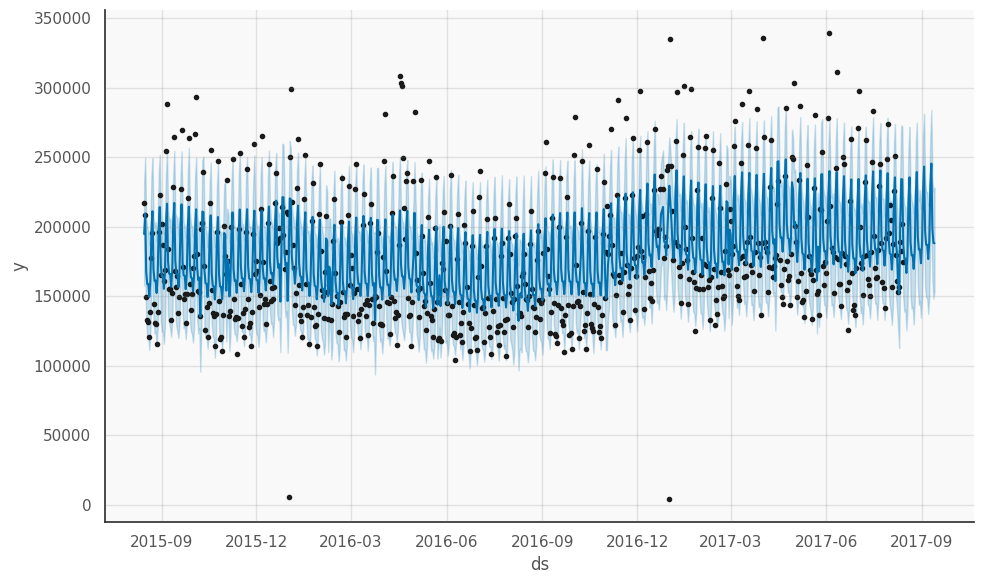

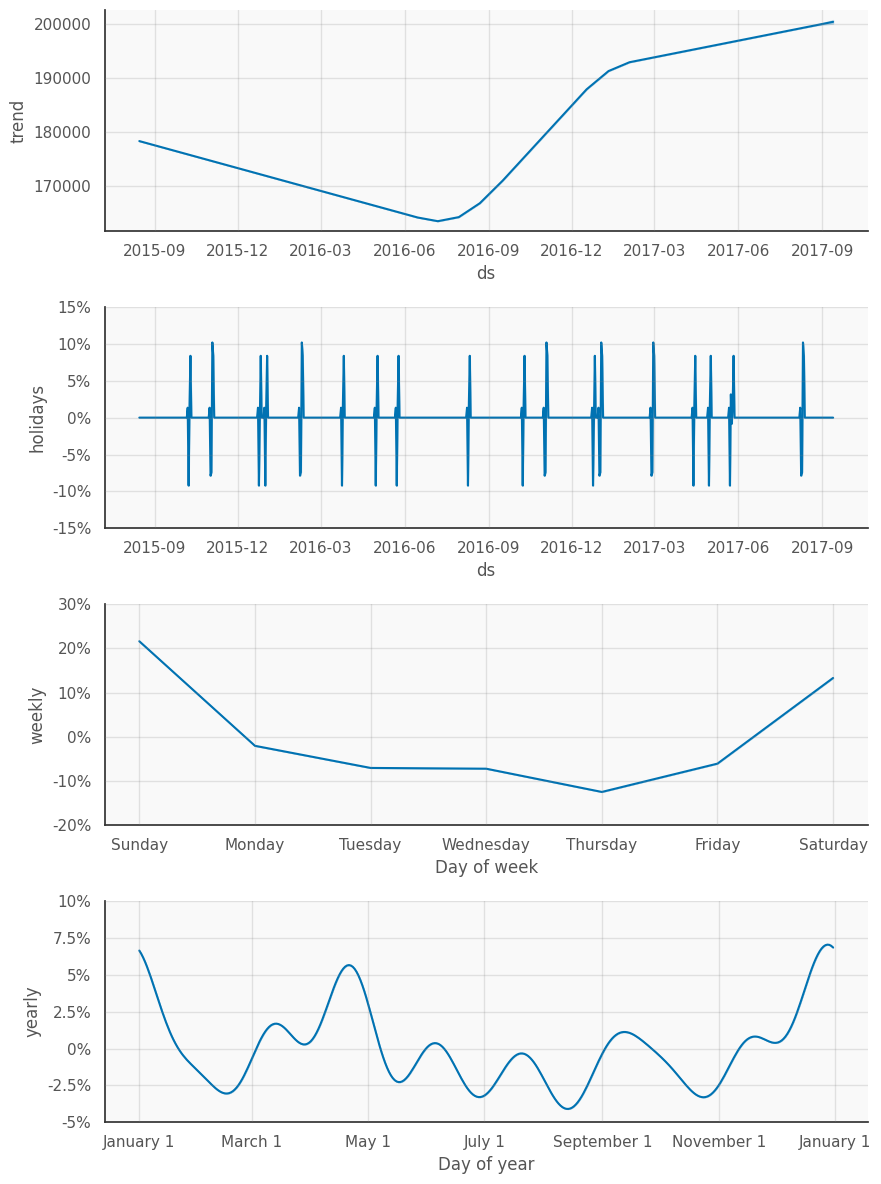

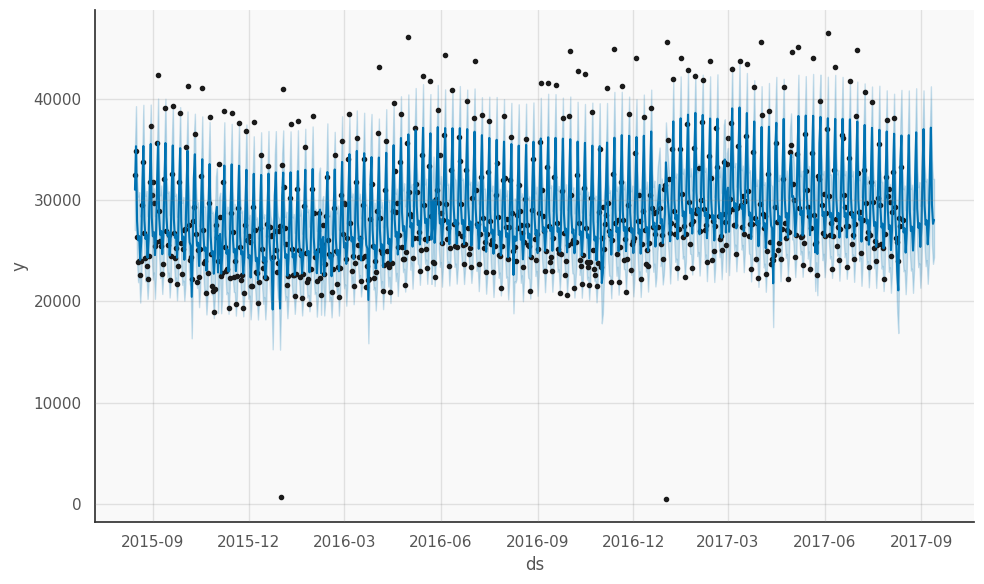

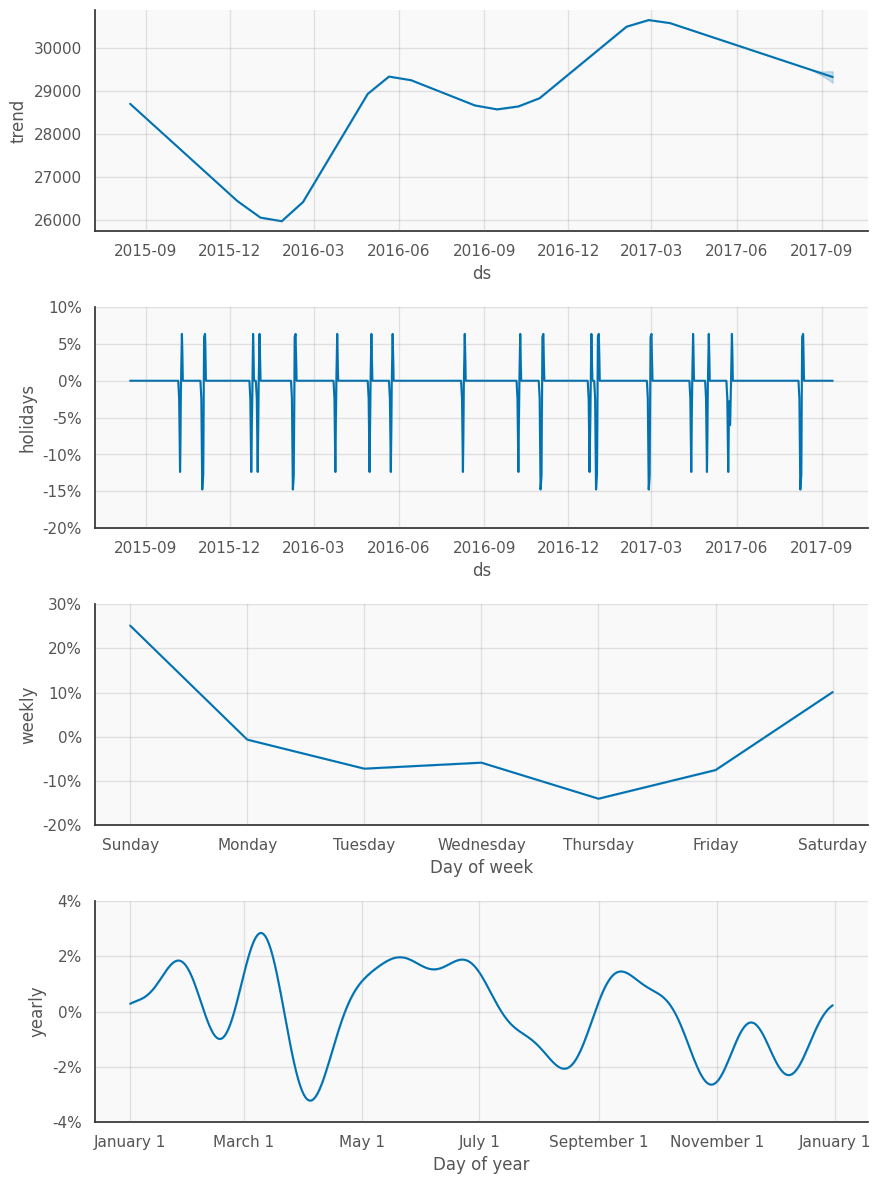

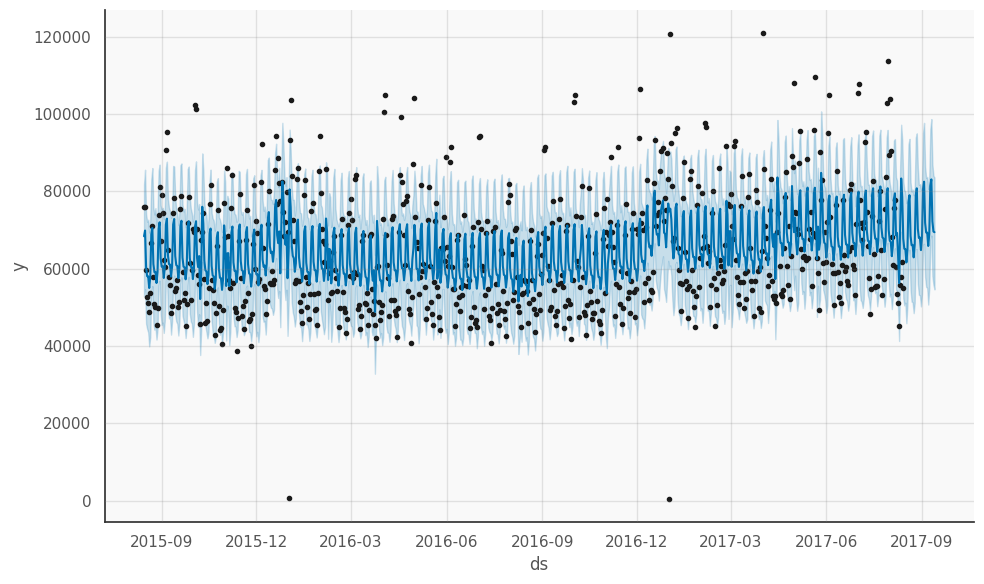

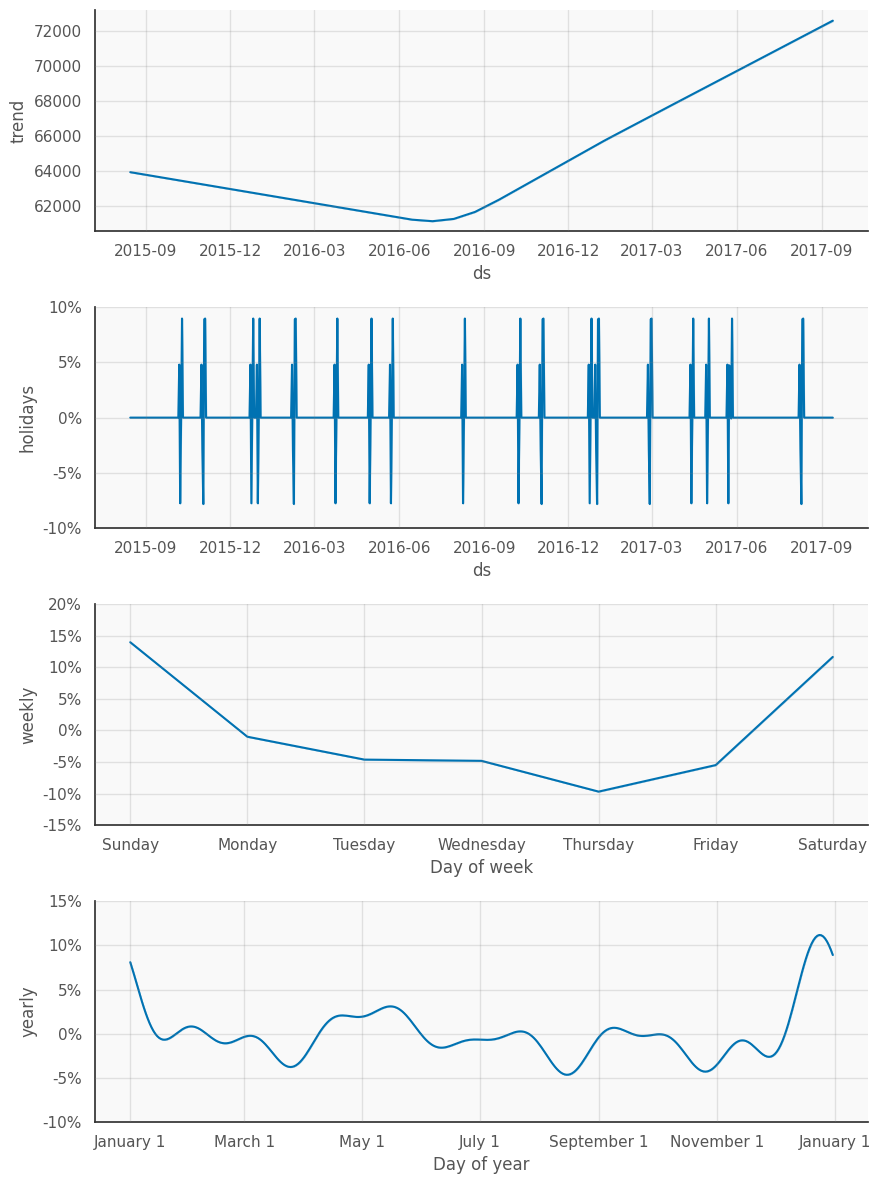

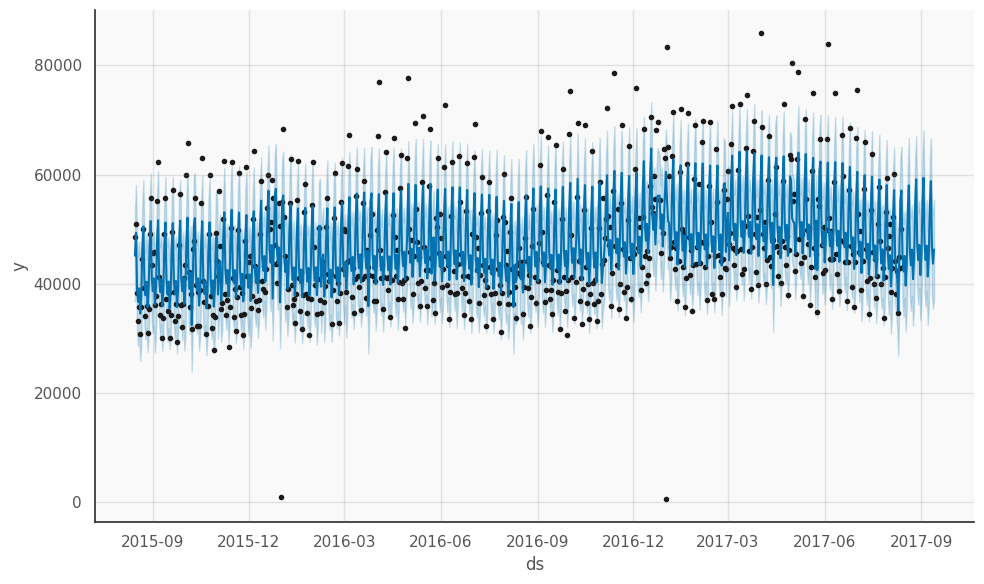

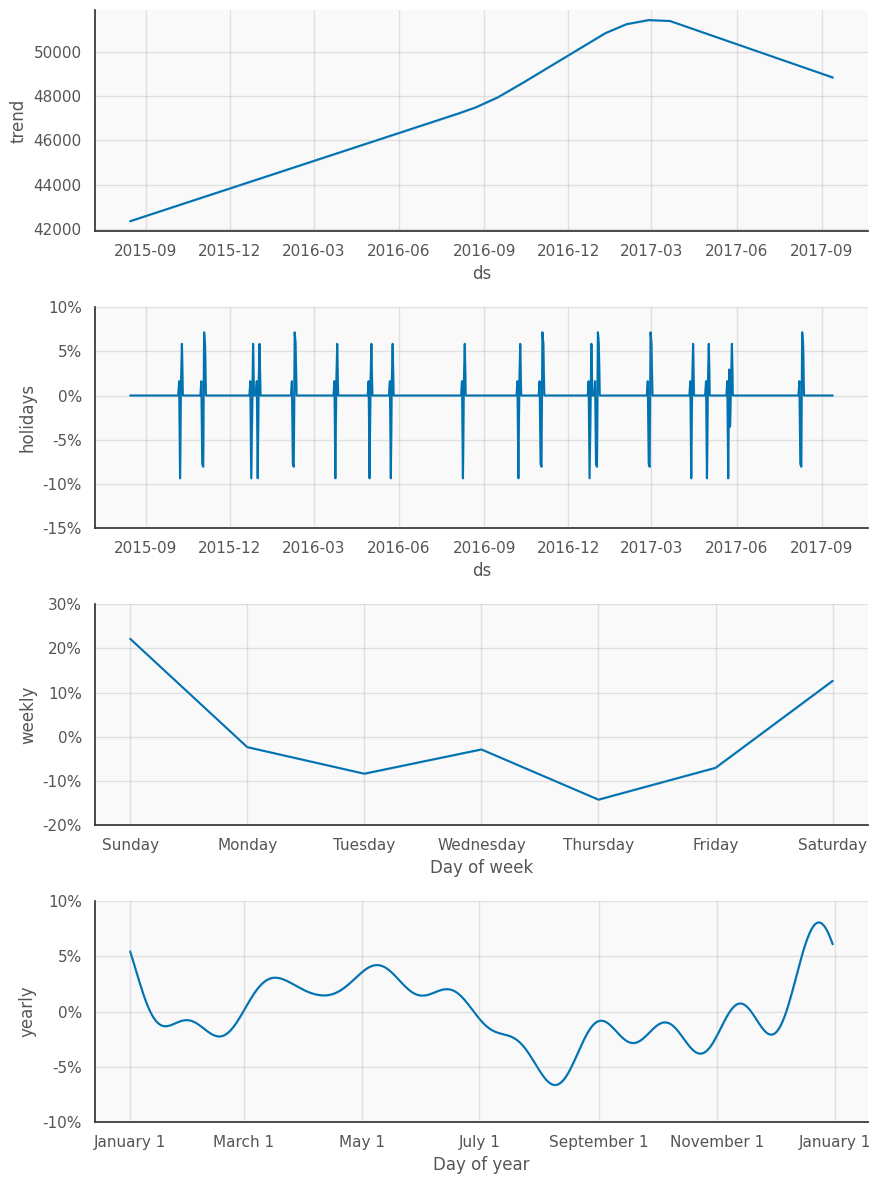

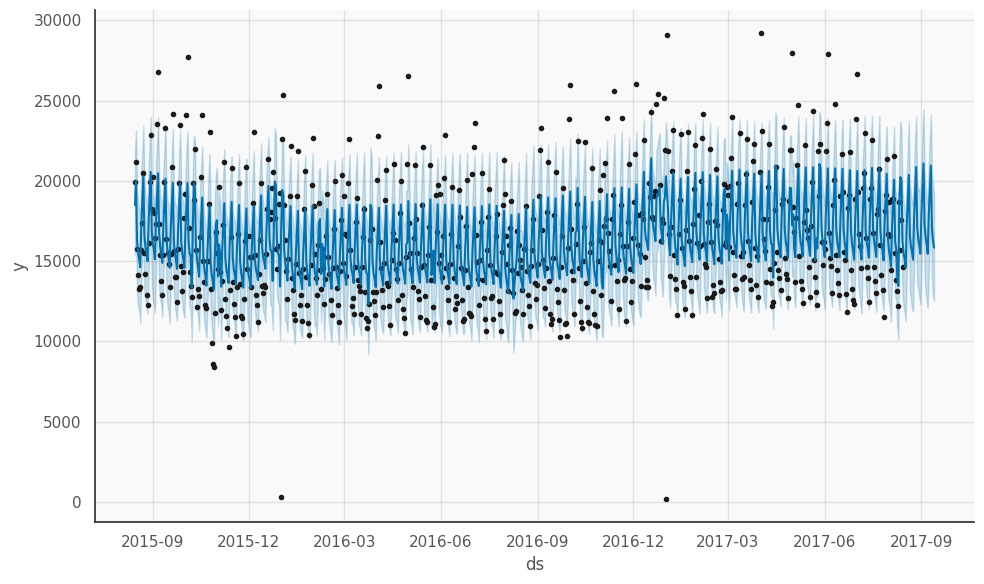

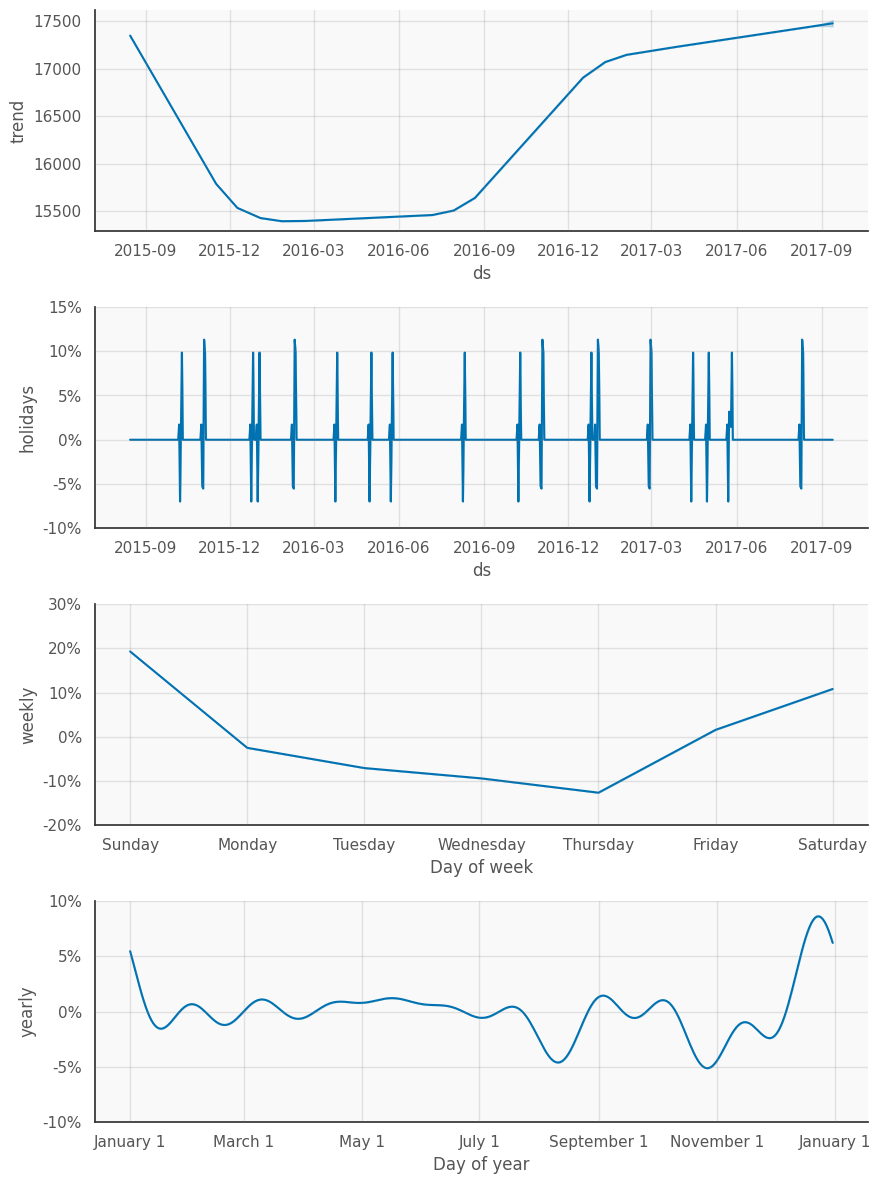

In [63]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)
